In [1]:
import json
import os
import warnings
from pathlib import Path
from typing import Any

import equinox as eqx
import jax.numpy as jnp
import jax.profiler
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from einops import rearrange, repeat
from ipywidgets import interact
from jax import config, device_count, random
from jax.scipy.optimize import minimize
from numpyencoder import NumpyEncoder
from scipy import constants
from stamox.sample import bootstrap

from jackpot.algorithms import AlgorithmChoice
from jackpot.algorithms.base import Algorithm
from jackpot.config import Config, JaxPlatform
from jackpot.fitting import SaturatingExponential
from jackpot.models.base import Model
from jackpot.models.ising import IsingModel
from jackpot.modules import AutocorrelationData
from jackpot.primitives.autocorrelate import acf
from jackpot.primitives.utils import beta_to_temp
from jackpot.profile import Stopwatch
from jackpot.state import Measurement, State
from jackpot.typing import RNGKey
from jackpot.utils.map import filter_map
from jackpot.utils.pbar import make_scan
from jackpot.utils.random import EasyKey

%load_ext autoreload
%autoreload 2

In [2]:
PAPERMILL: bool = False
PAPERMILL_INPUT_PATH: str = ""
PAPERMILL_OUTPUT_PATH: str = ""

In [3]:
# base
JAX_PLATFORM: JaxPlatform = JaxPlatform.CPU
DO_PROFILING: bool = False
ENABLE_64_BIT: bool = False
DO_AUTOCORRELATION: bool = False
DO_MEASURE: bool = True
PLOT_STATES: bool = False
CHECK_THERMALISED: bool = True

# experiment
RNG_SEED: int = 0
SPIN: float = 0.5
DIMENSIONS: int = 2
SIZE: int = 32
TOTAL_SAMPLES: int = 384
N_SAMPLES_VECTORISE: int = 2
LOOP_N_TEMPS_Y: bool = False


# environment
INTERACTION_BILINEAR: float = 1.0
INTERACTION_BIQUADRATIC: float = 0.0
INTERACTION_ANISOTROPY: float = 0.0
INTERACTION_BICUBIC: float = 0.0
INTERACTION_EXTERNAL_FIELD: float = 0.0
NUCLEAR_MAGNETIC_MOMENT: float = 1.0

# environment config
ALGORITHM: AlgorithmChoice = AlgorithmChoice.METROPOLIS_HASTINGS
PROBABILISTIC_CLUSTER_ACCEPT: bool = False

# temperatures
TEMP_MIN: float = 0.80
TEMP_MAX: float = 1.90
N_TEMPS: int = 96

# thermalisation
THERMALISE_STEPS: int = 50
THERMALISE_SWEEPS_PER_STEP: int = 50

# autocorrelation
AUTOCORRELATION_STEPS: int = 1000
AUTOCORRELATION_SWEEPS_PER_STEP: int = 2

# measure
MEASURE_EQUILIBRIUM_STEPS: int = 100
MEASURE_EQUILIBRIUM_NUM: int = 10
MEASURE_EQUILIBRIUM_SWEEPS_PER_STEP: int = 5

In [4]:
# Parameters
PAPERMILL_INPUT_PATH = "workbench.ipynb"
PAPERMILL_OUTPUT_PATH = "experiments/measure_3D/N64_wolff/experiment.ipynb"
PAPERMILL = True
RNG_SEED = 1
JAX_PLATFORM = "tpu"
ALGORITHM = "wolff"
DIMENSIONS = 3
SPIN = 0.5
TOTAL_SAMPLES = 256
N_TEMPS = 16
N_SAMPLES_VECTORISE = 16
THERMALISE_STEPS = 100
THERMALISE_SWEEPS_PER_STEP = 100
TEMP_MIN = 2.25
TEMP_MAX = 2.26
CHECK_THERMALISED = True
DO_AUTOCORRELATION = False
DO_MEASURE = True
MEASURE_EQUILIBRIUM_NUM = 1
MEASURE_EQUILIBRIUM_STEPS = 1000
MEASURE_EQUILIBRIUM_SWEEPS_PER_STEP = 10
PLOT_STATES = False
SIZE = 64


In [5]:
if not PAPERMILL:
    RNG_SEED = 1
    JAX_PLATFORM = "tpu"
    ALGORITHM = "wolff"
    DIMENSIONS = 3
    SPIN = 0.5
    TOTAL_SAMPLES = 64
    N_TEMPS = 32
    N_SAMPLES_VECTORISE = 2
    THERMALISE_STEPS = 100
    THERMALISE_SWEEPS_PER_STEP = 50
    TEMP_MIN = 2.2
    TEMP_MAX = 2.4
    DO_AUTOCORRELATION = False
    DO_MEASURE = True
    SIZE = 32

In [6]:
# Post init
if PAPERMILL:
    from tqdm.std import tqdm
else:
    from tqdm.notebook import tqdm

if PAPERMILL_OUTPUT_PATH:
    SAVE_PATH = Path(PAPERMILL_OUTPUT_PATH).parent.resolve()
else:
    SAVE_PATH = (Path() / "experiments" / "last").resolve()
to_save: dict[str, Any] = {}

print(f"{SAVE_PATH=}")

_CONFIG_VARS = [
    "JAX_PLATFORM",
    "DO_PROFILING",
    "ENABLE_64_BIT",
    "DO_AUTOCORRELATION",
    "DO_MEASURE",
    "PLOT_STATES",
    "CHECK_THERMALISED",
    "RNG_SEED",
    "SPIN",
    "DIMENSIONS",
    "SIZE",
    "TOTAL_SAMPLES",
    "N_SAMPLES_VECTORISE",
    "LOOP_N_TEMPS_Y",
    "THERMALISE_STEPS",
    "THERMALISE_SWEEPS_PER_STEP",
    "INTERACTION_BILINEAR",
    "INTERACTION_BIQUADRATIC",
    "INTERACTION_ANISOTROPY",
    "INTERACTION_BICUBIC",
    "INTERACTION_EXTERNAL_FIELD",
    "NUCLEAR_MAGNETIC_MOMENT",
    "ALGORITHM",
    "PROBABILISTIC_CLUSTER_ACCEPT",
    "TEMP_MIN",
    "TEMP_MAX",
    "N_TEMPS",
    "AUTOCORRELATION_STEPS",
    "AUTOCORRELATION_SWEEPS_PER_STEP",
    "MEASURE_EQUILIBRIUM_STEPS",
    "MEASURE_EQUILIBRIUM_NUM",
    "MEASURE_EQUILIBRIUM_SWEEPS_PER_STEP",
]

_CONFIG_DICT = {}

for var in _CONFIG_VARS:
    _CONFIG_DICT[var.lower()] = globals()[var]
    del globals()[var]

c = Config(**_CONFIG_DICT)

with open(SAVE_PATH / "config.json", "w") as f:
    f.write(c.json(indent=4))


# ---
match c.jax_platform:
    case JaxPlatform.CPU:
        config.update("jax_platform_name", "cpu")
        config.update("jax_platforms", "cpu")

        # CPU cores as separate devices
        os.environ[
            "XLA_FLAGS"
        ] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

    case JaxPlatform.TPU:
        config.update("jax_platform_name", "tpu")
        config.update("jax_platforms", "tpu")

        from jax.experimental.compilation_cache import compilation_cache

        compilation_cache.initialize_cache("/tmp/xla_comp_cache")

        # SEE: https://github.com/google/jax/discussions/12001#discussioncomment-3467948
        os.environ["LIBTPU_INIT_ARGS"] = "--xla_tpu_spmd_rng_bit_generator_unsafe=1"
        config.update("jax_default_prng_impl", "unsafe_rbg")

    case JaxPlatform.GPU:
        config.update("jax_platform_name", "gpu")
        config.update("jax_platforms", "gpu")

    case _:
        raise ValueError("Invalid JaxPlatform")

# config.update("jax_check_tracer_leaks", True)
if c.enable_64_bit:
    config.update("jax_enable_x64", True)

matplotlib.rcParams["figure.figsize"] = (10, 10)

if "_PROFILER_IS_RUNNING" not in globals() and c.do_profiling:
    _PROFILER_IS_RUNNING = True
    jax.profiler.start_server(9999)

Initialized persistent compilation cache at /tmp/xla_comp_cache


SAVE_PATH=PosixPath('/home/jeppe/Jackpot/experiments/measure_3D/N64_wolff')


In [7]:
# Init

DEVICE_COUNT = device_count()
to_save["DEVICE_COUNT"] = DEVICE_COUNT
rng_seed = c.rng_seed if c.rng_seed is not None else np.random.randint(0, 10**10)
to_save["rng_seed"] = rng_seed
k = EasyKey(rng_seed)
rng_key = k.new

MODEL_BASE_PARAMS = {
    "interaction_bilinear": c.interaction_bilinear,
    "interaction_biquadratic": c.interaction_biquadratic,
    "interaction_anisotropy": c.interaction_anisotropy,
    "interaction_bicubic": c.interaction_bicubic,
    "interaction_external_field": c.interaction_external_field,
    "nuclear_magnetic_moment": c.nuclear_magnetic_moment,
    # "probabilistic_cluster_accept": c.probabilistic_cluster_accept,
}

if c.n_temps < DEVICE_COUNT:
    warnings.warn(
        f"Should have at least {DEVICE_COUNT} temperatures for maximum throughput"
    )
N_TEMPS_X = DEVICE_COUNT if DEVICE_COUNT < c.n_temps else c.n_temps
N_TEMPS_Y = c.n_temps // N_TEMPS_X
to_save["N_TEMPS_X"] = N_TEMPS_X
to_save["N_TEMPS_Y"] = N_TEMPS_Y

if not N_TEMPS_X * N_TEMPS_Y == c.n_temps:
    raise ValueError(f"Temperatures should be a multiple of {DEVICE_COUNT}")

N_SAMPLES_PER_TEMP = c.total_samples // (N_TEMPS_X * N_TEMPS_Y)
N_SAMPLES_LOOP = N_SAMPLES_PER_TEMP // c.n_samples_vectorise
to_save["N_SAMPLES_PER_TEMP"] = N_SAMPLES_PER_TEMP
to_save["N_SAMPLES_LOOP"] = N_SAMPLES_LOOP

VECTORISATION_SHAPE = (N_SAMPLES_LOOP, N_TEMPS_X, N_TEMPS_Y, c.n_samples_vectorise)

print(f"Temperatures: {c.n_temps:_}")
print(f"{c.n_temps=}")
print(f"{N_TEMPS_X=}")
print(f"{N_TEMPS_Y=}")
print(f"{N_SAMPLES_PER_TEMP=}")
print(f"--{c.n_samples_vectorise=}")
print(f"--{N_SAMPLES_LOOP=}")

if not N_SAMPLES_LOOP * c.n_samples_vectorise == N_SAMPLES_PER_TEMP:
    raise ValueError(
        "Failed to factorise in a good way. " f"Factors: {VECTORISATION_SHAPE}"
    )
to_save["VECTORISATION_SHAPE"] = VECTORISATION_SHAPE

VECTORISED_COUNT = np.prod(VECTORISATION_SHAPE)
to_save["VECTORISED_COUNT"] = VECTORISED_COUNT
print(f"Vectorised count: {VECTORISED_COUNT:_}")

if not VECTORISED_COUNT == c.total_samples:
    raise ValueError(
        f"Got bad vectorised count: {VECTORISED_COUNT=} != {c.total_samples=}"
    )

TOTAL_SWEEPS = VECTORISED_COUNT * c.thermalise_sweeps_per_step * c.thermalise_steps
to_save["TOTAL_SWEEPS"] = TOTAL_SWEEPS
print(f"Total sweeps: {TOTAL_SWEEPS:_}")

temperatures = np.linspace(c.temp_min, c.temp_max, c.n_temps)
betas = 1.0 / temperatures

match c.algorithm:
    case AlgorithmChoice.WOLFF | AlgorithmChoice.SWENDSEN_WANG:
        algorithm = c.algorithm.resolve()(
            probabilistic_cluster_accept=c.probabilistic_cluster_accept
        )
    case _:
        algorithm = c.algorithm.resolve()()


def transforms(in_axes, out_axes=0):
    def inner(fun):
        # SAMPLES_VECTORISE
        fun = eqx.filter_vmap(fun, in_axes=in_axes, out_axes=out_axes)

        # TEMP_Y
        if c.loop_n_temps_y:
            fun = filter_map(fun)
        else:
            fun = eqx.filter_vmap(fun, in_axes=in_axes, out_axes=out_axes)

        # TEMP_X
        fun = eqx.filter_pmap(fun, in_axes=in_axes, out_axes=out_axes)

        # SAMPLES_LOOP
        fun = filter_map(fun)

        fun = eqx.filter_jit(fun)

        return fun

    return inner


def calculate_known_total(steps: int) -> int:
    total = steps
    total *= N_SAMPLES_LOOP
    total *= N_TEMPS_X

    if c.loop_n_temps_y:
        total *= N_TEMPS_Y

    return total

Temperatures: 16
c.n_temps=16
N_TEMPS_X=8
N_TEMPS_Y=2
N_SAMPLES_PER_TEMP=16
--c.n_samples_vectorise=16
--N_SAMPLES_LOOP=1
Vectorised count: 256
Total sweeps: 2_560_000


In [8]:
# Single state
if not PAPERMILL:
    model = IsingModel.new(spin=c.spin, **MODEL_BASE_PARAMS)
    state = State.new_uniform_random(
        rng_key=k.new,
        dimensions=c.dimensions,
        size=c.size,
        beta=1.0,
        model=model,
        algorithm=algorithm,
        id_=0,
    )

    initial_state = state

    state = state.evolve_sweeps(rng_key=k.new, sweeps=1)
    measured = state.measure()

    state.calculate_energy()
    state.calculate_magnetisation_density()

# Thermalisation

In [9]:
@transforms(in_axes=(0, None, None, 0, 0, None, None, None, None, None))
def make_and_thermalise_states(
    rng_key: RNGKey,
    dimensions: int,
    size: int,
    beta: float,
    id_: int,
    steps: int,
    sweeps_per_step: int,
    model: Model,
    algorithm: Algorithm,
    num_prints: int = 10,
) -> tuple[State, Measurement]:
    """
    Constructs states and thermalises them, returning measurements along the
    way in addition to the thermalised states.

    Arguments:
        rng_key: Source of randomness,
        dimensions: Dimensionality of the system,
        size: Size of each lattice dimension,
        beta: The inverse temperature,
        id_: An ID of the state,
        steps: Number of steps in which to thermalise the state,
        sweeps_per_step: How many times to perform a algorithm sweep per
            thermalisation step,
        model: Instance of the model to use,
        algorithm: An instance of the algorithm to use,
        num_prints: Number of times to update the progress bar (approximately),
    """
    rng_key, state_key = random.split(key=rng_key, num=2)

    state = State.new_minimal(
        rng_key=state_key,
        dimensions=dimensions,
        size=size,
        beta=beta,
        model=model,
        algorithm=algorithm,
        id_=id_,
    )

    def evolve_and_measure(state: State, x: RNGKey) -> tuple[State, Measurement]:
        _key = x
        state = state.evolve_sweeps(rng_key=_key, sweeps=sweeps_per_step)
        measurement = state.measure()

        return state, measurement

    keys = random.split(rng_key, num=steps)
    scan = make_scan(
        tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
    )
    state, measurements = scan(f=evolve_and_measure, init=state, xs=keys)

    return state, measurements


_betas = rearrange(betas, "(x y) -> x y", x=N_TEMPS_X, y=N_TEMPS_Y)
_betas = repeat(
    _betas,
    "x y -> s_loop x y s_vec",
    s_vec=c.n_samples_vectorise,
    s_loop=N_SAMPLES_LOOP,
)
shape = _betas.shape
print(f"{shape=}")

ids = np.arange(np.prod(shape)).reshape(shape)

# Make state
model = IsingModel.new(
    spin=c.spin,
    **MODEL_BASE_PARAMS,
)

# rng_key: RNGKey
# spin: floatj
# dimensions: int
# size: int
# beta: float
# id_: int
# steps: int
# sweeps_per_step: int
# kwargs: dict[str, Any]
# num_prints: int = 10
state_keys = k.shaped(shape)
thermalise_num_prints = 10

thermalise_compile_timer = Stopwatch.start()
make_and_thermalise_states_compiled = make_and_thermalise_states.lower(
    state_keys,
    c.dimensions,
    c.size,
    _betas,
    ids,
    c.thermalise_steps,
    c.thermalise_sweeps_per_step,
    model,
    algorithm,
    thermalise_num_prints,
).compile()
thermalise_compile_time = thermalise_compile_timer.time()
to_save["thermalise_compile_time"] = thermalise_compile_time
print(f"Compiled thermalisation program in: {thermalise_compile_time} sec.")

thermalise_run_timer = Stopwatch.start()
states, evolve_measurements = make_and_thermalise_states_compiled(
    state_keys,
    c.dimensions,
    c.size,
    _betas,
    ids,
    c.thermalise_steps,
    c.thermalise_sweeps_per_step,
    model,
    algorithm,
    thermalise_num_prints,
)
states.block_until_ready()
thermalise_run_time = thermalise_run_timer.time()
to_save["thermalise_run_time"] = thermalise_run_time
print(f"Ran thermalisation program in: {thermalise_run_time} sec.")

eqx.tree_serialise_leaves(SAVE_PATH / "states.eqx", states)

shape=(1, 8, 2, 16)


/home/jeppe/Jackpot/.venv/lib/python3.11/site-packages/jax/_src/dispatch.py:289: UserWarning: The jitted function make_and_thermalise_states includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


Compiled thermalisation program in: 10.893513679504395 sec.


  0%|                                                                                                  | 0/800 [00:00<?, ?it/s]

  2%|█▉                                                                                     | 18/800 [12:58<9:23:29, 43.23s/it]

  4%|███                                                                                    | 28/800 [13:18<5:21:47, 25.01s/it]

  5%|████▏                                                                                  | 38/800 [13:49<3:29:38, 16.51s/it]

  6%|█████▏                                                                                 | 48/800 [13:51<2:14:12, 10.71s/it]

  7%|██████▎                                                                                | 58/800 [14:02<1:32:20,  7.47s/it]

  8%|███████▍                                                                               | 68/800 [14:21<1:08:55,  5.65s/it]

 10%|████████▋                                                                                | 78/800 [14:24<47:31,  3.95s/it]

 11%|█████████▊                                                                               | 88/800 [14:28<33:56,  2.86s/it]

 12%|██████████▋                                                                            | 98/800 [25:48<4:28:11, 22.92s/it]

 14%|███████████▌                                                                          | 108/800 [26:49<3:25:05, 17.78s/it]

 15%|████████████▋                                                                         | 118/800 [27:13<2:28:54, 13.10s/it]

 16%|█████████████▊                                                                        | 128/800 [27:51<1:55:19, 10.30s/it]

 17%|██████████████▊                                                                       | 138/800 [28:06<1:24:11,  7.63s/it]

 18%|███████████████▉                                                                      | 148/800 [28:45<1:10:56,  6.53s/it]

 20%|█████████████████▍                                                                      | 158/800 [28:58<52:51,  4.94s/it]

 21%|██████████████████▍                                                                     | 168/800 [28:59<36:46,  3.49s/it]

 22%|███████████████████▏                                                                  | 178/800 [38:29<3:22:56, 19.58s/it]

 24%|████████████████████▏                                                                 | 188/800 [40:21<2:53:56, 17.05s/it]

 25%|█████████████████████▎                                                                | 198/800 [40:44<2:06:37, 12.62s/it]

 26%|██████████████████████▎                                                               | 208/800 [42:03<1:50:35, 11.21s/it]

 27%|███████████████████████▍                                                              | 218/800 [42:07<1:17:10,  7.96s/it]

 28%|████████████████████████▌                                                             | 228/800 [43:08<1:10:30,  7.40s/it]

 30%|██████████████████████████▏                                                             | 238/800 [43:41<57:48,  6.17s/it]

 31%|███████████████████████████▎                                                            | 248/800 [43:44<40:31,  4.40s/it]

 32%|███████████████████████████▋                                                          | 258/800 [51:17<2:30:41, 16.68s/it]

 34%|████████████████████████████▊                                                         | 268/800 [53:49<2:23:49, 16.22s/it]

 35%|█████████████████████████████▉                                                        | 278/800 [54:10<1:44:22, 12.00s/it]

 36%|██████████████████████████████▉                                                       | 288/800 [56:08<1:41:57, 11.95s/it]

 37%|████████████████████████████████                                                      | 298/800 [56:11<1:10:35,  8.44s/it]

 38%|█████████████████████████████████                                                     | 308/800 [57:42<1:10:54,  8.65s/it]

 40%|██████████████████████████████████▉                                                     | 318/800 [58:09<55:09,  6.87s/it]

 41%|████████████████████████████████████                                                    | 328/800 [58:29<42:32,  5.41s/it]

 42%|███████████████████████████████████▍                                                | 338/800 [1:04:02<1:45:54, 13.75s/it]

 44%|████████████████████████████████████▌                                               | 348/800 [1:07:18<1:56:53, 15.52s/it]

 45%|█████████████████████████████████████▌                                              | 358/800 [1:07:54<1:28:02, 11.95s/it]

 46%|██████████████████████████████████████▋                                             | 368/800 [1:10:16<1:30:58, 12.64s/it]

 47%|███████████████████████████████████████▋                                            | 378/800 [1:10:30<1:05:04,  9.25s/it]

 48%|████████████████████████████████████████▋                                           | 388/800 [1:12:23<1:07:45,  9.87s/it]

 50%|██████████████████████████████████████████▊                                           | 398/800 [1:12:35<48:38,  7.26s/it]

 51%|███████████████████████████████████████████▊                                          | 408/800 [1:13:05<39:06,  5.99s/it]

 52%|███████████████████████████████████████████▉                                        | 418/800 [1:16:27<1:05:12, 10.24s/it]

 54%|████████████████████████████████████████████▉                                       | 428/800 [1:20:46<1:32:44, 14.96s/it]

 55%|█████████████████████████████████████████████▉                                      | 438/800 [1:21:27<1:10:28, 11.68s/it]

 56%|███████████████████████████████████████████████                                     | 448/800 [1:24:32<1:20:35, 13.74s/it]

 57%|█████████████████████████████████████████████████▏                                    | 458/800 [1:24:42<56:32,  9.92s/it]

 58%|█████████████████████████████████████████████████▏                                  | 468/800 [1:27:04<1:02:00, 11.21s/it]

 60%|███████████████████████████████████████████████████▍                                  | 478/800 [1:27:14<43:37,  8.13s/it]

 61%|████████████████████████████████████████████████████▍                                 | 488/800 [1:27:47<34:44,  6.68s/it]

 62%|█████████████████████████████████████████████████████▌                                | 498/800 [1:29:13<36:31,  7.26s/it]

 64%|█████████████████████████████████████████████████████▎                              | 508/800 [1:34:16<1:08:59, 14.17s/it]

 65%|███████████████████████████████████████████████████████▋                              | 518/800 [1:34:56<52:19, 11.13s/it]

 66%|███████████████████████████████████████████████████████▍                            | 528/800 [1:38:53<1:07:31, 14.89s/it]

 67%|█████████████████████████████████████████████████████████▊                            | 538/800 [1:38:57<46:06, 10.56s/it]

 68%|██████████████████████████████████████████████████████████▉                           | 548/800 [1:41:42<51:49, 12.34s/it]

 70%|███████████████████████████████████████████████████████████▉                          | 558/800 [1:41:43<34:53,  8.65s/it]

 71%|█████████████████████████████████████████████████████████████                         | 568/800 [1:42:14<27:02,  6.99s/it]

 72%|██████████████████████████████████████████████████████████████▏                       | 578/800 [1:42:30<19:53,  5.38s/it]

 74%|███████████████████████████████████████████████████████████████▏                      | 588/800 [1:47:38<45:58, 13.01s/it]

 75%|████████████████████████████████████████████████████████████████▎                     | 598/800 [1:48:50<37:55, 11.26s/it]

 76%|█████████████████████████████████████████████████████████████████▎                    | 608/800 [1:53:04<49:34, 15.49s/it]

 77%|██████████████████████████████████████████████████████████████████▍                   | 618/800 [1:53:05<32:58, 10.87s/it]

 77%|██████████████████████████████████████████████████████████████████▍                   | 618/800 [1:53:20<32:58, 10.87s/it]

 78%|███████████████████████████████████████████████████████████████████▌                  | 628/800 [1:54:39<29:55, 10.44s/it]

 80%|████████████████████████████████████████████████████████████████████▍                 | 637/800 [1:55:56<26:53,  9.90s/it]

 81%|█████████████████████████████████████████████████████████████████████▌                | 647/800 [1:56:03<18:07,  7.11s/it]

 82%|██████████████████████████████████████████████████████████████████████▋               | 657/800 [1:56:21<13:04,  5.49s/it]

 83%|███████████████████████████████████████████████████████████████████████▋              | 667/800 [1:57:18<12:15,  5.53s/it]

 85%|████████████████████████████████████████████████████████████████████████▊             | 677/800 [2:01:15<22:35, 11.02s/it]

 86%|█████████████████████████████████████████████████████████████████████████▊            | 687/800 [2:02:24<18:27,  9.80s/it]

 87%|██████████████████████████████████████████████████████████████████████████▊           | 696/800 [2:02:35<12:47,  7.38s/it]

 88%|███████████████████████████████████████████████████████████████████████████▊          | 705/800 [2:03:44<11:50,  7.48s/it]

 89%|████████████████████████████████████████████████████████████████████████████▊         | 715/800 [2:07:10<16:22, 11.56s/it]

 91%|█████████████████████████████████████████████████████████████████████████████▉        | 725/800 [2:07:26<10:38,  8.51s/it]

 92%|██████████████████████████████████████████████████████████████████████████████▉       | 734/800 [2:08:33<09:00,  8.19s/it]

 93%|███████████████████████████████████████████████████████████████████████████████▊      | 743/800 [2:08:52<06:07,  6.45s/it]

 94%|████████████████████████████████████████████████████████████████████████████████▉     | 753/800 [2:10:27<05:47,  7.40s/it]

 95%|██████████████████████████████████████████████████████████████████████████████████    | 763/800 [2:10:47<03:31,  5.72s/it]

 96%|██████████████████████████████████████████████████████████████████████████████████▉   | 772/800 [2:11:54<02:54,  6.23s/it]

 98%|████████████████████████████████████████████████████████████████████████████████████  | 782/800 [2:12:05<01:23,  4.63s/it]

 99%|█████████████████████████████████████████████████████████████████████████████████████ | 791/800 [2:12:13<00:31,  3.54s/it]

100%|██████████████████████████████████████████████████████████████████████████████████████| 800/800 [2:13:33<00:00,  5.09s/it]

Ran thermalisation program in: 8804.06677865982 sec.


In [10]:
_evolve_meas_df = evolve_measurements.to_df()
evolve_meas_df = _evolve_meas_df.explode(
    _evolve_meas_df.columns.tolist()
).infer_objects()

evolve_meas_df["temp"] = beta_to_temp(evolve_meas_df["beta"], human=True)
evolve_meas_df["abs_magnetisation_density"] = np.abs(
    evolve_meas_df["magnetisation_density"]
)

In [11]:
# Get only last measurements
last_meas_df = (
    evolve_meas_df.sort_values("sweeps", ascending=False).groupby("state_id").first()
)
n_steps = last_meas_df["steps"].sum()

flip_rate = n_steps / (thermalise_run_time * 1e6)  # flips / μs
to_save["flip_rate"] = flip_rate
print(f"Flip rate: {flip_rate} flips/μs")

Flip rate: 2.1864254669965377 flips/μs


In [12]:
evolve_meas_df.reset_index().to_feather(SAVE_PATH / "evolve_meas_df.feather")

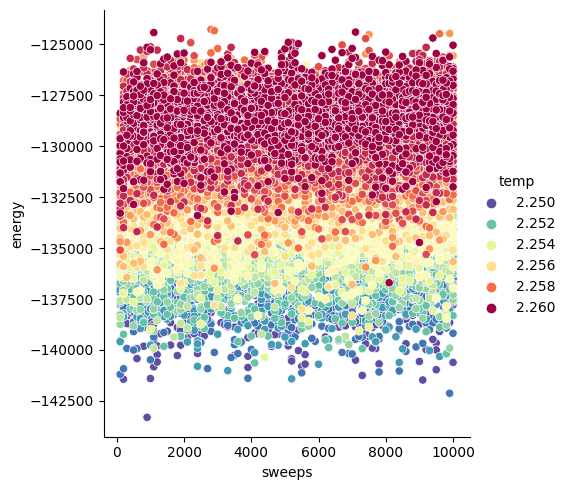

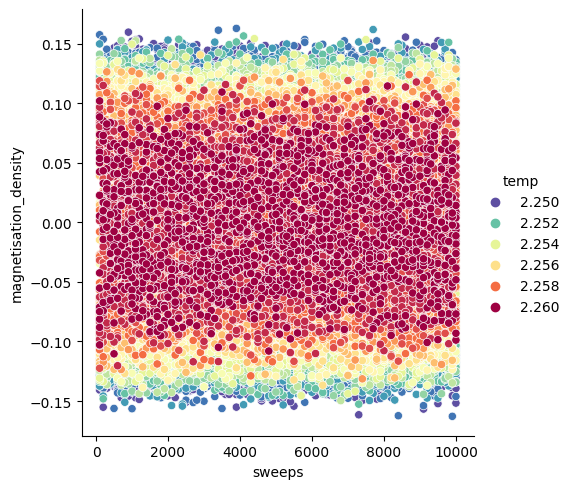

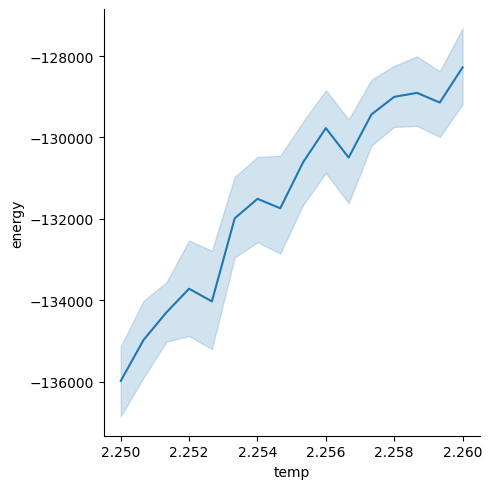

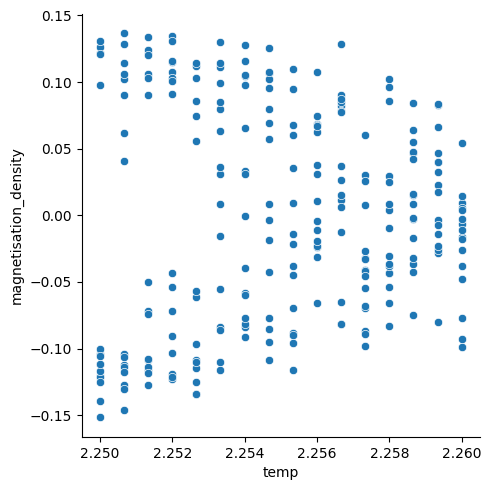

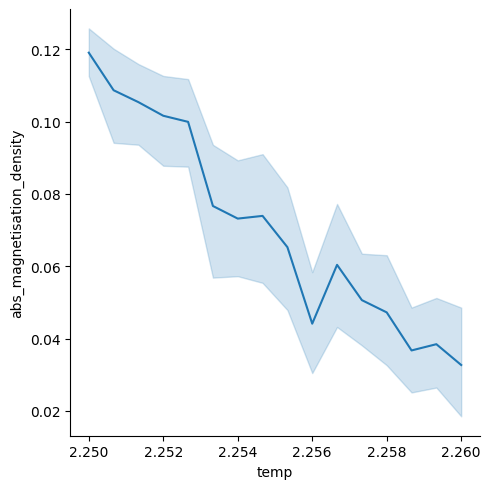

In [13]:
fig_evolve_energy_sweeps = sns.relplot(
    data=evolve_meas_df,
    x="sweeps",
    y="energy",
    hue="temp",
    palette="Spectral_r",
)
fig_evolve_energy_sweeps.savefig(SAVE_PATH / "fig_evolve_energy_sweeps.png")

fig_evolve_mag_dens_sweeps = sns.relplot(
    data=evolve_meas_df,
    x="sweeps",
    y="magnetisation_density",
    hue="temp",
    palette="Spectral_r",
)
fig_evolve_mag_dens_sweeps.savefig(SAVE_PATH / "fig_evolve_mag_dens_sweeps.png")

last_sweeps = evolve_meas_df[
    evolve_meas_df["sweeps"] == np.max(evolve_meas_df["sweeps"])
]

fig_evolve_energy_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="energy",
    # hue="beta",
    kind="line",
    # errorbar=None
)
fig_evolve_energy_temp.savefig(SAVE_PATH / "fig_evolve_energy_temp.png")

fig_evolve_mag_dens_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="magnetisation_density",
)
fig_evolve_mag_dens_temp.savefig(SAVE_PATH / "fig_evolve_mag_dens_temp.png")

fig_evolve_abs_mag_dens_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="abs_magnetisation_density",
    kind="line",
    # errorbar=None
)
fig_evolve_abs_mag_dens_temp.savefig(SAVE_PATH / "fig_evolve_abs_mag_dens_temp.png")

In [14]:
if c.plot_states:
    states_list = states.unensamble()
    temp_states = states_list[: c.n_temps]

In [15]:
if c.plot_states:

    @interact(value=0, min=0, max=len(temp_states))
    def update(i=(0, len(temp_states) - 1)):
        fig = temp_states[i].plot()
        fig.set_size_inches(10, 10)
        fig.dpi = 100

    ...

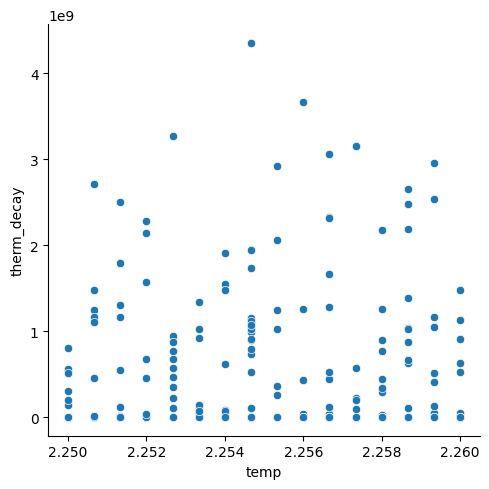

In [16]:
if c.check_thermalised:
    # Fit saturating decay times to quantifiably understand whether we have fully thermalised
    def fit_thermalisation(group):
        x = group["sweeps"]
        y = group["energy"]

        amplitude = np.max(y) - np.min(y)
        decay = np.max(x)
        offset = y.iloc[-1]

        params = SaturatingExponential.make_params()
        params["amplitude"].set(amplitude)
        params["decay"].set(decay, min=0, max=np.inf)
        params["c"].set(offset)

        fit = SaturatingExponential.fit(y, params, x=x)

        assert np.ptp(group["temp"]) == 0.0

        return pd.Series(
            {
                "temp": group["temp"].iloc[0],
                "therm_amplitude": fit.params["amplitude"].value,
                "therm_amplitude_sd": fit.params["amplitude"].stderr,
                "therm_decay": fit.params["decay"].value,
                "therm_decay_sd": fit.params["decay"].stderr,
                "therm_offset": fit.params["c"].value,
                "therm_offset_sd": fit.params["c"].stderr,
            }
        )

    evolve_meas_fit_df = evolve_meas_df.groupby("state_id", as_index=False).apply(
        fit_thermalisation
    )
    fig_evolve_therm_fit = sns.relplot(
        data=evolve_meas_fit_df,
        x="temp",
        y="therm_decay",
    )
    fig_evolve_therm_fit.savefig(SAVE_PATH / "fig_evolve_therm_fit.png")

    def _has_thermalised():
        high_temp_df = evolve_meas_fit_df[
            evolve_meas_fit_df["temp"] == evolve_meas_fit_df["temp"].max()
        ]
        therm_check_df = high_temp_df[
            high_temp_df["therm_decay"] > 4.0 * high_temp_df["therm_decay_sd"]
        ]

        # We have no data to check probably because system is very very thermalised
        # and thus has no data to fit to exponential
        if not len(therm_check_df):
            return True

        longest_decay = therm_check_df["therm_decay"].max()
        print(longest_decay)
        if evolve_meas_df["sweeps"].max() > 6.0 * longest_decay:
            return True

        return False

    has_thermalised = _has_thermalised()

    if not has_thermalised:
        raise RuntimeError("System has not fully thermalised!")

# Autocorrelation

In [17]:
if c.do_autocorrelation:

    @transforms(in_axes=(0, 0, None, None, None), out_axes=0)
    def get_autocorrelation(
        key: RNGKey, state: State, steps: int, sweeps_per_step: int, num_prints: int
    ) -> AutocorrelationData:
        keys = random.split(key, num=steps)

        def get_measurement_scan(state: State, x: RNGKey) -> tuple[State, Measurement]:
            rng_key = x
            state = state.evolve_sweeps(rng_key=rng_key, sweeps=sweeps_per_step)
            measurement = state.measure()

            return state, measurement

        scan = make_scan(
            tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
        )
        state, measurements = scan(f=get_measurement_scan, init=state, xs=keys)

        acorr_energy = acf(measurements.energy)
        acorr_mag_dens = acf(jnp.abs(measurements.magnetisation_density))

        sweeps = jnp.arange(acorr_energy.size) * sweeps_per_step

        # Fit exponential decay to find characteristic autocorrelation time
        def exponential_decay(x, tau):
            """
            f(x) = exp(- x / τ)
            """
            return jnp.exp(-x / tau)

        # Objective function to minimise
        def objective(params, x, y, weights):
            tau = params
            trial = exponential_decay(x, tau)
            residuals = y - trial
            weighted_residuals = weights * residuals

            return jnp.sum(weighted_residuals**2)

        energy_initial_params = jnp.asarray([float(sweeps_per_step)])
        # Noise at high x (low y) dominates fit.
        # Weigh by ordinate magnitude
        energy_weights = jnp.abs(acorr_energy)
        energy_decay_time = minimize(
            objective,
            x0=energy_initial_params,
            method="BFGS",
            args=(sweeps, acorr_energy, energy_weights),
        ).x[0]

        mag_dens_initial_params = jnp.asarray([float(sweeps_per_step)])
        mag_dens_weights = jnp.abs(acorr_mag_dens)
        mag_dens_decay_time = minimize(
            objective,
            x0=mag_dens_initial_params,
            method="BFGS",
            args=(sweeps, acorr_mag_dens, mag_dens_weights),
        ).x[0]

        return AutocorrelationData(
            state=state,
            steps=steps,
            sweeps_per_step=sweeps_per_step,
            sweeps=sweeps,
            energy=acorr_energy,
            magnetisation_density=acorr_mag_dens,
            energy_decay_time=energy_decay_time,
            magnetisation_density_decay_time=mag_dens_decay_time,
        )

    keys = k.shaped(states.transformation_shape)

    autocorrelation_timer = Stopwatch.start()
    ac_data = get_autocorrelation(
        keys, states, c.autocorrelation_steps, c.autocorrelation_sweeps_per_step, 10
    )
    ac_data.block_until_ready()

    autocorrelation_time = autocorrelation_timer.time()
    to_save["autocorrelation_time"] = autocorrelation_time
    print(f"Ran autocorrelation program in: {autocorrelation_time} sec.")

    eqx.tree_serialise_leaves(SAVE_PATH / "ac_data.eqx", ac_data)

In [18]:
if c.do_autocorrelation:
    ac_df = ac_data.to_df()
    ac_df["temp"] = beta_to_temp(ac_df["state.beta"], human=True)
    ac_df_expl = ac_df.explode(
        ["energy", "magnetisation_density", "sweeps"]
    ).infer_objects()

    ac_df_expl["energy_fit"] = np.exp(
        -ac_df_expl["sweeps"] / ac_df_expl["energy_decay_time"]
    )
    ac_df_expl["mag_dens_fit"] = np.exp(
        -ac_df_expl["sweeps"] / ac_df_expl["magnetisation_density_decay_time"]
    )

    display(ac_df)
    display(ac_df_expl)

    ac_df.reset_index().to_feather(SAVE_PATH / "ac_df.feather")
    ac_df_expl.reset_index().to_feather(SAVE_PATH / "ac_df_expl.feather")

In [19]:
if c.do_autocorrelation:
    fig_autocorrelation_energy = plt.figure()
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="energy",
        hue="temp",
        palette="Spectral_r",
        errorbar=None,
    )
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="energy_fit",
        hue="temp",
        palette="Spectral_r",
        ls="--",
        errorbar=None,
    )
    fig_autocorrelation_energy.savefig(SAVE_PATH / "fig_autocorrelation_energy.png")

    fig_autocorrelation_mag_dens = plt.figure()
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="magnetisation_density",
        hue="temp",
        palette="Spectral_r",
        errorbar=None,
    )
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="mag_dens_fit",
        hue="temp",
        palette="Spectral_r",
        ls="--",
        errorbar=None,
    )
    fig_autocorrelation_mag_dens.savefig(SAVE_PATH / "fig_autocorrelation_mag_dens.png")

    fig_autocorrelation_decay_times, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    sns.lineplot(
        data=ac_df,
        x="temp",
        y="energy_decay_time",
        ax=ax1,
    )
    sns.lineplot(
        data=ac_df,
        x="temp",
        y="magnetisation_density_decay_time",
        ax=ax2,
        color="orange",
    )
    plt.show()
    fig_autocorrelation_decay_times.savefig(
        SAVE_PATH / "fig_autocorrelation_decay_times.png"
    )

# Measure Equilibrium

In [20]:
if c.do_measure:

    @transforms(in_axes=(0, 0, None, None, None, None), out_axes=0)
    def measure_equilibrium(
        key: RNGKey, state: State, steps: int, num: int, sweeps: int, num_prints: int
    ) -> Measurement:
        def body_fun(carry: State, x: RNGKey):
            _rng_key = x
            measurements = carry.evolve_and_measure_multiple(
                rng_key=_rng_key, num=num, sweeps=sweeps
            )

            return carry, measurements

        keys = random.split(key=key, num=steps)
        scan = make_scan(
            tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
        )
        state, measurements = scan(f=body_fun, init=state, xs=keys)

        return measurements

    keys = k.shaped(states.transformation_shape)

    measurement_timer = Stopwatch.start()
    equil_measurements = measure_equilibrium(
        keys,
        states,
        c.measure_equilibrium_steps,
        c.measure_equilibrium_num,
        c.measure_equilibrium_sweeps_per_step,
        250,
    )
    equil_measurements.block_until_ready()

    measurement_time = measurement_timer.time()
    to_save["measurement_time"] = measurement_time
    print(f"Ran measurement program in: {measurement_time} sec.")

    eqx.tree_serialise_leaves(SAVE_PATH / "equil_measurements.eqx", equil_measurements)

/home/jeppe/Jackpot/.venv/lib/python3.11/site-packages/jax/_src/dispatch.py:289: UserWarning: The jitted function measure_equilibrium includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


  0%|                                                                                                 | 0/8000 [00:00<?, ?it/s]

  0%|▏                                                                                     | 12/8000 [00:30<5:37:59,  2.54s/it]

  0%|▏                                                                                     | 16/8000 [00:32<4:08:18,  1.87s/it]

  0%|▏                                                                                     | 20/8000 [00:32<2:51:16,  1.29s/it]

  0%|▎                                                                                     | 24/8000 [00:33<2:05:09,  1.06it/s]

  0%|▎                                                                                     | 28/8000 [00:33<1:34:09,  1.41it/s]

  0%|▎                                                                                     | 32/8000 [00:34<1:09:26,  1.91it/s]

  0%|▍                                                                                       | 36/8000 [00:35<57:37,  2.30it/s]

  1%|▍                                                                                     | 44/8000 [01:02<3:57:47,  1.79s/it]

  1%|▌                                                                                     | 48/8000 [01:03<3:09:16,  1.43s/it]

  1%|▌                                                                                     | 52/8000 [01:05<2:37:56,  1.19s/it]

  1%|▌                                                                                     | 56/8000 [01:07<2:10:03,  1.02it/s]

  1%|▋                                                                                     | 60/8000 [01:08<1:43:22,  1.28it/s]

  1%|▋                                                                                     | 68/8000 [01:11<1:17:50,  1.70it/s]

  1%|▊                                                                                     | 72/8000 [01:12<1:13:47,  1.79it/s]

  1%|▊                                                                                     | 76/8000 [01:30<3:26:46,  1.57s/it]

  1%|▊                                                                                     | 80/8000 [01:33<2:58:05,  1.35s/it]

  1%|▉                                                                                     | 84/8000 [01:38<2:49:35,  1.29s/it]

  1%|▉                                                                                     | 88/8000 [01:40<2:24:43,  1.10s/it]

  1%|█                                                                                     | 96/8000 [01:41<1:21:56,  1.61it/s]

  1%|█                                                                                    | 100/8000 [01:45<1:34:21,  1.40it/s]

  1%|█                                                                                    | 104/8000 [01:48<1:35:05,  1.38it/s]

  1%|█▏                                                                                   | 108/8000 [02:02<3:15:29,  1.49s/it]

  1%|█▏                                                                                   | 112/8000 [02:05<2:52:18,  1.31s/it]

  1%|█▏                                                                                   | 116/8000 [02:10<2:50:50,  1.30s/it]

  2%|█▎                                                                                   | 120/8000 [02:13<2:30:06,  1.14s/it]

  2%|█▎                                                                                   | 124/8000 [02:15<1:59:22,  1.10it/s]

  2%|█▎                                                                                   | 128/8000 [02:15<1:27:41,  1.50it/s]

  2%|█▍                                                                                   | 132/8000 [02:20<1:44:42,  1.25it/s]

  2%|█▍                                                                                   | 136/8000 [02:23<1:49:30,  1.20it/s]

  2%|█▍                                                                                   | 140/8000 [02:34<3:03:09,  1.40s/it]

  2%|█▌                                                                                   | 144/8000 [02:34<2:11:02,  1.00s/it]

  2%|█▌                                                                                   | 148/8000 [02:42<2:48:56,  1.29s/it]

  2%|█▌                                                                                   | 152/8000 [02:48<2:58:13,  1.36s/it]

  2%|█▋                                                                                   | 156/8000 [02:50<2:24:25,  1.10s/it]

  2%|█▋                                                                                   | 160/8000 [02:51<1:46:56,  1.22it/s]

  2%|█▋                                                                                   | 164/8000 [02:55<1:55:44,  1.13it/s]

  2%|█▊                                                                                   | 168/8000 [02:56<1:33:02,  1.40it/s]

  2%|█▊                                                                                   | 172/8000 [03:01<1:54:33,  1.14it/s]

  2%|█▊                                                                                   | 176/8000 [03:06<2:06:29,  1.03it/s]

  2%|█▉                                                                                   | 180/8000 [03:13<2:38:15,  1.21s/it]

  2%|█▉                                                                                   | 184/8000 [03:22<3:11:11,  1.47s/it]

  2%|█▉                                                                                   | 188/8000 [03:23<2:27:25,  1.13s/it]

  2%|██                                                                                   | 192/8000 [03:24<1:50:07,  1.18it/s]

  2%|██                                                                                   | 196/8000 [03:30<2:22:16,  1.09s/it]

  2%|██▏                                                                                  | 200/8000 [03:31<1:41:21,  1.28it/s]

  3%|██▏                                                                                  | 204/8000 [03:32<1:23:28,  1.56it/s]

  3%|██▏                                                                                  | 208/8000 [03:39<2:07:46,  1.02it/s]

  3%|██▎                                                                                  | 212/8000 [03:46<2:42:06,  1.25s/it]

  3%|██▎                                                                                  | 216/8000 [03:54<3:07:52,  1.45s/it]

  3%|██▎                                                                                  | 220/8000 [03:55<2:23:57,  1.11s/it]

  3%|██▍                                                                                  | 224/8000 [03:58<2:08:06,  1.01it/s]

  3%|██▍                                                                                  | 228/8000 [04:03<2:14:41,  1.04s/it]

  3%|██▍                                                                                  | 232/8000 [04:05<1:58:12,  1.10it/s]

  3%|██▌                                                                                  | 236/8000 [04:07<1:37:00,  1.33it/s]

  3%|██▌                                                                                  | 240/8000 [04:09<1:32:16,  1.40it/s]

  3%|██▌                                                                                  | 244/8000 [04:18<2:27:07,  1.14s/it]

  3%|██▋                                                                                  | 248/8000 [04:27<3:12:51,  1.49s/it]

  3%|██▋                                                                                  | 252/8000 [04:29<2:31:32,  1.17s/it]

  3%|██▋                                                                                  | 256/8000 [04:32<2:12:46,  1.03s/it]

  3%|██▊                                                                                  | 260/8000 [04:33<1:48:44,  1.19it/s]

  3%|██▊                                                                                  | 264/8000 [04:41<2:27:06,  1.14s/it]

  3%|██▊                                                                                  | 268/8000 [04:41<1:47:27,  1.20it/s]

  3%|██▉                                                                                  | 272/8000 [04:42<1:24:23,  1.53it/s]

  3%|██▉                                                                                  | 276/8000 [04:51<2:23:21,  1.11s/it]

  4%|██▉                                                                                  | 280/8000 [05:00<3:09:38,  1.47s/it]

  4%|███                                                                                  | 284/8000 [05:03<2:38:13,  1.23s/it]

  4%|███                                                                                  | 288/8000 [05:03<1:57:16,  1.10it/s]

  4%|███                                                                                  | 292/8000 [05:06<1:48:09,  1.19it/s]

  4%|███▏                                                                                 | 296/8000 [05:14<2:29:49,  1.17s/it]

  4%|███▏                                                                                 | 300/8000 [05:16<2:04:28,  1.03it/s]

  4%|███▏                                                                                 | 304/8000 [05:16<1:31:42,  1.40it/s]

  4%|███▎                                                                                 | 308/8000 [05:24<2:23:19,  1.12s/it]

  4%|███▎                                                                                 | 312/8000 [05:33<3:03:35,  1.43s/it]

  4%|███▎                                                                                 | 316/8000 [05:34<2:17:12,  1.07s/it]

  4%|███▍                                                                                 | 320/8000 [05:37<2:02:22,  1.05it/s]

  4%|███▍                                                                                 | 324/8000 [05:39<1:42:15,  1.25it/s]

  4%|███▍                                                                                 | 328/8000 [05:44<2:00:25,  1.06it/s]

  4%|███▌                                                                                 | 332/8000 [05:50<2:25:48,  1.14s/it]

  4%|███▌                                                                                 | 336/8000 [05:53<2:14:36,  1.05s/it]

  4%|███▌                                                                                 | 340/8000 [05:57<2:06:29,  1.01it/s]

  4%|███▋                                                                                 | 344/8000 [06:04<2:32:14,  1.19s/it]

  4%|███▋                                                                                 | 348/8000 [06:10<2:44:28,  1.29s/it]

  4%|███▋                                                                                 | 352/8000 [06:10<2:01:49,  1.05it/s]

  4%|███▊                                                                                 | 356/8000 [06:13<1:53:53,  1.12it/s]

  4%|███▊                                                                                 | 360/8000 [06:16<1:42:03,  1.25it/s]

  5%|███▊                                                                                 | 364/8000 [06:24<2:34:00,  1.21s/it]

  5%|███▉                                                                                 | 368/8000 [06:29<2:35:38,  1.22s/it]

  5%|███▉                                                                                 | 372/8000 [06:30<1:57:47,  1.08it/s]

  5%|███▉                                                                                 | 376/8000 [06:35<2:05:15,  1.01it/s]

  5%|████                                                                                 | 380/8000 [06:43<2:43:37,  1.29s/it]

  5%|████                                                                                 | 384/8000 [06:43<1:56:59,  1.08it/s]

  5%|████                                                                                 | 388/8000 [06:47<2:00:51,  1.05it/s]

  5%|████▏                                                                                | 392/8000 [06:49<1:41:12,  1.25it/s]

  5%|████▏                                                                                | 396/8000 [06:58<2:37:33,  1.24s/it]

  5%|████▎                                                                                | 400/8000 [07:01<2:20:32,  1.11s/it]

  5%|████▎                                                                                | 404/8000 [07:04<2:08:23,  1.01s/it]

  5%|████▎                                                                                | 408/8000 [07:05<1:35:43,  1.32it/s]

  5%|████▍                                                                                | 412/8000 [07:17<3:00:23,  1.43s/it]

  5%|████▍                                                                                | 416/8000 [07:18<2:14:00,  1.06s/it]

  5%|████▍                                                                                | 420/8000 [07:19<1:44:35,  1.21it/s]

  5%|████▌                                                                                | 424/8000 [07:22<1:47:30,  1.17it/s]

  5%|████▌                                                                                | 428/8000 [07:33<2:55:42,  1.39s/it]

  5%|████▌                                                                                | 432/8000 [07:34<2:06:58,  1.01s/it]

  5%|████▋                                                                                | 436/8000 [07:34<1:35:44,  1.32it/s]

  6%|████▋                                                                                | 440/8000 [07:40<2:02:42,  1.03it/s]

  6%|████▋                                                                                | 444/8000 [07:48<2:43:29,  1.30s/it]

  6%|████▊                                                                                | 448/8000 [07:49<2:04:38,  1.01it/s]

  6%|████▊                                                                                | 452/8000 [07:52<1:50:24,  1.14it/s]

  6%|████▊                                                                                | 456/8000 [07:59<2:22:10,  1.13s/it]

  6%|████▉                                                                                | 460/8000 [08:04<2:27:48,  1.18s/it]

  6%|████▉                                                                                | 464/8000 [08:05<1:55:44,  1.09it/s]

  6%|████▉                                                                                | 468/8000 [08:08<1:48:43,  1.15it/s]

  6%|█████                                                                                | 472/8000 [08:14<2:10:03,  1.04s/it]

  6%|█████                                                                                | 476/8000 [08:21<2:41:26,  1.29s/it]

  6%|█████                                                                                | 480/8000 [08:23<2:04:35,  1.01it/s]

  6%|█████▏                                                                               | 484/8000 [08:26<1:58:33,  1.06it/s]

  6%|█████▏                                                                               | 488/8000 [08:31<2:12:35,  1.06s/it]

  6%|█████▏                                                                               | 492/8000 [08:33<1:50:41,  1.13it/s]

  6%|█████▎                                                                               | 496/8000 [08:37<1:52:21,  1.11it/s]

  6%|█████▎                                                                               | 500/8000 [08:43<2:14:30,  1.08s/it]

  6%|█████▎                                                                               | 504/8000 [08:50<2:37:56,  1.26s/it]

  6%|█████▍                                                                               | 508/8000 [08:54<2:28:23,  1.19s/it]

  6%|█████▍                                                                               | 512/8000 [08:56<2:09:25,  1.04s/it]

  6%|█████▍                                                                               | 516/8000 [09:00<2:02:23,  1.02it/s]

  6%|█████▌                                                                               | 520/8000 [09:04<2:08:24,  1.03s/it]

  7%|█████▌                                                                               | 524/8000 [09:05<1:39:14,  1.26it/s]

  7%|█████▌                                                                               | 528/8000 [09:08<1:37:20,  1.28it/s]

  7%|█████▋                                                                               | 532/8000 [09:18<2:34:00,  1.24s/it]

  7%|█████▋                                                                               | 536/8000 [09:25<2:59:55,  1.45s/it]

  7%|█████▋                                                                               | 540/8000 [09:26<2:10:37,  1.05s/it]

  7%|█████▊                                                                               | 544/8000 [09:31<2:19:36,  1.12s/it]

  7%|█████▊                                                                               | 548/8000 [09:31<1:41:08,  1.23it/s]

  7%|█████▊                                                                               | 552/8000 [09:34<1:36:31,  1.29it/s]

  7%|█████▉                                                                               | 556/8000 [09:39<1:52:12,  1.11it/s]

  7%|█████▉                                                                               | 560/8000 [09:40<1:29:49,  1.38it/s]

  7%|█████▉                                                                               | 564/8000 [09:53<3:06:06,  1.50s/it]

  7%|██████                                                                               | 568/8000 [09:58<2:48:25,  1.36s/it]

  7%|██████                                                                               | 572/8000 [10:03<2:44:40,  1.33s/it]

  7%|██████                                                                               | 576/8000 [10:05<2:12:36,  1.07s/it]

  7%|██████▏                                                                              | 580/8000 [10:05<1:38:23,  1.26it/s]

  7%|██████▏                                                                              | 584/8000 [10:06<1:15:29,  1.64it/s]

  7%|██████▏                                                                              | 588/8000 [10:10<1:33:26,  1.32it/s]

  7%|██████▎                                                                              | 592/8000 [10:13<1:26:42,  1.42it/s]

  7%|██████▎                                                                              | 596/8000 [10:28<3:27:27,  1.68s/it]

  8%|██████▍                                                                              | 600/8000 [10:29<2:26:14,  1.19s/it]

  8%|██████▍                                                                              | 604/8000 [10:35<2:45:27,  1.34s/it]

  8%|██████▍                                                                              | 608/8000 [10:38<2:20:21,  1.14s/it]

  8%|██████▌                                                                              | 612/8000 [10:39<1:45:58,  1.16it/s]

  8%|██████▌                                                                              | 616/8000 [10:39<1:17:16,  1.59it/s]

  8%|██████▌                                                                              | 620/8000 [10:45<1:48:08,  1.14it/s]

  8%|██████▋                                                                              | 624/8000 [10:45<1:19:50,  1.54it/s]

  8%|██████▋                                                                              | 628/8000 [11:00<3:06:45,  1.52s/it]

  8%|██████▋                                                                              | 632/8000 [11:03<2:43:03,  1.33s/it]

  8%|██████▊                                                                              | 636/8000 [11:08<2:36:04,  1.27s/it]

  8%|██████▊                                                                              | 640/8000 [11:10<2:14:09,  1.09s/it]

  8%|██████▊                                                                              | 644/8000 [11:12<1:43:39,  1.18it/s]

  8%|██████▉                                                                              | 648/8000 [11:15<1:44:40,  1.17it/s]

  8%|██████▉                                                                              | 652/8000 [11:16<1:21:52,  1.50it/s]

  8%|██████▉                                                                              | 656/8000 [11:21<1:41:41,  1.20it/s]

  8%|███████                                                                              | 660/8000 [11:29<2:24:59,  1.19s/it]

  8%|███████                                                                              | 664/8000 [11:38<3:07:11,  1.53s/it]

  8%|███████                                                                              | 668/8000 [11:39<2:16:02,  1.11s/it]

  8%|███████▏                                                                             | 672/8000 [11:44<2:19:30,  1.14s/it]

  8%|███████▏                                                                             | 676/8000 [11:46<1:57:59,  1.03it/s]

  8%|███████▏                                                                             | 680/8000 [11:48<1:45:53,  1.15it/s]

  9%|███████▎                                                                             | 684/8000 [11:49<1:20:43,  1.51it/s]

  9%|███████▎                                                                             | 688/8000 [11:56<1:59:58,  1.02it/s]

  9%|███████▎                                                                             | 692/8000 [12:02<2:14:58,  1.11s/it]

  9%|███████▍                                                                             | 696/8000 [12:09<2:37:39,  1.30s/it]

  9%|███████▍                                                                             | 700/8000 [12:14<2:38:22,  1.30s/it]

  9%|███████▍                                                                             | 704/8000 [12:18<2:27:41,  1.21s/it]

  9%|███████▌                                                                             | 708/8000 [12:19<1:55:54,  1.05it/s]

  9%|███████▌                                                                             | 712/8000 [12:21<1:35:13,  1.28it/s]

  9%|███████▌                                                                             | 716/8000 [12:23<1:27:18,  1.39it/s]

  9%|███████▋                                                                             | 720/8000 [12:32<2:17:48,  1.14s/it]

  9%|███████▋                                                                             | 724/8000 [12:34<1:55:20,  1.05it/s]

  9%|███████▋                                                                             | 728/8000 [12:38<1:56:53,  1.04it/s]

  9%|███████▊                                                                             | 732/8000 [12:49<3:02:27,  1.51s/it]

  9%|███████▊                                                                             | 736/8000 [12:52<2:37:39,  1.30s/it]

  9%|███████▊                                                                             | 740/8000 [12:53<1:56:37,  1.04it/s]

  9%|███████▉                                                                             | 744/8000 [12:54<1:29:45,  1.35it/s]

  9%|███████▉                                                                             | 748/8000 [12:59<1:50:33,  1.09it/s]

  9%|███████▉                                                                             | 752/8000 [13:04<2:04:14,  1.03s/it]

  9%|████████                                                                             | 756/8000 [13:05<1:36:41,  1.25it/s]

 10%|████████                                                                             | 760/8000 [13:11<1:58:20,  1.02it/s]

 10%|████████                                                                             | 764/8000 [13:23<3:09:38,  1.57s/it]

 10%|████████▏                                                                            | 768/8000 [13:25<2:34:36,  1.28s/it]

 10%|████████▏                                                                            | 772/8000 [13:26<2:00:53,  1.00s/it]

 10%|████████▏                                                                            | 776/8000 [13:27<1:29:11,  1.35it/s]

 10%|████████▎                                                                            | 780/8000 [13:32<1:50:19,  1.09it/s]

 10%|████████▎                                                                            | 784/8000 [13:36<1:50:54,  1.08it/s]

 10%|████████▎                                                                            | 788/8000 [13:40<1:52:50,  1.07it/s]

 10%|████████▍                                                                            | 792/8000 [13:40<1:23:54,  1.43it/s]

 10%|████████▍                                                                            | 796/8000 [13:57<3:27:04,  1.72s/it]

 10%|████████▌                                                                            | 800/8000 [13:57<2:29:57,  1.25s/it]

 10%|████████▌                                                                            | 804/8000 [13:58<1:47:20,  1.12it/s]

 10%|████████▌                                                                            | 808/8000 [13:59<1:27:34,  1.37it/s]

 10%|████████▋                                                                            | 812/8000 [14:05<1:56:14,  1.03it/s]

 10%|████████▋                                                                            | 816/8000 [14:06<1:30:49,  1.32it/s]

 10%|████████▋                                                                            | 820/8000 [14:09<1:31:08,  1.31it/s]

 10%|████████▊                                                                            | 824/8000 [14:13<1:33:08,  1.28it/s]

 10%|████████▊                                                                            | 828/8000 [14:28<3:23:32,  1.70s/it]

 10%|████████▊                                                                            | 832/8000 [14:30<2:37:33,  1.32s/it]

 10%|████████▉                                                                            | 836/8000 [14:33<2:17:46,  1.15s/it]

 10%|████████▉                                                                            | 840/8000 [14:33<1:37:17,  1.23it/s]

 11%|████████▉                                                                            | 844/8000 [14:35<1:27:51,  1.36it/s]

 11%|█████████                                                                            | 848/8000 [14:41<1:55:51,  1.03it/s]

 11%|█████████                                                                            | 852/8000 [14:44<1:45:07,  1.13it/s]

 11%|█████████                                                                            | 856/8000 [14:44<1:14:32,  1.60it/s]

 11%|█████████▏                                                                           | 860/8000 [14:59<3:07:03,  1.57s/it]

 11%|█████████▏                                                                           | 864/8000 [15:05<3:02:09,  1.53s/it]

 11%|█████████▏                                                                           | 868/8000 [15:06<2:17:25,  1.16s/it]

 11%|█████████▎                                                                           | 872/8000 [15:07<1:42:34,  1.16it/s]

 11%|█████████▎                                                                           | 880/8000 [15:12<1:29:08,  1.33it/s]

 11%|█████████▍                                                                           | 884/8000 [15:18<1:56:01,  1.02it/s]

 11%|█████████▍                                                                           | 888/8000 [15:19<1:33:15,  1.27it/s]

 11%|█████████▍                                                                           | 892/8000 [15:31<2:39:45,  1.35s/it]

 11%|█████████▌                                                                           | 896/8000 [15:38<2:58:34,  1.51s/it]

 11%|█████████▌                                                                           | 904/8000 [15:39<1:45:29,  1.12it/s]

 11%|█████████▋                                                                           | 908/8000 [15:41<1:30:39,  1.30it/s]

 11%|█████████▋                                                                           | 912/8000 [15:41<1:09:03,  1.71it/s]

 11%|█████████▋                                                                           | 916/8000 [15:53<2:23:59,  1.22s/it]

 12%|█████████▊                                                                           | 920/8000 [15:53<1:46:54,  1.10it/s]

 12%|█████████▊                                                                           | 924/8000 [16:03<2:34:18,  1.31s/it]

 12%|█████████▊                                                                           | 928/8000 [16:08<2:38:37,  1.35s/it]

 12%|█████████▉                                                                           | 932/8000 [16:12<2:22:38,  1.21s/it]

 12%|█████████▉                                                                           | 936/8000 [16:13<1:53:45,  1.03it/s]

 12%|█████████▉                                                                           | 940/8000 [16:14<1:23:40,  1.41it/s]

 12%|██████████                                                                           | 944/8000 [16:14<1:01:19,  1.92it/s]

 12%|██████████                                                                           | 948/8000 [16:27<2:33:10,  1.30s/it]

 12%|██████████                                                                           | 952/8000 [16:30<2:19:58,  1.19s/it]

 12%|██████████▏                                                                          | 956/8000 [16:34<2:12:32,  1.13s/it]

 12%|██████████▏                                                                          | 960/8000 [16:40<2:22:24,  1.21s/it]

 12%|██████████▏                                                                          | 964/8000 [16:43<2:05:18,  1.07s/it]

 12%|██████████▎                                                                          | 968/8000 [16:47<2:01:11,  1.03s/it]

 12%|██████████▎                                                                          | 972/8000 [16:47<1:30:21,  1.30it/s]

 12%|██████████▎                                                                          | 976/8000 [16:48<1:08:25,  1.71it/s]

 12%|██████████▍                                                                          | 980/8000 [16:59<2:27:12,  1.26s/it]

 12%|██████████▍                                                                          | 984/8000 [17:05<2:34:56,  1.33s/it]

 12%|██████████▍                                                                          | 988/8000 [17:07<2:03:32,  1.06s/it]

 12%|██████████▌                                                                          | 992/8000 [17:11<2:03:17,  1.06s/it]

 12%|██████████▌                                                                         | 1000/8000 [17:22<2:17:32,  1.18s/it]

 13%|██████████▌                                                                         | 1008/8000 [17:22<1:26:16,  1.35it/s]

 13%|██████████▋                                                                         | 1012/8000 [17:35<2:27:21,  1.27s/it]

 13%|██████████▋                                                                         | 1016/8000 [17:37<2:09:07,  1.11s/it]

 13%|██████████▋                                                                         | 1020/8000 [17:40<1:59:24,  1.03s/it]

 13%|██████████▊                                                                         | 1024/8000 [17:41<1:34:52,  1.23it/s]

 13%|██████████▊                                                                         | 1028/8000 [17:42<1:17:18,  1.50it/s]

 13%|██████████▊                                                                         | 1032/8000 [17:55<2:38:39,  1.37s/it]

 13%|██████████▉                                                                         | 1036/8000 [17:56<1:59:39,  1.03s/it]

 13%|██████████▉                                                                         | 1040/8000 [17:57<1:38:33,  1.18it/s]

 13%|██████████▉                                                                         | 1044/8000 [18:09<2:47:48,  1.45s/it]

 13%|███████████                                                                         | 1048/8000 [18:09<1:59:19,  1.03s/it]

 13%|███████████                                                                         | 1052/8000 [18:12<1:45:34,  1.10it/s]

 13%|███████████                                                                         | 1056/8000 [18:13<1:23:32,  1.39it/s]

 13%|███████████▏                                                                        | 1060/8000 [18:17<1:33:29,  1.24it/s]

 13%|███████████▏                                                                        | 1064/8000 [18:29<2:51:31,  1.48s/it]

 13%|███████████▏                                                                        | 1068/8000 [18:30<2:05:42,  1.09s/it]

 13%|███████████▎                                                                        | 1072/8000 [18:32<1:48:11,  1.07it/s]

 13%|███████████▎                                                                        | 1076/8000 [18:42<2:39:59,  1.39s/it]

 14%|███████████▎                                                                        | 1080/8000 [18:43<2:03:40,  1.07s/it]

 14%|███████████▍                                                                        | 1084/8000 [18:45<1:41:22,  1.14it/s]

 14%|███████████▍                                                                        | 1088/8000 [18:45<1:14:02,  1.56it/s]

 14%|███████████▍                                                                        | 1092/8000 [18:51<1:39:51,  1.15it/s]

 14%|███████████▌                                                                        | 1096/8000 [19:03<2:52:25,  1.50s/it]

 14%|███████████▌                                                                        | 1100/8000 [19:03<2:05:11,  1.09s/it]

 14%|███████████▌                                                                        | 1104/8000 [19:05<1:43:54,  1.11it/s]

 14%|███████████▋                                                                        | 1108/8000 [19:15<2:36:33,  1.36s/it]

 14%|███████████▋                                                                        | 1112/8000 [19:16<1:56:30,  1.01s/it]

 14%|███████████▋                                                                        | 1116/8000 [19:18<1:41:21,  1.13it/s]

 14%|███████████▊                                                                        | 1120/8000 [19:20<1:25:54,  1.33it/s]

 14%|███████████▊                                                                        | 1124/8000 [19:26<1:51:19,  1.03it/s]

 14%|███████████▊                                                                        | 1128/8000 [19:36<2:50:50,  1.49s/it]

 14%|███████████▉                                                                        | 1132/8000 [19:38<2:11:30,  1.15s/it]

 14%|███████████▉                                                                        | 1136/8000 [19:38<1:35:19,  1.20it/s]

 14%|███████████▉                                                                        | 1140/8000 [19:45<2:04:50,  1.09s/it]

 14%|████████████                                                                        | 1144/8000 [19:48<1:53:26,  1.01it/s]

 14%|████████████                                                                        | 1148/8000 [19:51<1:47:35,  1.06it/s]

 14%|████████████                                                                        | 1152/8000 [19:53<1:27:01,  1.31it/s]

 14%|████████████▏                                                                       | 1156/8000 [20:01<2:11:13,  1.15s/it]

 14%|████████████▏                                                                       | 1160/8000 [20:11<2:59:03,  1.57s/it]

 15%|████████████▏                                                                       | 1164/8000 [20:13<2:19:37,  1.23s/it]

 15%|████████████▎                                                                       | 1168/8000 [20:13<1:42:48,  1.11it/s]

 15%|████████████▎                                                                       | 1172/8000 [20:16<1:35:20,  1.19it/s]

 15%|████████████▎                                                                       | 1176/8000 [20:20<1:35:14,  1.19it/s]

 15%|████████████▍                                                                       | 1180/8000 [20:23<1:32:54,  1.22it/s]

 15%|████████████▍                                                                       | 1184/8000 [20:28<1:51:24,  1.02it/s]

 15%|████████████▍                                                                       | 1188/8000 [20:36<2:25:39,  1.28s/it]

 15%|████████████▌                                                                       | 1192/8000 [20:46<3:07:26,  1.65s/it]

 15%|████████████▌                                                                       | 1196/8000 [20:46<2:12:43,  1.17s/it]

 15%|████████████▌                                                                       | 1200/8000 [20:47<1:38:54,  1.15it/s]

 15%|████████████▋                                                                       | 1204/8000 [20:47<1:10:23,  1.61it/s]

 15%|████████████▋                                                                       | 1208/8000 [20:53<1:41:21,  1.12it/s]

 15%|████████████▋                                                                       | 1212/8000 [20:55<1:26:30,  1.31it/s]

 15%|████████████▊                                                                       | 1216/8000 [21:03<2:08:23,  1.14s/it]

 15%|████████████▊                                                                       | 1220/8000 [21:11<2:33:11,  1.36s/it]

 15%|████████████▊                                                                       | 1224/8000 [21:16<2:32:03,  1.35s/it]

 15%|████████████▉                                                                       | 1228/8000 [21:20<2:24:05,  1.28s/it]

 15%|████████████▉                                                                       | 1236/8000 [21:22<1:26:57,  1.30it/s]

 16%|█████████████                                                                       | 1240/8000 [21:25<1:27:33,  1.29it/s]

 16%|█████████████                                                                       | 1244/8000 [21:26<1:15:45,  1.49it/s]

 16%|█████████████                                                                       | 1248/8000 [21:38<2:26:09,  1.30s/it]

 16%|█████████████▏                                                                      | 1252/8000 [21:44<2:30:51,  1.34s/it]

 16%|█████████████▏                                                                      | 1256/8000 [21:46<2:06:27,  1.13s/it]

 16%|█████████████▏                                                                      | 1260/8000 [21:53<2:25:34,  1.30s/it]

 16%|█████████████▎                                                                      | 1264/8000 [21:54<1:50:50,  1.01it/s]

 16%|█████████████▎                                                                      | 1268/8000 [21:55<1:24:24,  1.33it/s]

 16%|█████████████▎                                                                      | 1272/8000 [21:57<1:17:11,  1.45it/s]

 16%|█████████████▍                                                                      | 1276/8000 [21:59<1:07:13,  1.67it/s]

 16%|█████████████▍                                                                      | 1280/8000 [22:12<2:35:41,  1.39s/it]

 16%|█████████████▍                                                                      | 1284/8000 [22:16<2:20:46,  1.26s/it]

 16%|█████████████▌                                                                      | 1288/8000 [22:19<2:09:29,  1.16s/it]

 16%|█████████████▌                                                                      | 1292/8000 [22:27<2:38:14,  1.42s/it]

 16%|█████████████▌                                                                      | 1296/8000 [22:28<1:53:30,  1.02s/it]

 16%|█████████████▋                                                                      | 1300/8000 [22:29<1:33:46,  1.19it/s]

 16%|█████████████▋                                                                      | 1304/8000 [22:31<1:15:55,  1.47it/s]

 16%|█████████████▋                                                                      | 1308/8000 [22:32<1:03:13,  1.76it/s]

 16%|█████████████▊                                                                      | 1312/8000 [22:45<2:36:56,  1.41s/it]

 16%|█████████████▊                                                                      | 1316/8000 [22:46<1:52:56,  1.01s/it]

 16%|█████████████▊                                                                      | 1320/8000 [22:54<2:30:04,  1.35s/it]

 17%|█████████████▉                                                                      | 1324/8000 [23:00<2:34:49,  1.39s/it]

 17%|█████████████▉                                                                      | 1328/8000 [23:02<2:04:43,  1.12s/it]

 17%|█████████████▉                                                                      | 1332/8000 [23:03<1:32:19,  1.20it/s]

 17%|██████████████                                                                      | 1336/8000 [23:04<1:12:20,  1.54it/s]

 17%|██████████████▍                                                                       | 1340/8000 [23:04<52:12,  2.13it/s]

 17%|██████████████                                                                      | 1344/8000 [23:16<2:14:29,  1.21s/it]

 17%|██████████████▏                                                                     | 1348/8000 [23:19<2:05:16,  1.13s/it]

 17%|██████████████▏                                                                     | 1352/8000 [23:28<2:43:10,  1.47s/it]

 17%|██████████████▏                                                                     | 1356/8000 [23:34<2:43:51,  1.48s/it]

 17%|██████████████▎                                                                     | 1360/8000 [23:36<2:07:07,  1.15s/it]

 17%|██████████████▎                                                                     | 1364/8000 [23:36<1:30:38,  1.22it/s]

 17%|██████████████▋                                                                       | 1372/8000 [23:38<57:24,  1.92it/s]

 17%|██████████████▍                                                                     | 1376/8000 [23:45<1:34:43,  1.17it/s]

 17%|██████████████▍                                                                     | 1380/8000 [23:54<2:11:26,  1.19s/it]

 17%|██████████████▌                                                                     | 1384/8000 [24:04<2:54:15,  1.58s/it]

 17%|██████████████▌                                                                     | 1388/8000 [24:06<2:19:53,  1.27s/it]

 17%|██████████████▌                                                                     | 1392/8000 [24:08<1:53:45,  1.03s/it]

 17%|██████████████▋                                                                     | 1396/8000 [24:09<1:31:29,  1.20it/s]

 18%|██████████████▋                                                                     | 1400/8000 [24:10<1:12:44,  1.51it/s]

 18%|██████████████▋                                                                     | 1404/8000 [24:12<1:06:54,  1.64it/s]

 18%|██████████████▊                                                                     | 1408/8000 [24:15<1:15:34,  1.45it/s]

 18%|██████████████▊                                                                     | 1412/8000 [24:26<2:18:44,  1.26s/it]

 18%|██████████████▊                                                                     | 1416/8000 [24:38<3:18:18,  1.81s/it]

 18%|██████████████▉                                                                     | 1420/8000 [24:39<2:25:41,  1.33s/it]

 18%|██████████████▉                                                                     | 1428/8000 [24:43<1:42:50,  1.07it/s]

 18%|███████████████                                                                     | 1432/8000 [24:44<1:24:39,  1.29it/s]

 18%|███████████████                                                                     | 1436/8000 [24:45<1:08:34,  1.60it/s]

 18%|███████████████▍                                                                      | 1440/8000 [24:46<56:06,  1.95it/s]

 18%|███████████████▏                                                                    | 1444/8000 [25:00<2:26:36,  1.34s/it]

 18%|███████████████▏                                                                    | 1448/8000 [25:12<3:17:38,  1.81s/it]

 18%|███████████████▎                                                                    | 1456/8000 [25:14<2:05:19,  1.15s/it]

 18%|███████████████▎                                                                    | 1460/8000 [25:15<1:41:07,  1.08it/s]

 18%|███████████████▎                                                                    | 1464/8000 [25:17<1:27:46,  1.24it/s]

 18%|███████████████▍                                                                    | 1468/8000 [25:18<1:09:36,  1.56it/s]

 18%|███████████████▊                                                                      | 1472/8000 [25:18<52:18,  2.08it/s]

 18%|███████████████▍                                                                    | 1476/8000 [25:33<2:32:52,  1.41s/it]

 18%|███████████████▌                                                                    | 1480/8000 [25:43<3:08:07,  1.73s/it]

 19%|███████████████▌                                                                    | 1484/8000 [25:44<2:16:51,  1.26s/it]

 19%|███████████████▌                                                                    | 1488/8000 [25:48<2:08:10,  1.18s/it]

 19%|███████████████▋                                                                    | 1492/8000 [25:49<1:42:16,  1.06it/s]

 19%|███████████████▋                                                                    | 1496/8000 [25:50<1:19:41,  1.36it/s]

 19%|████████████████▏                                                                     | 1500/8000 [25:51<59:59,  1.81it/s]

 19%|████████████████▏                                                                     | 1504/8000 [25:52<56:14,  1.92it/s]

 19%|███████████████▊                                                                    | 1508/8000 [26:09<2:54:19,  1.61s/it]

 19%|███████████████▉                                                                    | 1512/8000 [26:15<2:52:53,  1.60s/it]

 19%|███████████████▉                                                                    | 1516/8000 [26:16<2:06:13,  1.17s/it]

 19%|███████████████▉                                                                    | 1520/8000 [26:16<1:29:17,  1.21it/s]

 19%|████████████████                                                                    | 1524/8000 [26:23<1:54:34,  1.06s/it]

 19%|████████████████                                                                    | 1528/8000 [26:23<1:22:05,  1.31it/s]

 19%|████████████████                                                                    | 1532/8000 [26:23<1:02:02,  1.74it/s]

 19%|████████████████▏                                                                   | 1536/8000 [26:27<1:10:39,  1.52it/s]

 19%|████████████████▏                                                                   | 1540/8000 [26:42<2:53:46,  1.61s/it]

 19%|████████████████▏                                                                   | 1544/8000 [26:47<2:41:15,  1.50s/it]

 19%|████████████████▎                                                                   | 1552/8000 [26:47<1:28:29,  1.21it/s]

 19%|████████████████▎                                                                   | 1556/8000 [26:54<1:52:34,  1.05s/it]

 20%|████████████████▍                                                                   | 1560/8000 [26:56<1:36:40,  1.11it/s]

 20%|████████████████▍                                                                   | 1564/8000 [26:59<1:27:17,  1.23it/s]

 20%|████████████████▍                                                                   | 1568/8000 [27:01<1:23:02,  1.29it/s]

 20%|████████████████▌                                                                   | 1572/8000 [27:16<2:51:00,  1.60s/it]

 20%|████████████████▌                                                                   | 1576/8000 [27:17<2:07:54,  1.19s/it]

 20%|████████████████▌                                                                   | 1580/8000 [27:19<1:50:03,  1.03s/it]

 20%|████████████████▋                                                                   | 1584/8000 [27:20<1:25:20,  1.25it/s]

 20%|████████████████▋                                                                   | 1588/8000 [27:28<1:59:57,  1.12s/it]

 20%|████████████████▋                                                                   | 1592/8000 [27:29<1:37:22,  1.10it/s]

 20%|████████████████▊                                                                   | 1596/8000 [27:33<1:38:29,  1.08it/s]

 20%|████████████████▊                                                                   | 1600/8000 [27:37<1:41:13,  1.05it/s]

 20%|████████████████▊                                                                   | 1604/8000 [27:44<2:01:36,  1.14s/it]

 20%|████████████████▉                                                                   | 1608/8000 [27:50<2:18:07,  1.30s/it]

 20%|████████████████▉                                                                   | 1612/8000 [27:52<1:51:50,  1.05s/it]

 20%|████████████████▉                                                                   | 1616/8000 [27:53<1:24:08,  1.26it/s]

 20%|█████████████████                                                                   | 1620/8000 [28:01<2:00:11,  1.13s/it]

 20%|█████████████████                                                                   | 1624/8000 [28:04<1:51:02,  1.04s/it]

 20%|█████████████████                                                                   | 1628/8000 [28:08<1:46:53,  1.01s/it]

 20%|█████████████████▏                                                                  | 1632/8000 [28:10<1:36:32,  1.10it/s]

 20%|█████████████████▏                                                                  | 1636/8000 [28:17<1:59:29,  1.13s/it]

 20%|█████████████████▏                                                                  | 1640/8000 [28:24<2:19:11,  1.31s/it]

 21%|█████████████████▎                                                                  | 1644/8000 [28:24<1:41:52,  1.04it/s]

 21%|█████████████████▎                                                                  | 1652/8000 [28:34<1:52:07,  1.06s/it]

 21%|█████████████████▍                                                                  | 1656/8000 [28:36<1:39:22,  1.06it/s]

 21%|█████████████████▍                                                                  | 1660/8000 [28:44<2:05:25,  1.19s/it]

 21%|█████████████████▍                                                                  | 1664/8000 [28:45<1:38:43,  1.07it/s]

 21%|█████████████████▌                                                                  | 1668/8000 [28:48<1:33:06,  1.13it/s]

 21%|█████████████████▌                                                                  | 1672/8000 [28:55<2:04:32,  1.18s/it]

 21%|█████████████████▌                                                                  | 1676/8000 [28:57<1:43:55,  1.01it/s]

 21%|█████████████████▋                                                                  | 1680/8000 [28:58<1:21:17,  1.30it/s]

 21%|█████████████████▋                                                                  | 1684/8000 [29:09<2:16:28,  1.30s/it]

 21%|█████████████████▋                                                                  | 1688/8000 [29:10<1:45:26,  1.00s/it]

 21%|█████████████████▊                                                                  | 1692/8000 [29:17<2:13:05,  1.27s/it]

 21%|█████████████████▊                                                                  | 1696/8000 [29:18<1:40:06,  1.05it/s]

 21%|█████████████████▊                                                                  | 1700/8000 [29:19<1:12:37,  1.45it/s]

 21%|█████████████████▉                                                                  | 1704/8000 [29:29<2:10:26,  1.24s/it]

 21%|█████████████████▉                                                                  | 1708/8000 [29:31<1:49:38,  1.05s/it]

 21%|█████████████████▉                                                                  | 1712/8000 [29:33<1:30:17,  1.16it/s]

 21%|██████████████████                                                                  | 1716/8000 [29:41<2:07:52,  1.22s/it]

 22%|██████████████████                                                                  | 1720/8000 [29:44<1:52:05,  1.07s/it]

 22%|██████████████████                                                                  | 1724/8000 [29:49<1:59:26,  1.14s/it]

 22%|██████████████████▏                                                                 | 1728/8000 [29:53<1:51:40,  1.07s/it]

 22%|██████████████████▏                                                                 | 1732/8000 [29:55<1:36:39,  1.08it/s]

 22%|██████████████████▏                                                                 | 1736/8000 [30:02<2:01:22,  1.16s/it]

 22%|██████████████████▎                                                                 | 1740/8000 [30:03<1:35:29,  1.09it/s]

 22%|██████████████████▎                                                                 | 1744/8000 [30:08<1:42:29,  1.02it/s]

 22%|██████████████████▎                                                                 | 1748/8000 [30:16<2:15:25,  1.30s/it]

 22%|██████████████████▍                                                                 | 1752/8000 [30:18<1:53:22,  1.09s/it]

 22%|██████████████████▍                                                                 | 1756/8000 [30:19<1:26:00,  1.21it/s]

 22%|██████████████████▍                                                                 | 1760/8000 [30:28<2:05:59,  1.21s/it]

 22%|██████████████████▌                                                                 | 1764/8000 [30:30<1:44:03,  1.00s/it]

 22%|██████████████████▌                                                                 | 1768/8000 [30:34<1:47:01,  1.03s/it]

 22%|██████████████████▌                                                                 | 1772/8000 [30:36<1:26:39,  1.20it/s]

 22%|██████████████████▋                                                                 | 1776/8000 [30:41<1:38:12,  1.06it/s]

 22%|██████████████████▋                                                                 | 1780/8000 [30:49<2:13:08,  1.28s/it]

 22%|██████████████████▋                                                                 | 1784/8000 [30:49<1:37:18,  1.06it/s]

 22%|██████████████████▊                                                                 | 1788/8000 [30:52<1:26:31,  1.20it/s]

 22%|██████████████████▊                                                                 | 1792/8000 [31:02<2:23:34,  1.39s/it]

 22%|██████████████████▊                                                                 | 1796/8000 [31:05<2:04:07,  1.20s/it]

 22%|██████████████████▉                                                                 | 1800/8000 [31:06<1:32:21,  1.12it/s]

 23%|██████████████████▉                                                                 | 1804/8000 [31:07<1:08:47,  1.50it/s]

 23%|██████████████████▉                                                                 | 1808/8000 [31:15<1:54:44,  1.11s/it]

 23%|███████████████████                                                                 | 1812/8000 [31:18<1:42:35,  1.01it/s]

 23%|███████████████████                                                                 | 1816/8000 [31:23<1:47:56,  1.05s/it]

 23%|███████████████████                                                                 | 1820/8000 [31:25<1:31:37,  1.12it/s]

 23%|███████████████████▏                                                                | 1824/8000 [31:38<2:47:36,  1.63s/it]

 23%|███████████████████▏                                                                | 1828/8000 [31:39<2:04:29,  1.21s/it]

 23%|███████████████████▏                                                                | 1832/8000 [31:40<1:28:34,  1.16it/s]

 23%|███████████████████▎                                                                | 1836/8000 [31:41<1:10:00,  1.47it/s]

 23%|███████████████████▎                                                                | 1840/8000 [31:46<1:29:32,  1.15it/s]

 23%|███████████████████▎                                                                | 1844/8000 [31:51<1:41:11,  1.01it/s]

 23%|███████████████████▍                                                                | 1848/8000 [31:57<1:59:56,  1.17s/it]

 23%|███████████████████▍                                                                | 1852/8000 [31:58<1:31:54,  1.11it/s]

 23%|███████████████████▍                                                                | 1856/8000 [32:09<2:30:16,  1.47s/it]

 23%|███████████████████▌                                                                | 1860/8000 [32:12<2:01:01,  1.18s/it]

 23%|███████████████████▌                                                                | 1864/8000 [32:13<1:34:47,  1.08it/s]

 23%|███████████████████▌                                                                | 1868/8000 [32:14<1:13:42,  1.39it/s]

 23%|███████████████████▋                                                                | 1872/8000 [32:18<1:21:23,  1.25it/s]

 23%|███████████████████▋                                                                | 1876/8000 [32:24<1:45:38,  1.03s/it]

 24%|███████████████████▋                                                                | 1880/8000 [32:31<2:03:34,  1.21s/it]

 24%|███████████████████▊                                                                | 1884/8000 [32:32<1:40:04,  1.02it/s]

 24%|███████████████████▊                                                                | 1888/8000 [32:41<2:16:34,  1.34s/it]

 24%|███████████████████▊                                                                | 1892/8000 [32:44<2:00:48,  1.19s/it]

 24%|███████████████████▉                                                                | 1896/8000 [32:47<1:47:15,  1.05s/it]

 24%|███████████████████▉                                                                | 1900/8000 [32:49<1:31:14,  1.11it/s]

 24%|███████████████████▉                                                                | 1904/8000 [32:50<1:05:13,  1.56it/s]

 24%|████████████████████                                                                | 1908/8000 [32:57<1:40:22,  1.01it/s]

 24%|████████████████████                                                                | 1912/8000 [33:04<2:02:11,  1.20s/it]

 24%|████████████████████                                                                | 1916/8000 [33:05<1:36:35,  1.05it/s]

 24%|████████████████████▏                                                               | 1920/8000 [33:14<2:14:05,  1.32s/it]

 24%|████████████████████▏                                                               | 1924/8000 [33:14<1:37:18,  1.04it/s]

 24%|████████████████████▏                                                               | 1928/8000 [33:22<2:02:21,  1.21s/it]

 24%|████████████████████▎                                                               | 1932/8000 [33:22<1:27:04,  1.16it/s]

 24%|████████████████████▎                                                               | 1936/8000 [33:24<1:18:01,  1.30it/s]

 24%|████████████████████▎                                                               | 1940/8000 [33:31<1:47:09,  1.06s/it]

 24%|████████████████████▍                                                               | 1944/8000 [33:39<2:16:05,  1.35s/it]

 24%|████████████████████▍                                                               | 1948/8000 [33:42<1:54:30,  1.14s/it]

 24%|████████████████████▍                                                               | 1952/8000 [33:46<1:52:37,  1.12s/it]

 24%|████████████████████▌                                                               | 1956/8000 [33:48<1:32:49,  1.09it/s]

 24%|████████████████████▌                                                               | 1960/8000 [33:55<1:57:53,  1.17s/it]

 25%|████████████████████▌                                                               | 1964/8000 [33:55<1:26:42,  1.16it/s]

 25%|████████████████████▋                                                               | 1968/8000 [34:00<1:35:43,  1.05it/s]

 25%|████████████████████▋                                                               | 1972/8000 [34:04<1:35:57,  1.05it/s]

 25%|████████████████████▋                                                               | 1976/8000 [34:13<2:14:59,  1.34s/it]

 25%|████████████████████▊                                                               | 1980/8000 [34:15<1:50:11,  1.10s/it]

 25%|████████████████████▊                                                               | 1984/8000 [34:18<1:39:53,  1.00it/s]

 25%|████████████████████▊                                                               | 1988/8000 [34:23<1:50:44,  1.11s/it]

 25%|████████████████████▉                                                               | 1992/8000 [34:24<1:22:12,  1.22it/s]

 25%|████████████████████▉                                                               | 1996/8000 [34:30<1:44:19,  1.04s/it]

 25%|█████████████████████                                                               | 2000/8000 [34:35<1:48:58,  1.09s/it]

 25%|█████████████████████                                                               | 2004/8000 [34:40<1:49:48,  1.10s/it]

 25%|█████████████████████                                                               | 2008/8000 [34:48<2:18:14,  1.38s/it]

 25%|█████████████████████▏                                                              | 2012/8000 [34:48<1:39:28,  1.00it/s]

 25%|█████████████████████▏                                                              | 2016/8000 [34:51<1:34:52,  1.05it/s]

 25%|█████████████████████▏                                                              | 2020/8000 [34:56<1:37:26,  1.02it/s]

 25%|█████████████████████▎                                                              | 2028/8000 [35:04<1:43:23,  1.04s/it]

 25%|█████████████████████▎                                                              | 2032/8000 [35:09<1:46:20,  1.07s/it]

 25%|█████████████████████▍                                                              | 2036/8000 [35:14<1:53:16,  1.14s/it]

 26%|█████████████████████▍                                                              | 2040/8000 [35:21<2:08:21,  1.29s/it]

 26%|█████████████████████▍                                                              | 2044/8000 [35:22<1:36:30,  1.03it/s]

 26%|█████████████████████▌                                                              | 2048/8000 [35:25<1:27:36,  1.13it/s]

 26%|█████████████████████▌                                                              | 2056/8000 [35:30<1:17:59,  1.27it/s]

 26%|█████████████████████▋                                                              | 2060/8000 [35:39<1:56:47,  1.18s/it]

 26%|█████████████████████▋                                                              | 2064/8000 [35:43<1:50:57,  1.12s/it]

 26%|█████████████████████▋                                                              | 2068/8000 [35:48<1:51:24,  1.13s/it]

 26%|█████████████████████▊                                                              | 2072/8000 [35:54<2:00:32,  1.22s/it]

 26%|█████████████████████▊                                                              | 2080/8000 [35:55<1:14:49,  1.32it/s]

 26%|█████████████████████▉                                                              | 2084/8000 [35:58<1:12:40,  1.36it/s]

 26%|█████████████████████▉                                                              | 2088/8000 [36:01<1:17:09,  1.28it/s]

 26%|█████████████████████▉                                                              | 2092/8000 [36:15<2:23:00,  1.45s/it]

 26%|██████████████████████                                                              | 2096/8000 [36:17<1:57:07,  1.19s/it]

 26%|██████████████████████                                                              | 2100/8000 [36:19<1:43:16,  1.05s/it]

 26%|██████████████████████                                                              | 2104/8000 [36:24<1:45:20,  1.07s/it]

 26%|██████████████████████▏                                                             | 2108/8000 [36:28<1:43:57,  1.06s/it]

 26%|██████████████████████▏                                                             | 2116/8000 [36:30<1:05:48,  1.49it/s]

 26%|██████████████████████▎                                                             | 2120/8000 [36:32<1:03:30,  1.54it/s]

 27%|██████████████████████▎                                                             | 2124/8000 [36:50<2:38:24,  1.62s/it]

 27%|██████████████████████▎                                                             | 2128/8000 [36:52<2:13:26,  1.36s/it]

 27%|██████████████████████▍                                                             | 2132/8000 [36:53<1:41:24,  1.04s/it]

 27%|██████████████████████▍                                                             | 2136/8000 [36:55<1:26:01,  1.14it/s]

 27%|██████████████████████▍                                                             | 2140/8000 [37:01<1:45:40,  1.08s/it]

 27%|██████████████████████▌                                                             | 2144/8000 [37:02<1:18:17,  1.25it/s]

 27%|███████████████████████▏                                                              | 2152/8000 [37:04<57:37,  1.69it/s]

 27%|██████████████████████▋                                                             | 2156/8000 [37:21<2:20:08,  1.44s/it]

 27%|██████████████████████▋                                                             | 2160/8000 [37:23<1:57:33,  1.21s/it]

 27%|██████████████████████▋                                                             | 2164/8000 [37:30<2:12:50,  1.37s/it]

 27%|██████████████████████▊                                                             | 2168/8000 [37:32<1:48:16,  1.11s/it]

 27%|██████████████████████▊                                                             | 2172/8000 [37:35<1:36:00,  1.01it/s]

 27%|██████████████████████▉                                                             | 2180/8000 [37:36<1:02:12,  1.56it/s]

 27%|██████████████████████▉                                                             | 2188/8000 [37:50<1:40:28,  1.04s/it]

 27%|███████████████████████                                                             | 2192/8000 [37:57<1:56:46,  1.21s/it]

 27%|███████████████████████                                                             | 2196/8000 [38:05<2:14:46,  1.39s/it]

 28%|███████████████████████                                                             | 2200/8000 [38:06<1:47:48,  1.12s/it]

 28%|███████████████████████▏                                                            | 2204/8000 [38:06<1:22:16,  1.17it/s]

 28%|███████████████████████▏                                                            | 2208/8000 [38:07<1:01:40,  1.57it/s]

 28%|███████████████████████▏                                                            | 2212/8000 [38:11<1:12:16,  1.33it/s]

 28%|███████████████████████▎                                                            | 2220/8000 [38:21<1:36:46,  1.00s/it]

 28%|███████████████████████▎                                                            | 2224/8000 [38:32<2:12:04,  1.37s/it]

 28%|███████████████████████▍                                                            | 2228/8000 [38:39<2:22:08,  1.48s/it]

 28%|███████████████████████▍                                                            | 2232/8000 [38:40<1:50:33,  1.15s/it]

 28%|███████████████████████▍                                                            | 2236/8000 [38:41<1:26:35,  1.11it/s]

 28%|███████████████████████▌                                                            | 2240/8000 [38:41<1:06:29,  1.44it/s]

 28%|████████████████████████                                                              | 2244/8000 [38:42<49:35,  1.93it/s]

 28%|████████████████████████▏                                                             | 2248/8000 [38:45<57:05,  1.68it/s]

 28%|███████████████████████▋                                                            | 2252/8000 [38:51<1:25:22,  1.12it/s]

 28%|███████████████████████▋                                                            | 2256/8000 [39:06<2:42:17,  1.70s/it]

 28%|███████████████████████▋                                                            | 2260/8000 [39:11<2:31:37,  1.58s/it]

 28%|███████████████████████▊                                                            | 2264/8000 [39:12<1:50:23,  1.15s/it]

 28%|███████████████████████▊                                                            | 2268/8000 [39:15<1:45:22,  1.10s/it]

 28%|███████████████████████▊                                                            | 2272/8000 [39:16<1:17:45,  1.23it/s]

 28%|████████████████████████▍                                                             | 2276/8000 [39:16<56:28,  1.69it/s]

 28%|████████████████████████▌                                                             | 2280/8000 [39:18<52:22,  1.82it/s]

 29%|███████████████████████▉                                                            | 2284/8000 [39:22<1:08:02,  1.40it/s]

 29%|████████████████████████                                                            | 2288/8000 [39:39<2:48:00,  1.76s/it]

 29%|████████████████████████                                                            | 2292/8000 [39:41<2:11:53,  1.39s/it]

 29%|████████████████████████                                                            | 2296/8000 [39:44<1:49:32,  1.15s/it]

 29%|████████████████████████▏                                                           | 2300/8000 [39:49<1:56:32,  1.23s/it]

 29%|████████████████████████▏                                                           | 2304/8000 [39:50<1:26:05,  1.10it/s]

 29%|████████████████████████▏                                                           | 2308/8000 [39:53<1:18:37,  1.21it/s]

 29%|████████████████████████▊                                                             | 2312/8000 [39:53<57:21,  1.65it/s]

 29%|████████████████████████▎                                                           | 2320/8000 [40:11<2:11:08,  1.39s/it]

 29%|████████████████████████▍                                                           | 2324/8000 [40:13<1:46:58,  1.13s/it]

 29%|████████████████████████▍                                                           | 2328/8000 [40:16<1:36:01,  1.02s/it]

 29%|████████████████████████▍                                                           | 2332/8000 [40:24<2:01:27,  1.29s/it]

 29%|████████████████████████▌                                                           | 2336/8000 [40:24<1:32:28,  1.02it/s]

 29%|████████████████████████▌                                                           | 2340/8000 [40:24<1:07:03,  1.41it/s]

 29%|█████████████████████████▏                                                            | 2344/8000 [40:26<54:38,  1.73it/s]

 29%|████████████████████████▋                                                           | 2348/8000 [40:30<1:06:58,  1.41it/s]

 29%|████████████████████████▋                                                           | 2352/8000 [40:43<2:19:08,  1.48s/it]

 29%|████████████████████████▋                                                           | 2356/8000 [40:47<2:09:26,  1.38s/it]

 30%|████████████████████████▊                                                           | 2360/8000 [40:48<1:35:17,  1.01s/it]

 30%|████████████████████████▊                                                           | 2364/8000 [40:57<2:08:43,  1.37s/it]

 30%|████████████████████████▊                                                           | 2368/8000 [40:59<1:44:53,  1.12s/it]

 30%|█████████████████████████▌                                                            | 2376/8000 [41:00<59:43,  1.57it/s]

 30%|████████████████████████▉                                                           | 2380/8000 [41:05<1:14:26,  1.26it/s]

 30%|█████████████████████████                                                           | 2384/8000 [41:16<2:01:53,  1.30s/it]

 30%|█████████████████████████                                                           | 2388/8000 [41:19<1:48:27,  1.16s/it]

 30%|█████████████████████████                                                           | 2392/8000 [41:24<1:52:51,  1.21s/it]

 30%|█████████████████████████▏                                                          | 2396/8000 [41:26<1:33:17,  1.00it/s]

 30%|█████████████████████████▏                                                          | 2400/8000 [41:33<1:54:18,  1.22s/it]

 30%|█████████████████████████▏                                                          | 2404/8000 [41:33<1:23:17,  1.12it/s]

 30%|█████████████████████████▎                                                          | 2408/8000 [41:35<1:07:59,  1.37it/s]

 30%|█████████████████████████▎                                                          | 2412/8000 [41:39<1:18:19,  1.19it/s]

 30%|█████████████████████████▎                                                          | 2416/8000 [41:45<1:36:52,  1.04s/it]

 30%|█████████████████████████▍                                                          | 2420/8000 [41:51<1:45:12,  1.13s/it]

 30%|█████████████████████████▍                                                          | 2424/8000 [41:57<1:56:04,  1.25s/it]

 30%|█████████████████████████▍                                                          | 2428/8000 [41:58<1:29:59,  1.03it/s]

 30%|█████████████████████████▌                                                          | 2432/8000 [42:07<2:04:48,  1.34s/it]

 30%|█████████████████████████▌                                                          | 2436/8000 [42:08<1:36:35,  1.04s/it]

 30%|█████████████████████████▌                                                          | 2440/8000 [42:08<1:09:16,  1.34it/s]

 31%|█████████████████████████▋                                                          | 2444/8000 [42:16<1:40:29,  1.09s/it]

 31%|█████████████████████████▋                                                          | 2448/8000 [42:18<1:23:35,  1.11it/s]

 31%|█████████████████████████▋                                                          | 2452/8000 [42:23<1:34:17,  1.02s/it]

 31%|█████████████████████████▊                                                          | 2456/8000 [42:29<1:43:55,  1.12s/it]

 31%|█████████████████████████▊                                                          | 2460/8000 [42:33<1:43:41,  1.12s/it]

 31%|█████████████████████████▊                                                          | 2464/8000 [42:40<2:02:44,  1.33s/it]

 31%|█████████████████████████▉                                                          | 2468/8000 [42:43<1:42:57,  1.12s/it]

 31%|█████████████████████████▉                                                          | 2472/8000 [42:45<1:25:43,  1.07it/s]

 31%|█████████████████████████▉                                                          | 2476/8000 [42:47<1:19:04,  1.16it/s]

 31%|██████████████████████████                                                          | 2480/8000 [42:51<1:20:53,  1.14it/s]

 31%|██████████████████████████                                                          | 2484/8000 [42:55<1:25:32,  1.07it/s]

 31%|██████████████████████████                                                          | 2488/8000 [42:59<1:23:14,  1.10it/s]

 31%|██████████████████████████▏                                                         | 2492/8000 [43:06<1:50:17,  1.20s/it]

 31%|██████████████████████████▏                                                         | 2496/8000 [43:15<2:13:31,  1.46s/it]

 31%|██████████████████████████▎                                                         | 2500/8000 [43:15<1:35:37,  1.04s/it]

 31%|██████████████████████████▎                                                         | 2504/8000 [43:18<1:27:51,  1.04it/s]

 31%|██████████████████████████▎                                                         | 2508/8000 [43:20<1:12:47,  1.26it/s]

 31%|██████████████████████████▍                                                         | 2512/8000 [43:26<1:33:31,  1.02s/it]

 31%|██████████████████████████▍                                                         | 2516/8000 [43:27<1:13:57,  1.24it/s]

 32%|██████████████████████████▍                                                         | 2520/8000 [43:28<1:00:09,  1.52it/s]

 32%|██████████████████████████▌                                                         | 2524/8000 [43:40<2:05:05,  1.37s/it]

 32%|██████████████████████████▌                                                         | 2528/8000 [43:47<2:10:37,  1.43s/it]

 32%|██████████████████████████▌                                                         | 2532/8000 [43:49<1:45:50,  1.16s/it]

 32%|██████████████████████████▋                                                         | 2536/8000 [43:50<1:23:44,  1.09it/s]

 32%|██████████████████████████▋                                                         | 2540/8000 [43:52<1:08:21,  1.33it/s]

 32%|██████████████████████████▋                                                         | 2544/8000 [43:57<1:22:22,  1.10it/s]

 32%|██████████████████████████▊                                                         | 2548/8000 [44:00<1:17:01,  1.18it/s]

 32%|██████████████████████████▊                                                         | 2552/8000 [44:03<1:17:43,  1.17it/s]

 32%|██████████████████████████▊                                                         | 2556/8000 [44:15<2:16:16,  1.50s/it]

 32%|██████████████████████████▉                                                         | 2560/8000 [44:19<2:03:34,  1.36s/it]

 32%|██████████████████████████▉                                                         | 2564/8000 [44:22<1:46:32,  1.18s/it]

 32%|██████████████████████████▉                                                         | 2568/8000 [44:23<1:19:38,  1.14it/s]

 32%|███████████████████████████                                                         | 2572/8000 [44:25<1:09:41,  1.30it/s]

 32%|███████████████████████████                                                         | 2576/8000 [44:28<1:07:38,  1.34it/s]

 32%|███████████████████████████                                                         | 2580/8000 [44:33<1:22:02,  1.10it/s]

 32%|███████████████████████████▏                                                        | 2584/8000 [44:38<1:33:35,  1.04s/it]

 32%|███████████████████████████▏                                                        | 2588/8000 [44:49<2:16:49,  1.52s/it]

 32%|███████████████████████████▏                                                        | 2592/8000 [44:54<2:09:32,  1.44s/it]

 32%|███████████████████████████▎                                                        | 2596/8000 [44:57<1:50:47,  1.23s/it]

 32%|███████████████████████████▎                                                        | 2600/8000 [44:57<1:19:59,  1.13it/s]

 33%|███████████████████████████▎                                                        | 2604/8000 [44:59<1:11:12,  1.26it/s]

 33%|███████████████████████████▍                                                        | 2612/8000 [45:05<1:07:25,  1.33it/s]

 33%|███████████████████████████▍                                                        | 2616/8000 [45:13<1:31:49,  1.02s/it]

 33%|███████████████████████████▌                                                        | 2620/8000 [45:24<2:12:21,  1.48s/it]

 33%|███████████████████████████▌                                                        | 2624/8000 [45:27<1:57:04,  1.31s/it]

 33%|███████████████████████████▌                                                        | 2628/8000 [45:28<1:28:52,  1.01it/s]

 33%|███████████████████████████▋                                                        | 2632/8000 [45:28<1:05:47,  1.36it/s]

 33%|███████████████████████████▋                                                        | 2636/8000 [45:31<1:07:31,  1.32it/s]

 33%|███████████████████████████▋                                                        | 2640/8000 [45:35<1:14:15,  1.20it/s]

 33%|███████████████████████████▊                                                        | 2644/8000 [45:37<1:05:49,  1.36it/s]

 33%|███████████████████████████▊                                                        | 2648/8000 [45:47<1:52:48,  1.26s/it]

 33%|███████████████████████████▊                                                        | 2652/8000 [45:57<2:25:24,  1.63s/it]

 33%|███████████████████████████▉                                                        | 2656/8000 [45:59<1:50:45,  1.24s/it]

 33%|███████████████████████████▉                                                        | 2660/8000 [46:00<1:24:49,  1.05it/s]

 33%|███████████████████████████▉                                                        | 2664/8000 [46:02<1:12:47,  1.22it/s]

 33%|████████████████████████████                                                        | 2668/8000 [46:04<1:07:30,  1.32it/s]

 33%|████████████████████████████                                                        | 2672/8000 [46:09<1:17:08,  1.15it/s]

 33%|████████████████████████████▊                                                         | 2676/8000 [46:09<55:55,  1.59it/s]

 34%|████████████████████████████▏                                                       | 2680/8000 [46:23<2:14:30,  1.52s/it]

 34%|████████████████████████████▏                                                       | 2684/8000 [46:30<2:14:27,  1.52s/it]

 34%|████████████████████████████▏                                                       | 2688/8000 [46:30<1:36:17,  1.09s/it]

 34%|████████████████████████████▎                                                       | 2692/8000 [46:31<1:13:16,  1.21it/s]

 34%|████████████████████████████▎                                                       | 2696/8000 [46:38<1:39:13,  1.12s/it]

 34%|████████████████████████████▍                                                       | 2704/8000 [46:41<1:07:52,  1.30it/s]

 34%|████████████████████████████▍                                                       | 2708/8000 [46:43<1:03:10,  1.40it/s]

 34%|████████████████████████████▍                                                       | 2712/8000 [46:59<2:16:01,  1.54s/it]

 34%|████████████████████████████▌                                                       | 2716/8000 [47:00<1:49:38,  1.24s/it]

 34%|████████████████████████████▌                                                       | 2720/8000 [47:03<1:34:24,  1.07s/it]

 34%|████████████████████████████▌                                                       | 2724/8000 [47:05<1:22:44,  1.06it/s]

 34%|████████████████████████████▋                                                       | 2728/8000 [47:11<1:36:17,  1.10s/it]

 34%|████████████████████████████▋                                                       | 2732/8000 [47:12<1:14:34,  1.18it/s]

 34%|████████████████████████████▋                                                       | 2736/8000 [47:14<1:01:01,  1.44it/s]

 34%|█████████████████████████████▍                                                        | 2740/8000 [47:15<53:40,  1.63it/s]

 34%|████████████████████████████▊                                                       | 2744/8000 [47:32<2:24:22,  1.65s/it]

 34%|████████████████████████████▊                                                       | 2748/8000 [47:34<1:56:08,  1.33s/it]

 34%|████████████████████████████▉                                                       | 2752/8000 [47:34<1:23:09,  1.05it/s]

 34%|████████████████████████████▉                                                       | 2756/8000 [47:40<1:38:51,  1.13s/it]

 34%|████████████████████████████▉                                                       | 2760/8000 [47:42<1:22:40,  1.06it/s]

 35%|█████████████████████████████                                                       | 2764/8000 [47:46<1:21:28,  1.07it/s]

 35%|█████████████████████████████                                                       | 2768/8000 [47:47<1:00:08,  1.45it/s]

 35%|█████████████████████████████▊                                                        | 2772/8000 [47:49<58:35,  1.49it/s]

 35%|█████████████████████████████▏                                                      | 2776/8000 [48:00<1:50:44,  1.27s/it]

 35%|█████████████████████████████▏                                                      | 2780/8000 [48:06<1:59:16,  1.37s/it]

 35%|█████████████████████████████▏                                                      | 2784/8000 [48:10<1:46:59,  1.23s/it]

 35%|█████████████████████████████▎                                                      | 2788/8000 [48:13<1:37:24,  1.12s/it]

 35%|█████████████████████████████▎                                                      | 2792/8000 [48:16<1:22:57,  1.05it/s]

 35%|█████████████████████████████▎                                                      | 2796/8000 [48:19<1:20:07,  1.08it/s]

 35%|█████████████████████████████▍                                                      | 2800/8000 [48:20<1:04:49,  1.34it/s]

 35%|█████████████████████████████▍                                                      | 2804/8000 [48:26<1:19:48,  1.09it/s]

 35%|█████████████████████████████▍                                                      | 2808/8000 [48:30<1:22:42,  1.05it/s]

 35%|█████████████████████████████▌                                                      | 2812/8000 [48:38<1:50:21,  1.28s/it]

 35%|█████████████████████████████▌                                                      | 2816/8000 [48:44<1:54:30,  1.33s/it]

 35%|█████████████████████████████▌                                                      | 2820/8000 [48:48<1:46:03,  1.23s/it]

 35%|█████████████████████████████▋                                                      | 2824/8000 [48:50<1:27:18,  1.01s/it]

 35%|█████████████████████████████▋                                                      | 2828/8000 [48:51<1:09:21,  1.24it/s]

 35%|█████████████████████████████▋                                                      | 2832/8000 [48:55<1:13:38,  1.17it/s]

 35%|█████████████████████████████▊                                                      | 2836/8000 [49:00<1:22:24,  1.04it/s]

 36%|█████████████████████████████▊                                                      | 2840/8000 [49:01<1:04:43,  1.33it/s]

 36%|█████████████████████████████▊                                                      | 2844/8000 [49:09<1:37:30,  1.13s/it]

 36%|█████████████████████████████▉                                                      | 2848/8000 [49:19<2:15:59,  1.58s/it]

 36%|█████████████████████████████▉                                                      | 2852/8000 [49:21<1:47:27,  1.25s/it]

 36%|█████████████████████████████▉                                                      | 2856/8000 [49:22<1:19:17,  1.08it/s]

 36%|██████████████████████████████                                                      | 2860/8000 [49:23<1:00:52,  1.41it/s]

 36%|██████████████████████████████                                                      | 2864/8000 [49:28<1:15:48,  1.13it/s]

 36%|██████████████████████████████                                                      | 2868/8000 [49:30<1:06:35,  1.28it/s]

 36%|██████████████████████████████▏                                                     | 2872/8000 [49:34<1:14:20,  1.15it/s]

 36%|██████████████████████████████▏                                                     | 2876/8000 [49:43<1:50:48,  1.30s/it]

 36%|██████████████████████████████▏                                                     | 2880/8000 [49:55<2:29:48,  1.76s/it]

 36%|██████████████████████████████▎                                                     | 2884/8000 [49:56<1:49:26,  1.28s/it]

 36%|██████████████████████████████▎                                                     | 2888/8000 [49:56<1:20:37,  1.06it/s]

 36%|██████████████████████████████▍                                                     | 2896/8000 [50:02<1:10:19,  1.21it/s]

 36%|███████████████████████████████▏                                                      | 2900/8000 [50:03<59:17,  1.43it/s]

 36%|██████████████████████████████▍                                                     | 2904/8000 [50:10<1:21:04,  1.05it/s]

 36%|██████████████████████████████▌                                                     | 2908/8000 [50:16<1:36:51,  1.14s/it]

 36%|██████████████████████████████▌                                                     | 2912/8000 [50:27<2:11:23,  1.55s/it]

 36%|██████████████████████████████▌                                                     | 2916/8000 [50:28<1:43:10,  1.22s/it]

 36%|██████████████████████████████▋                                                     | 2920/8000 [50:30<1:25:02,  1.00s/it]

 37%|██████████████████████████████▋                                                     | 2924/8000 [50:30<1:01:20,  1.38it/s]

 37%|███████████████████████████████▍                                                      | 2928/8000 [50:31<46:43,  1.81it/s]

 37%|██████████████████████████████▊                                                     | 2932/8000 [50:37<1:10:34,  1.20it/s]

 37%|██████████████████████████████▊                                                     | 2936/8000 [50:44<1:34:05,  1.11s/it]

 37%|██████████████████████████████▊                                                     | 2940/8000 [50:45<1:14:15,  1.14it/s]

 37%|██████████████████████████████▉                                                     | 2944/8000 [50:59<2:17:52,  1.64s/it]

 37%|██████████████████████████████▉                                                     | 2948/8000 [50:59<1:38:55,  1.17s/it]

 37%|██████████████████████████████▉                                                     | 2952/8000 [51:00<1:12:37,  1.16it/s]

 37%|███████████████████████████████                                                     | 2956/8000 [51:05<1:23:11,  1.01it/s]

 37%|███████████████████████████████                                                     | 2960/8000 [51:07<1:10:12,  1.20it/s]

 37%|███████████████████████████████▊                                                      | 2964/8000 [51:09<59:47,  1.40it/s]

 37%|███████████████████████████████▏                                                    | 2968/8000 [51:16<1:27:42,  1.05s/it]

 37%|███████████████████████████████▏                                                    | 2972/8000 [51:17<1:11:33,  1.17it/s]

 37%|███████████████████████████████▏                                                    | 2976/8000 [51:28<1:59:05,  1.42s/it]

 37%|███████████████████████████████▎                                                    | 2980/8000 [51:31<1:39:07,  1.18s/it]

 37%|███████████████████████████████▎                                                    | 2984/8000 [51:32<1:15:01,  1.11it/s]

 37%|███████████████████████████████▎                                                    | 2988/8000 [51:40<1:45:45,  1.27s/it]

 37%|███████████████████████████████▍                                                    | 2992/8000 [51:41<1:19:25,  1.05it/s]

 37%|███████████████████████████████▍                                                    | 2996/8000 [51:42<1:00:39,  1.37it/s]

 38%|███████████████████████████████▌                                                    | 3000/8000 [51:49<1:22:32,  1.01it/s]

 38%|███████████████████████████████▌                                                    | 3004/8000 [51:52<1:20:28,  1.03it/s]

 38%|███████████████████████████████▌                                                    | 3008/8000 [52:00<1:47:52,  1.30s/it]

 38%|███████████████████████████████▋                                                    | 3012/8000 [52:04<1:38:29,  1.18s/it]

 38%|███████████████████████████████▋                                                    | 3016/8000 [52:07<1:25:34,  1.03s/it]

 38%|███████████████████████████████▋                                                    | 3020/8000 [52:14<1:43:54,  1.25s/it]

 38%|███████████████████████████████▊                                                    | 3024/8000 [52:16<1:23:16,  1.00s/it]

 38%|███████████████████████████████▊                                                    | 3028/8000 [52:17<1:09:28,  1.19it/s]

 38%|███████████████████████████████▊                                                    | 3032/8000 [52:20<1:04:21,  1.29it/s]

 38%|███████████████████████████████▉                                                    | 3036/8000 [52:26<1:22:50,  1.00s/it]

 38%|███████████████████████████████▉                                                    | 3040/8000 [52:31<1:30:16,  1.09s/it]

 38%|███████████████████████████████▉                                                    | 3044/8000 [52:37<1:39:42,  1.21s/it]

 38%|████████████████████████████████                                                    | 3048/8000 [52:39<1:19:06,  1.04it/s]

 38%|████████████████████████████████                                                    | 3052/8000 [52:48<1:50:41,  1.34s/it]

 38%|████████████████████████████████                                                    | 3056/8000 [52:49<1:28:49,  1.08s/it]

 38%|████████████████████████████████▏                                                   | 3060/8000 [52:52<1:17:34,  1.06it/s]

 38%|████████████████████████████████▏                                                   | 3064/8000 [52:53<1:00:55,  1.35it/s]

 38%|████████████████████████████████▏                                                   | 3068/8000 [53:00<1:25:08,  1.04s/it]

 38%|████████████████████████████████▎                                                   | 3072/8000 [53:02<1:12:02,  1.14it/s]

 38%|████████████████████████████████▎                                                   | 3076/8000 [53:09<1:36:30,  1.18s/it]

 38%|████████████████████████████████▎                                                   | 3080/8000 [53:12<1:21:20,  1.01it/s]

 39%|████████████████████████████████▍                                                   | 3084/8000 [53:20<1:49:18,  1.33s/it]

 39%|████████████████████████████████▍                                                   | 3088/8000 [53:25<1:48:09,  1.32s/it]

 39%|████████████████████████████████▍                                                   | 3092/8000 [53:26<1:20:25,  1.02it/s]

 39%|█████████████████████████████████▎                                                    | 3096/8000 [53:26<58:04,  1.41it/s]

 39%|████████████████████████████████▌                                                   | 3100/8000 [53:33<1:22:11,  1.01s/it]

 39%|████████████████████████████████▌                                                   | 3104/8000 [53:34<1:03:05,  1.29it/s]

 39%|████████████████████████████████▋                                                   | 3108/8000 [53:42<1:29:17,  1.10s/it]

 39%|████████████████████████████████▋                                                   | 3112/8000 [53:46<1:30:28,  1.11s/it]

 39%|████████████████████████████████▋                                                   | 3116/8000 [53:54<1:51:10,  1.37s/it]

 39%|████████████████████████████████▊                                                   | 3120/8000 [53:55<1:21:03,  1.00it/s]

 39%|████████████████████████████████▊                                                   | 3124/8000 [54:00<1:31:18,  1.12s/it]

 39%|████████████████████████████████▊                                                   | 3128/8000 [54:02<1:13:16,  1.11it/s]

 39%|████████████████████████████████▉                                                   | 3132/8000 [54:04<1:07:40,  1.20it/s]

 39%|████████████████████████████████▉                                                   | 3136/8000 [54:08<1:09:41,  1.16it/s]

 39%|████████████████████████████████▉                                                   | 3140/8000 [54:15<1:28:26,  1.09s/it]

 39%|█████████████████████████████████                                                   | 3144/8000 [54:20<1:33:43,  1.16s/it]

 39%|█████████████████████████████████                                                   | 3148/8000 [54:25<1:35:34,  1.18s/it]

 39%|█████████████████████████████████                                                   | 3152/8000 [54:28<1:26:16,  1.07s/it]

 39%|█████████████████████████████████▏                                                  | 3156/8000 [54:33<1:33:11,  1.15s/it]

 40%|█████████████████████████████████▏                                                  | 3160/8000 [54:34<1:10:44,  1.14it/s]

 40%|██████████████████████████████████                                                    | 3164/8000 [54:36<57:29,  1.40it/s]

 40%|█████████████████████████████████▎                                                  | 3168/8000 [54:43<1:24:17,  1.05s/it]

 40%|█████████████████████████████████▎                                                  | 3172/8000 [54:46<1:19:43,  1.01it/s]

 40%|█████████████████████████████████▎                                                  | 3176/8000 [54:52<1:32:05,  1.15s/it]

 40%|█████████████████████████████████▍                                                  | 3180/8000 [54:57<1:31:57,  1.14s/it]

 40%|█████████████████████████████████▍                                                  | 3184/8000 [55:03<1:38:29,  1.23s/it]

 40%|█████████████████████████████████▍                                                  | 3188/8000 [55:05<1:23:35,  1.04s/it]

 40%|█████████████████████████████████▌                                                  | 3192/8000 [55:09<1:24:11,  1.05s/it]

 40%|█████████████████████████████████▌                                                  | 3196/8000 [55:11<1:08:32,  1.17it/s]

 40%|█████████████████████████████████▌                                                  | 3200/8000 [55:16<1:19:16,  1.01it/s]

 40%|█████████████████████████████████▋                                                  | 3204/8000 [55:17<1:00:12,  1.33it/s]

 40%|█████████████████████████████████▋                                                  | 3208/8000 [55:25<1:28:07,  1.10s/it]

 40%|█████████████████████████████████▋                                                  | 3212/8000 [55:29<1:27:52,  1.10s/it]

 40%|█████████████████████████████████▊                                                  | 3216/8000 [55:36<1:39:40,  1.25s/it]

 40%|█████████████████████████████████▊                                                  | 3220/8000 [55:37<1:20:49,  1.01s/it]

 40%|█████████████████████████████████▊                                                  | 3224/8000 [55:44<1:37:23,  1.22s/it]

 40%|█████████████████████████████████▉                                                  | 3228/8000 [55:47<1:23:31,  1.05s/it]

 40%|█████████████████████████████████▉                                                  | 3232/8000 [55:48<1:07:08,  1.18it/s]

 40%|██████████████████████████████████▊                                                   | 3236/8000 [55:50<56:20,  1.41it/s]

 40%|██████████████████████████████████                                                  | 3240/8000 [56:00<1:37:18,  1.23s/it]

 41%|██████████████████████████████████                                                  | 3244/8000 [56:03<1:26:26,  1.09s/it]

 41%|██████████████████████████████████                                                  | 3248/8000 [56:06<1:18:03,  1.01it/s]

 41%|██████████████████████████████████▏                                                 | 3252/8000 [56:12<1:32:22,  1.17s/it]

 41%|██████████████████████████████████▏                                                 | 3256/8000 [56:19<1:48:40,  1.37s/it]

 41%|██████████████████████████████████▏                                                 | 3260/8000 [56:22<1:31:29,  1.16s/it]

 41%|██████████████████████████████████▎                                                 | 3264/8000 [56:22<1:06:20,  1.19it/s]

 41%|███████████████████████████████████▏                                                  | 3268/8000 [56:23<50:44,  1.55it/s]

 41%|██████████████████████████████████▎                                                 | 3272/8000 [56:33<1:31:31,  1.16s/it]

 41%|██████████████████████████████████▍                                                 | 3280/8000 [56:36<1:05:47,  1.20it/s]

 41%|██████████████████████████████████▍                                                 | 3284/8000 [56:44<1:28:46,  1.13s/it]

 41%|██████████████████████████████████▌                                                 | 3288/8000 [56:54<1:53:38,  1.45s/it]

 41%|██████████████████████████████████▌                                                 | 3292/8000 [56:56<1:34:13,  1.20s/it]

 41%|██████████████████████████████████▌                                                 | 3296/8000 [56:56<1:09:28,  1.13it/s]

 41%|███████████████████████████████████▍                                                  | 3300/8000 [56:57<55:24,  1.41it/s]

 41%|██████████████████████████████████▋                                                 | 3304/8000 [57:03<1:11:58,  1.09it/s]

 41%|██████████████████████████████████▋                                                 | 3308/8000 [57:07<1:11:50,  1.09it/s]

 41%|███████████████████████████████████▌                                                  | 3312/8000 [57:07<52:16,  1.49it/s]

 41%|██████████████████████████████████▊                                                 | 3316/8000 [57:20<1:49:33,  1.40s/it]

 42%|██████████████████████████████████▊                                                 | 3320/8000 [57:27<1:58:35,  1.52s/it]

 42%|██████████████████████████████████▉                                                 | 3324/8000 [57:28<1:30:31,  1.16s/it]

 42%|██████████████████████████████████▉                                                 | 3328/8000 [57:30<1:13:42,  1.06it/s]

 42%|██████████████████████████████████▉                                                 | 3332/8000 [57:31<1:00:58,  1.28it/s]

 42%|███████████████████████████████████                                                 | 3336/8000 [57:35<1:01:56,  1.25it/s]

 42%|███████████████████████████████████▉                                                  | 3340/8000 [57:35<44:28,  1.75it/s]

 42%|███████████████████████████████████                                                 | 3344/8000 [57:41<1:03:55,  1.21it/s]

 42%|███████████████████████████████████▏                                                | 3348/8000 [57:52<1:51:45,  1.44s/it]

 42%|███████████████████████████████████▏                                                | 3352/8000 [58:00<2:05:34,  1.62s/it]

 42%|███████████████████████████████████▏                                                | 3356/8000 [58:04<1:47:38,  1.39s/it]

 42%|███████████████████████████████████▎                                                | 3360/8000 [58:04<1:16:29,  1.01it/s]

 42%|███████████████████████████████████▎                                                | 3364/8000 [58:06<1:06:04,  1.17it/s]

 42%|████████████████████████████████████▏                                                 | 3372/8000 [58:07<41:15,  1.87it/s]

 42%|███████████████████████████████████▍                                                | 3376/8000 [58:14<1:01:40,  1.25it/s]

 42%|███████████████████████████████████▍                                                | 3380/8000 [58:25<1:41:32,  1.32s/it]

 42%|███████████████████████████████████▌                                                | 3384/8000 [58:32<1:51:06,  1.44s/it]

 42%|███████████████████████████████████▌                                                | 3388/8000 [58:36<1:42:21,  1.33s/it]

 42%|███████████████████████████████████▌                                                | 3392/8000 [58:37<1:17:26,  1.01s/it]

 42%|████████████████████████████████████▌                                                 | 3396/8000 [58:38<59:01,  1.30it/s]

 42%|████████████████████████████████████▌                                                 | 3400/8000 [58:39<47:46,  1.60it/s]

 43%|████████████████████████████████████▌                                                 | 3404/8000 [58:41<46:05,  1.66it/s]

 43%|███████████████████████████████████▊                                                | 3408/8000 [58:48<1:12:02,  1.06it/s]

 43%|███████████████████████████████████▊                                                | 3412/8000 [58:57<1:43:17,  1.35s/it]

 43%|███████████████████████████████████▊                                                | 3416/8000 [59:05<1:56:25,  1.52s/it]

 43%|███████████████████████████████████▉                                                | 3420/8000 [59:05<1:23:09,  1.09s/it]

 43%|███████████████████████████████████▉                                                | 3424/8000 [59:08<1:12:42,  1.05it/s]

 43%|███████████████████████████████████▉                                                | 3428/8000 [59:11<1:09:08,  1.10it/s]

 43%|████████████████████████████████████                                                | 3432/8000 [59:14<1:05:34,  1.16it/s]

 43%|████████████████████████████████████                                                | 3436/8000 [59:17<1:01:13,  1.24it/s]

 43%|████████████████████████████████████                                                | 3440/8000 [59:22<1:12:42,  1.05it/s]

 43%|████████████████████████████████████▏                                               | 3444/8000 [59:32<1:46:04,  1.40s/it]

 43%|████████████████████████████████████▏                                               | 3448/8000 [59:36<1:36:08,  1.27s/it]

 43%|████████████████████████████████████▏                                               | 3452/8000 [59:37<1:15:55,  1.00s/it]

 43%|████████████████████████████████████▎                                               | 3456/8000 [59:40<1:09:39,  1.09it/s]

 43%|████████████████████████████████████▎                                               | 3460/8000 [59:47<1:26:41,  1.15s/it]

 43%|████████████████████████████████████▎                                               | 3464/8000 [59:48<1:09:42,  1.08it/s]

 43%|████████████████████████████████████▍                                               | 3468/8000 [59:53<1:17:54,  1.03s/it]

 43%|████████████████████████████████████▍                                               | 3472/8000 [59:56<1:11:34,  1.05it/s]

 43%|███████████████████████████████████▋                                              | 3476/8000 [1:00:05<1:41:00,  1.34s/it]

 44%|███████████████████████████████████▋                                              | 3480/8000 [1:00:06<1:13:05,  1.03it/s]

 44%|███████████████████████████████████▋                                              | 3484/8000 [1:00:09<1:07:00,  1.12it/s]

 44%|███████████████████████████████████▊                                              | 3488/8000 [1:00:12<1:03:00,  1.19it/s]

 44%|███████████████████████████████████▊                                              | 3492/8000 [1:00:22<1:41:11,  1.35s/it]

 44%|███████████████████████████████████▊                                              | 3496/8000 [1:00:23<1:19:08,  1.05s/it]

 44%|███████████████████████████████████▉                                              | 3500/8000 [1:00:30<1:33:39,  1.25s/it]

 44%|███████████████████████████████████▉                                              | 3504/8000 [1:00:31<1:11:54,  1.04it/s]

 44%|███████████████████████████████████▉                                              | 3508/8000 [1:00:36<1:19:39,  1.06s/it]

 44%|███████████████████████████████████▉                                              | 3512/8000 [1:00:41<1:19:19,  1.06s/it]

 44%|████████████████████████████████████▉                                               | 3516/8000 [1:00:41<59:55,  1.25it/s]

 44%|████████████████████████████████████▉                                               | 3520/8000 [1:00:43<53:34,  1.39it/s]

 44%|████████████████████████████████████                                              | 3524/8000 [1:00:56<1:46:12,  1.42s/it]

 44%|████████████████████████████████████▏                                             | 3528/8000 [1:00:59<1:31:55,  1.23s/it]

 44%|████████████████████████████████████▏                                             | 3532/8000 [1:01:05<1:40:40,  1.35s/it]

 44%|████████████████████████████████████▏                                             | 3536/8000 [1:01:06<1:14:56,  1.01s/it]

 44%|█████████████████████████████████████▏                                              | 3540/8000 [1:01:07<54:29,  1.36it/s]

 44%|████████████████████████████████████▎                                             | 3544/8000 [1:01:14<1:17:54,  1.05s/it]

 44%|█████████████████████████████████████▎                                              | 3548/8000 [1:01:14<57:16,  1.30it/s]

 44%|█████████████████████████████████████▎                                              | 3552/8000 [1:01:15<42:52,  1.73it/s]

 44%|████████████████████████████████████▍                                             | 3556/8000 [1:01:29<1:47:48,  1.46s/it]

 44%|████████████████████████████████████▍                                             | 3560/8000 [1:01:34<1:43:41,  1.40s/it]

 45%|████████████████████████████████████▌                                             | 3564/8000 [1:01:35<1:19:03,  1.07s/it]

 45%|████████████████████████████████████▌                                             | 3568/8000 [1:01:40<1:23:55,  1.14s/it]

 45%|████████████████████████████████████▌                                             | 3572/8000 [1:01:42<1:06:12,  1.11it/s]

 45%|████████████████████████████████████▋                                             | 3576/8000 [1:01:45<1:03:02,  1.17it/s]

 45%|█████████████████████████████████████▌                                              | 3580/8000 [1:01:47<57:52,  1.27it/s]

 45%|█████████████████████████████████████▋                                              | 3584/8000 [1:01:47<42:20,  1.74it/s]

 45%|████████████████████████████████████▊                                             | 3588/8000 [1:02:02<1:52:39,  1.53s/it]

 45%|████████████████████████████████████▊                                             | 3592/8000 [1:02:04<1:28:05,  1.20s/it]

 45%|████████████████████████████████████▊                                             | 3596/8000 [1:02:11<1:40:33,  1.37s/it]

 45%|████████████████████████████████████▉                                             | 3600/8000 [1:02:14<1:23:17,  1.14s/it]

 45%|████████████████████████████████████▉                                             | 3604/8000 [1:02:15<1:05:49,  1.11it/s]

 45%|████████████████████████████████████▉                                             | 3608/8000 [1:02:19<1:10:09,  1.04it/s]

 45%|█████████████████████████████████████▉                                              | 3612/8000 [1:02:20<53:43,  1.36it/s]

 45%|█████████████████████████████████████▉                                              | 3616/8000 [1:02:21<42:19,  1.73it/s]

 45%|█████████████████████████████████████                                             | 3620/8000 [1:02:34<1:39:19,  1.36s/it]

 45%|█████████████████████████████████████▏                                            | 3624/8000 [1:02:37<1:27:14,  1.20s/it]

 45%|█████████████████████████████████████▏                                            | 3628/8000 [1:02:47<1:54:27,  1.57s/it]

 45%|█████████████████████████████████████▏                                            | 3632/8000 [1:02:48<1:24:20,  1.16s/it]

 45%|█████████████████████████████████████▎                                            | 3636/8000 [1:02:48<1:02:02,  1.17it/s]

 46%|█████████████████████████████████████▎                                            | 3640/8000 [1:02:53<1:07:29,  1.08it/s]

 46%|██████████████████████████████████████▎                                             | 3644/8000 [1:02:54<54:18,  1.34it/s]

 46%|██████████████████████████████████████▎                                             | 3648/8000 [1:02:54<40:31,  1.79it/s]

 46%|█████████████████████████████████████▍                                            | 3652/8000 [1:03:04<1:21:22,  1.12s/it]

 46%|█████████████████████████████████████▍                                            | 3656/8000 [1:03:11<1:34:20,  1.30s/it]

 46%|█████████████████████████████████████▌                                            | 3660/8000 [1:03:21<2:01:17,  1.68s/it]

 46%|█████████████████████████████████████▌                                            | 3664/8000 [1:03:22<1:30:23,  1.25s/it]

 46%|█████████████████████████████████████▌                                            | 3668/8000 [1:03:23<1:06:08,  1.09it/s]

 46%|██████████████████████████████████████▌                                             | 3672/8000 [1:03:25<59:54,  1.20it/s]

 46%|█████████████████████████████████████▋                                            | 3676/8000 [1:03:29<1:03:39,  1.13it/s]

 46%|██████████████████████████████████████▋                                             | 3680/8000 [1:03:30<45:42,  1.58it/s]

 46%|██████████████████████████████████████▋                                             | 3684/8000 [1:03:34<55:23,  1.30it/s]

 46%|█████████████████████████████████████▊                                            | 3688/8000 [1:03:45<1:39:41,  1.39s/it]

 46%|█████████████████████████████████████▊                                            | 3692/8000 [1:03:52<1:47:00,  1.49s/it]

 46%|█████████████████████████████████████▉                                            | 3696/8000 [1:03:56<1:37:05,  1.35s/it]

 46%|█████████████████████████████████████▉                                            | 3700/8000 [1:03:57<1:10:44,  1.01it/s]

 46%|██████████████████████████████████████▉                                             | 3704/8000 [1:03:58<53:54,  1.33it/s]

 46%|██████████████████████████████████████▉                                             | 3708/8000 [1:04:02<59:32,  1.20it/s]

 46%|██████████████████████████████████████▉                                             | 3712/8000 [1:04:04<51:25,  1.39it/s]

 46%|███████████████████████████████████████                                             | 3716/8000 [1:04:04<38:42,  1.84it/s]

 46%|██████████████████████████████████████▏                                           | 3720/8000 [1:04:19<1:49:32,  1.54s/it]

 47%|██████████████████████████████████████▏                                           | 3724/8000 [1:04:25<1:45:24,  1.48s/it]

 47%|██████████████████████████████████████▏                                           | 3728/8000 [1:04:30<1:38:48,  1.39s/it]

 47%|██████████████████████████████████████▎                                           | 3732/8000 [1:04:30<1:10:10,  1.01it/s]

 47%|███████████████████████████████████████▏                                            | 3736/8000 [1:04:32<59:10,  1.20it/s]

 47%|███████████████████████████████████████▎                                            | 3740/8000 [1:04:32<42:31,  1.67it/s]

 47%|██████████████████████████████████████▍                                           | 3744/8000 [1:04:38<1:00:21,  1.18it/s]

 47%|███████████████████████████████████████▎                                            | 3748/8000 [1:04:40<55:26,  1.28it/s]

 47%|██████████████████████████████████████▍                                           | 3752/8000 [1:04:55<1:56:34,  1.65s/it]

 47%|██████████████████████████████████████▍                                           | 3756/8000 [1:04:57<1:34:28,  1.34s/it]

 47%|██████████████████████████████████████▌                                           | 3760/8000 [1:05:02<1:31:28,  1.29s/it]

 47%|███████████████████████████████████████▌                                            | 3768/8000 [1:05:03<52:23,  1.35it/s]

 47%|███████████████████████████████████████▌                                            | 3772/8000 [1:05:04<46:05,  1.53it/s]

 47%|██████████████████████████████████████▋                                           | 3776/8000 [1:05:12<1:07:10,  1.05it/s]

 47%|██████████████████████████████████████▋                                           | 3780/8000 [1:05:16<1:09:23,  1.01it/s]

 47%|██████████████████████████████████████▊                                           | 3784/8000 [1:05:29<1:52:27,  1.60s/it]

 47%|██████████████████████████████████████▊                                           | 3788/8000 [1:05:29<1:21:06,  1.16s/it]

 47%|██████████████████████████████████████▊                                           | 3792/8000 [1:05:34<1:25:22,  1.22s/it]

 47%|██████████████████████████████████████▉                                           | 3796/8000 [1:05:34<1:01:56,  1.13it/s]

 48%|███████████████████████████████████████▉                                            | 3800/8000 [1:05:37<58:11,  1.20it/s]

 48%|███████████████████████████████████████▉                                            | 3804/8000 [1:05:38<43:30,  1.61it/s]

 48%|███████████████████████████████████████                                           | 3808/8000 [1:05:45<1:08:20,  1.02it/s]

 48%|███████████████████████████████████████                                           | 3812/8000 [1:05:51<1:19:15,  1.14s/it]

 48%|███████████████████████████████████████                                           | 3816/8000 [1:06:01<1:47:29,  1.54s/it]

 48%|███████████████████████████████████████▏                                          | 3820/8000 [1:06:02<1:22:22,  1.18s/it]

 48%|███████████████████████████████████████▏                                          | 3824/8000 [1:06:05<1:13:26,  1.06s/it]

 48%|████████████████████████████████████████▏                                           | 3828/8000 [1:06:07<59:23,  1.17it/s]

 48%|████████████████████████████████████████▏                                           | 3832/8000 [1:06:10<57:18,  1.21it/s]

 48%|████████████████████████████████████████▎                                           | 3836/8000 [1:06:12<49:49,  1.39it/s]

 48%|███████████████████████████████████████▎                                          | 3840/8000 [1:06:18<1:06:12,  1.05it/s]

 48%|███████████████████████████████████████▍                                          | 3844/8000 [1:06:26<1:29:33,  1.29s/it]

 48%|███████████████████████████████████████▍                                          | 3848/8000 [1:06:32<1:30:20,  1.31s/it]

 48%|███████████████████████████████████████▍                                          | 3852/8000 [1:06:37<1:30:35,  1.31s/it]

 48%|███████████████████████████████████████▌                                          | 3856/8000 [1:06:39<1:13:40,  1.07s/it]

 48%|████████████████████████████████████████▌                                           | 3860/8000 [1:06:40<56:20,  1.22it/s]

 48%|███████████████████████████████████████▌                                          | 3864/8000 [1:06:44<1:02:48,  1.10it/s]

 48%|████████████████████████████████████████▌                                           | 3868/8000 [1:06:47<57:30,  1.20it/s]

 48%|███████████████████████████████████████▋                                          | 3872/8000 [1:06:54<1:17:30,  1.13s/it]

 48%|███████████████████████████████████████▋                                          | 3876/8000 [1:07:02<1:32:59,  1.35s/it]

 48%|███████████████████████████████████████▊                                          | 3880/8000 [1:07:03<1:13:02,  1.06s/it]

 49%|███████████████████████████████████████▊                                          | 3884/8000 [1:07:08<1:17:32,  1.13s/it]

 49%|███████████████████████████████████████▊                                          | 3888/8000 [1:07:11<1:09:27,  1.01s/it]

 49%|████████████████████████████████████████▊                                           | 3892/8000 [1:07:12<53:18,  1.28it/s]

 49%|███████████████████████████████████████▉                                          | 3896/8000 [1:07:19<1:11:07,  1.04s/it]

 49%|███████████████████████████████████████▉                                          | 3900/8000 [1:07:22<1:08:00,  1.00it/s]

 49%|████████████████████████████████████████                                          | 3904/8000 [1:07:27<1:12:21,  1.06s/it]

 49%|████████████████████████████████████████                                          | 3908/8000 [1:07:30<1:06:41,  1.02it/s]

 49%|████████████████████████████████████████                                          | 3912/8000 [1:07:39<1:29:35,  1.32s/it]

 49%|████████████████████████████████████████▏                                         | 3916/8000 [1:07:40<1:08:34,  1.01s/it]

 49%|████████████████████████████████████████▏                                         | 3920/8000 [1:07:43<1:03:46,  1.07it/s]

 49%|█████████████████████████████████████████▏                                          | 3924/8000 [1:07:46<59:37,  1.14it/s]

 49%|████████████████████████████████████████▎                                         | 3928/8000 [1:07:53<1:19:07,  1.17s/it]

 49%|████████████████████████████████████████▎                                         | 3932/8000 [1:07:57<1:13:08,  1.08s/it]

 49%|████████████████████████████████████████▎                                         | 3936/8000 [1:08:01<1:14:10,  1.10s/it]

 49%|█████████████████████████████████████████▎                                          | 3940/8000 [1:08:02<56:13,  1.20it/s]

 49%|████████████████████████████████████████▍                                         | 3944/8000 [1:08:10<1:16:36,  1.13s/it]

 49%|████████████████████████████████████████▍                                         | 3948/8000 [1:08:15<1:18:42,  1.17s/it]

 49%|█████████████████████████████████████████▍                                          | 3952/8000 [1:08:15<57:34,  1.17it/s]

 49%|████████████████████████████████████████▌                                         | 3956/8000 [1:08:21<1:07:29,  1.00s/it]

 50%|████████████████████████████████████████▌                                         | 3960/8000 [1:08:27<1:21:29,  1.21s/it]

 50%|████████████████████████████████████████▋                                         | 3964/8000 [1:08:31<1:14:25,  1.11s/it]

 50%|████████████████████████████████████████▋                                         | 3968/8000 [1:08:34<1:10:02,  1.04s/it]

 50%|████████████████████████████████████████▊                                         | 3976/8000 [1:08:41<1:04:56,  1.03it/s]

 50%|████████████████████████████████████████▊                                         | 3980/8000 [1:08:47<1:13:14,  1.09s/it]

 50%|████████████████████████████████████████▊                                         | 3984/8000 [1:08:50<1:06:28,  1.01it/s]

 50%|████████████████████████████████████████▉                                         | 3988/8000 [1:08:55<1:09:19,  1.04s/it]

 50%|████████████████████████████████████████▉                                         | 3992/8000 [1:09:03<1:26:16,  1.29s/it]

 50%|████████████████████████████████████████▉                                         | 3996/8000 [1:09:05<1:14:03,  1.11s/it]

 50%|██████████████████████████████████████████                                          | 4000/8000 [1:09:06<57:32,  1.16it/s]

 50%|██████████████████████████████████████████                                          | 4004/8000 [1:09:08<50:20,  1.32it/s]

 50%|██████████████████████████████████████████                                          | 4008/8000 [1:09:11<50:18,  1.32it/s]

 50%|█████████████████████████████████████████                                         | 4012/8000 [1:09:18<1:09:52,  1.05s/it]

 50%|█████████████████████████████████████████▏                                        | 4016/8000 [1:09:24<1:18:52,  1.19s/it]

 50%|█████████████████████████████████████████▏                                        | 4020/8000 [1:09:30<1:24:29,  1.27s/it]

 50%|█████████████████████████████████████████▏                                        | 4024/8000 [1:09:37<1:31:32,  1.38s/it]

 50%|█████████████████████████████████████████▎                                        | 4028/8000 [1:09:37<1:07:36,  1.02s/it]

 50%|█████████████████████████████████████████▎                                        | 4032/8000 [1:09:40<1:00:24,  1.09it/s]

 50%|██████████████████████████████████████████▍                                         | 4036/8000 [1:09:42<50:56,  1.30it/s]

 50%|██████████████████████████████████████████▍                                         | 4040/8000 [1:09:43<40:19,  1.64it/s]

 51%|█████████████████████████████████████████▍                                        | 4044/8000 [1:09:50<1:05:09,  1.01it/s]

 51%|█████████████████████████████████████████▍                                        | 4048/8000 [1:10:00<1:35:45,  1.45s/it]

 51%|█████████████████████████████████████████▌                                        | 4052/8000 [1:10:05<1:28:45,  1.35s/it]

 51%|█████████████████████████████████████████▌                                        | 4056/8000 [1:10:06<1:07:39,  1.03s/it]

 51%|█████████████████████████████████████████▌                                        | 4060/8000 [1:10:09<1:03:35,  1.03it/s]

 51%|██████████████████████████████████████████▋                                         | 4064/8000 [1:10:12<57:40,  1.14it/s]

 51%|██████████████████████████████████████████▋                                         | 4068/8000 [1:10:16<59:12,  1.11it/s]

 51%|██████████████████████████████████████████▊                                         | 4072/8000 [1:10:18<53:36,  1.22it/s]

 51%|██████████████████████████████████████████▊                                         | 4076/8000 [1:10:23<59:26,  1.10it/s]

 51%|█████████████████████████████████████████▊                                        | 4080/8000 [1:10:34<1:37:27,  1.49s/it]

 51%|█████████████████████████████████████████▊                                        | 4084/8000 [1:10:37<1:22:18,  1.26s/it]

 51%|█████████████████████████████████████████▉                                        | 4088/8000 [1:10:39<1:08:44,  1.05s/it]

 51%|██████████████████████████████████████████▉                                         | 4092/8000 [1:10:42<59:34,  1.09it/s]

 51%|█████████████████████████████████████████▉                                        | 4096/8000 [1:10:46<1:02:54,  1.03it/s]

 51%|███████████████████████████████████████████                                         | 4100/8000 [1:10:48<55:27,  1.17it/s]

 51%|██████████████████████████████████████████                                        | 4104/8000 [1:10:54<1:06:27,  1.02s/it]

 51%|███████████████████████████████████████████▏                                        | 4108/8000 [1:10:57<58:44,  1.10it/s]

 51%|██████████████████████████████████████████▏                                       | 4112/8000 [1:11:06<1:25:59,  1.33s/it]

 51%|██████████████████████████████████████████▏                                       | 4116/8000 [1:11:10<1:19:50,  1.23s/it]

 52%|██████████████████████████████████████████▏                                       | 4120/8000 [1:11:13<1:09:25,  1.07s/it]

 52%|██████████████████████████████████████████▎                                       | 4124/8000 [1:11:16<1:06:07,  1.02s/it]

 52%|██████████████████████████████████████████▎                                       | 4128/8000 [1:11:22<1:12:21,  1.12s/it]

 52%|███████████████████████████████████████████▍                                        | 4132/8000 [1:11:24<59:46,  1.08it/s]

 52%|██████████████████████████████████████████▍                                       | 4136/8000 [1:11:29<1:09:32,  1.08s/it]

 52%|██████████████████████████████████████████▍                                       | 4144/8000 [1:11:37<1:04:43,  1.01s/it]

 52%|███████████████████████████████████████████▌                                        | 4148/8000 [1:11:39<55:54,  1.15it/s]

 52%|██████████████████████████████████████████▌                                       | 4152/8000 [1:11:47<1:17:39,  1.21s/it]

 52%|██████████████████████████████████████████▌                                       | 4156/8000 [1:11:52<1:15:25,  1.18s/it]

 52%|██████████████████████████████████████████▋                                       | 4160/8000 [1:11:53<1:00:52,  1.05it/s]

 52%|██████████████████████████████████████████▋                                       | 4164/8000 [1:11:58<1:04:22,  1.01s/it]

 52%|██████████████████████████████████████████▋                                       | 4168/8000 [1:12:02<1:06:56,  1.05s/it]

 52%|███████████████████████████████████████████▊                                        | 4172/8000 [1:12:04<53:36,  1.19it/s]

 52%|███████████████████████████████████████████▊                                        | 4176/8000 [1:12:08<56:46,  1.12it/s]

 52%|██████████████████████████████████████████▉                                       | 4184/8000 [1:12:22<1:22:57,  1.30s/it]

 52%|██████████████████████████████████████████▉                                       | 4188/8000 [1:12:26<1:16:36,  1.21s/it]

 52%|██████████████████████████████████████████▉                                       | 4192/8000 [1:12:29<1:09:10,  1.09s/it]

 52%|████████████████████████████████████████████                                        | 4196/8000 [1:12:31<59:55,  1.06it/s]

 52%|███████████████████████████████████████████                                       | 4200/8000 [1:12:36<1:05:33,  1.04s/it]

 53%|████████████████████████████████████████████▏                                       | 4204/8000 [1:12:37<53:33,  1.18it/s]

 53%|████████████████████████████████████████████▏                                       | 4208/8000 [1:12:38<42:21,  1.49it/s]

 53%|████████████████████████████████████████████▏                                       | 4212/8000 [1:12:39<33:19,  1.89it/s]

 53%|███████████████████████████████████████████▏                                      | 4216/8000 [1:12:58<1:51:53,  1.77s/it]

 53%|███████████████████████████████████████████▎                                      | 4220/8000 [1:13:02<1:37:38,  1.55s/it]

 53%|███████████████████████████████████████████▎                                      | 4228/8000 [1:13:05<1:04:09,  1.02s/it]

 53%|████████████████████████████████████████████▍                                       | 4232/8000 [1:13:06<50:37,  1.24it/s]

 53%|████████████████████████████████████████████▍                                       | 4236/8000 [1:13:08<44:57,  1.40it/s]

 53%|████████████████████████████████████████████▌                                       | 4240/8000 [1:13:10<43:45,  1.43it/s]

 53%|████████████████████████████████████████████▌                                       | 4244/8000 [1:13:12<39:41,  1.58it/s]

 53%|███████████████████████████████████████████▌                                      | 4248/8000 [1:13:33<1:59:37,  1.91s/it]

 53%|███████████████████████████████████████████▌                                      | 4252/8000 [1:13:35<1:34:40,  1.52s/it]

 53%|███████████████████████████████████████████▌                                      | 4256/8000 [1:13:35<1:07:32,  1.08s/it]

 53%|████████████████████████████████████████████▋                                       | 4260/8000 [1:13:37<55:15,  1.13it/s]

 53%|████████████████████████████████████████████▊                                       | 4264/8000 [1:13:39<47:42,  1.31it/s]

 53%|████████████████████████████████████████████▊                                       | 4268/8000 [1:13:41<42:46,  1.45it/s]

 53%|████████████████████████████████████████████▊                                       | 4272/8000 [1:13:44<43:51,  1.42it/s]

 53%|████████████████████████████████████████████▉                                       | 4276/8000 [1:13:47<44:31,  1.39it/s]

 54%|███████████████████████████████████████████▊                                      | 4280/8000 [1:14:06<1:58:34,  1.91s/it]

 54%|███████████████████████████████████████████▉                                      | 4284/8000 [1:14:08<1:34:24,  1.52s/it]

 54%|███████████████████████████████████████████▉                                      | 4288/8000 [1:14:10<1:15:30,  1.22s/it]

 54%|███████████████████████████████████████████▉                                      | 4292/8000 [1:14:12<1:00:52,  1.02it/s]

 54%|█████████████████████████████████████████████                                       | 4296/8000 [1:14:13<48:02,  1.28it/s]

 54%|█████████████████████████████████████████████▏                                      | 4300/8000 [1:14:14<37:43,  1.63it/s]

 54%|█████████████████████████████████████████████▏                                      | 4304/8000 [1:14:17<40:31,  1.52it/s]

 54%|█████████████████████████████████████████████▏                                      | 4308/8000 [1:14:23<55:10,  1.12it/s]

 54%|████████████████████████████████████████████▏                                     | 4312/8000 [1:14:37<1:45:19,  1.71s/it]

 54%|████████████████████████████████████████████▏                                     | 4316/8000 [1:14:44<1:44:39,  1.70s/it]

 54%|█████████████████████████████████████████████▍                                      | 4328/8000 [1:14:45<49:05,  1.25it/s]

 54%|█████████████████████████████████████████████▍                                      | 4332/8000 [1:14:48<48:46,  1.25it/s]

 54%|█████████████████████████████████████████████▌                                      | 4336/8000 [1:14:48<37:55,  1.61it/s]

 54%|█████████████████████████████████████████████▌                                      | 4340/8000 [1:14:56<56:12,  1.09it/s]

 54%|████████████████████████████████████████████▌                                     | 4344/8000 [1:15:09<1:32:25,  1.52s/it]

 54%|████████████████████████████████████████████▌                                     | 4348/8000 [1:15:17<1:43:05,  1.69s/it]

 54%|████████████████████████████████████████████▌                                     | 4352/8000 [1:15:18<1:16:57,  1.27s/it]

 55%|█████████████████████████████████████████████▊                                      | 4360/8000 [1:15:18<43:48,  1.38it/s]

 55%|█████████████████████████████████████████████▊                                      | 4364/8000 [1:15:23<50:43,  1.19it/s]

 55%|█████████████████████████████████████████████▊                                      | 4368/8000 [1:15:23<38:15,  1.58it/s]

 55%|█████████████████████████████████████████████▉                                      | 4372/8000 [1:15:30<53:53,  1.12it/s]

 55%|████████████████████████████████████████████▊                                     | 4376/8000 [1:15:39<1:20:21,  1.33s/it]

 55%|████████████████████████████████████████████▉                                     | 4380/8000 [1:15:50<1:41:36,  1.68s/it]

 55%|████████████████████████████████████████████▉                                     | 4384/8000 [1:15:53<1:26:01,  1.43s/it]

 55%|████████████████████████████████████████████▉                                     | 4388/8000 [1:15:53<1:02:28,  1.04s/it]

 55%|██████████████████████████████████████████████                                      | 4392/8000 [1:15:54<45:40,  1.32it/s]

 55%|██████████████████████████████████████████████▏                                     | 4396/8000 [1:15:56<40:22,  1.49it/s]

 55%|██████████████████████████████████████████████▏                                     | 4400/8000 [1:15:58<37:52,  1.58it/s]

 55%|██████████████████████████████████████████████▏                                     | 4404/8000 [1:16:04<56:32,  1.06it/s]

 55%|█████████████████████████████████████████████▏                                    | 4408/8000 [1:16:12<1:14:20,  1.24s/it]

 55%|█████████████████████████████████████████████▏                                    | 4412/8000 [1:16:22<1:37:55,  1.64s/it]

 55%|█████████████████████████████████████████████▎                                    | 4416/8000 [1:16:28<1:34:04,  1.57s/it]

 55%|█████████████████████████████████████████████▎                                    | 4420/8000 [1:16:29<1:09:26,  1.16s/it]

 55%|██████████████████████████████████████████████▍                                     | 4428/8000 [1:16:29<38:07,  1.56it/s]

 55%|██████████████████████████████████████████████▌                                     | 4432/8000 [1:16:32<39:31,  1.50it/s]

 55%|█████████████████████████████████████████████▍                                    | 4436/8000 [1:16:40<1:00:24,  1.02s/it]

 56%|██████████████████████████████████████████████▌                                     | 4440/8000 [1:16:44<59:22,  1.00s/it]

 56%|█████████████████████████████████████████████▌                                    | 4444/8000 [1:16:56<1:34:07,  1.59s/it]

 56%|█████████████████████████████████████████████▌                                    | 4448/8000 [1:16:59<1:17:04,  1.30s/it]

 56%|█████████████████████████████████████████████▋                                    | 4452/8000 [1:17:03<1:11:13,  1.20s/it]

 56%|██████████████████████████████████████████████▊                                     | 4456/8000 [1:17:03<53:15,  1.11it/s]

 56%|██████████████████████████████████████████████▊                                     | 4460/8000 [1:17:04<40:33,  1.45it/s]

 56%|██████████████████████████████████████████████▊                                     | 4464/8000 [1:17:07<41:49,  1.41it/s]

 56%|█████████████████████████████████████████████▊                                    | 4468/8000 [1:17:15<1:03:53,  1.09s/it]

 56%|██████████████████████████████████████████████▉                                     | 4472/8000 [1:17:16<47:36,  1.23it/s]

 56%|█████████████████████████████████████████████▉                                    | 4476/8000 [1:17:28<1:27:18,  1.49s/it]

 56%|█████████████████████████████████████████████▉                                    | 4480/8000 [1:17:28<1:02:51,  1.07s/it]

 56%|█████████████████████████████████████████████▉                                    | 4484/8000 [1:17:37<1:21:50,  1.40s/it]

 56%|██████████████████████████████████████████████                                    | 4488/8000 [1:17:38<1:00:26,  1.03s/it]

 56%|███████████████████████████████████████████████▏                                    | 4492/8000 [1:17:40<52:24,  1.12it/s]

 56%|███████████████████████████████████████████████▏                                    | 4496/8000 [1:17:41<43:33,  1.34it/s]

 56%|███████████████████████████████████████████████▎                                    | 4500/8000 [1:17:46<50:27,  1.16it/s]

 56%|███████████████████████████████████████████████▎                                    | 4504/8000 [1:17:48<43:47,  1.33it/s]

 56%|██████████████████████████████████████████████▏                                   | 4508/8000 [1:17:59<1:18:28,  1.35s/it]

 56%|██████████████████████████████████████████████▏                                   | 4512/8000 [1:18:01<1:01:44,  1.06s/it]

 56%|██████████████████████████████████████████████▎                                   | 4516/8000 [1:18:09<1:20:25,  1.39s/it]

 56%|██████████████████████████████████████████████▎                                   | 4520/8000 [1:18:11<1:03:48,  1.10s/it]

 57%|██████████████████████████████████████████████▎                                   | 4524/8000 [1:18:15<1:03:38,  1.10s/it]

 57%|███████████████████████████████████████████████▌                                    | 4528/8000 [1:18:16<46:45,  1.24it/s]

 57%|███████████████████████████████████████████████▌                                    | 4532/8000 [1:18:17<36:16,  1.59it/s]

 57%|███████████████████████████████████████████████▋                                    | 4536/8000 [1:18:19<34:55,  1.65it/s]

 57%|██████████████████████████████████████████████▌                                   | 4540/8000 [1:18:31<1:17:50,  1.35s/it]

 57%|██████████████████████████████████████████████▌                                   | 4544/8000 [1:18:33<1:00:24,  1.05s/it]

 57%|██████████████████████████████████████████████▌                                   | 4548/8000 [1:18:43<1:26:11,  1.50s/it]

 57%|██████████████████████████████████████████████▋                                   | 4552/8000 [1:18:47<1:19:58,  1.39s/it]

 57%|██████████████████████████████████████████████▋                                   | 4556/8000 [1:18:49<1:02:40,  1.09s/it]

 57%|███████████████████████████████████████████████▉                                    | 4560/8000 [1:18:50<47:50,  1.20it/s]

 57%|███████████████████████████████████████████████▉                                    | 4564/8000 [1:18:52<42:51,  1.34it/s]

 57%|███████████████████████████████████████████████▉                                    | 4568/8000 [1:18:55<44:29,  1.29it/s]

 57%|██████████████████████████████████████████████▊                                   | 4572/8000 [1:19:06<1:14:59,  1.31s/it]

 57%|████████████████████████████████████████████████                                    | 4576/8000 [1:19:06<55:45,  1.02it/s]

 57%|██████████████████████████████████████████████▉                                   | 4580/8000 [1:19:16<1:21:52,  1.44s/it]

 57%|██████████████████████████████████████████████▉                                   | 4584/8000 [1:19:17<1:01:14,  1.08s/it]

 57%|███████████████████████████████████████████████                                   | 4588/8000 [1:19:23<1:05:03,  1.14s/it]

 57%|████████████████████████████████████████████████▏                                   | 4592/8000 [1:19:24<50:02,  1.13it/s]

 57%|████████████████████████████████████████████████▎                                   | 4596/8000 [1:19:28<53:40,  1.06it/s]

 57%|████████████████████████████████████████████████▎                                   | 4600/8000 [1:19:29<39:43,  1.43it/s]

 58%|███████████████████████████████████████████████▏                                  | 4604/8000 [1:19:37<1:03:41,  1.13s/it]

 58%|████████████████████████████████████████████████▍                                   | 4608/8000 [1:19:39<52:15,  1.08it/s]

 58%|███████████████████████████████████████████████▎                                  | 4612/8000 [1:19:49<1:18:58,  1.40s/it]

 58%|███████████████████████████████████████████████▎                                  | 4616/8000 [1:19:50<1:00:31,  1.07s/it]

 58%|███████████████████████████████████████████████▎                                  | 4620/8000 [1:19:57<1:11:27,  1.27s/it]

 58%|███████████████████████████████████████████████▍                                  | 4624/8000 [1:20:00<1:00:36,  1.08s/it]

 58%|████████████████████████████████████████████████▌                                   | 4628/8000 [1:20:02<53:14,  1.06it/s]

 58%|████████████████████████████████████████████████▋                                   | 4632/8000 [1:20:04<45:31,  1.23it/s]

 58%|████████████████████████████████████████████████▋                                   | 4636/8000 [1:20:10<57:55,  1.03s/it]

 58%|████████████████████████████████████████████████▋                                   | 4640/8000 [1:20:11<41:34,  1.35it/s]

 58%|███████████████████████████████████████████████▌                                  | 4644/8000 [1:20:19<1:03:35,  1.14s/it]

 58%|███████████████████████████████████████████████▋                                  | 4648/8000 [1:20:24<1:08:31,  1.23s/it]

 58%|███████████████████████████████████████████████▋                                  | 4652/8000 [1:20:31<1:16:36,  1.37s/it]

 58%|███████████████████████████████████████████████▋                                  | 4656/8000 [1:20:33<1:01:27,  1.10s/it]

 58%|███████████████████████████████████████████████▊                                  | 4660/8000 [1:20:37<1:00:21,  1.08s/it]

 58%|████████████████████████████████████████████████▉                                   | 4664/8000 [1:20:41<58:22,  1.05s/it]

 58%|█████████████████████████████████████████████████                                   | 4668/8000 [1:20:43<47:50,  1.16it/s]

 58%|█████████████████████████████████████████████████                                   | 4672/8000 [1:20:43<34:43,  1.60it/s]

 58%|█████████████████████████████████████████████████                                   | 4676/8000 [1:20:49<50:01,  1.11it/s]

 58%|███████████████████████████████████████████████▉                                  | 4680/8000 [1:20:59<1:14:48,  1.35s/it]

 59%|████████████████████████████████████████████████                                  | 4684/8000 [1:21:07<1:24:02,  1.52s/it]

 59%|█████████████████████████████████████████████████▏                                  | 4688/8000 [1:21:07<59:33,  1.08s/it]

 59%|█████████████████████████████████████████████████▎                                  | 4692/8000 [1:21:11<58:21,  1.06s/it]

 59%|█████████████████████████████████████████████████▎                                  | 4696/8000 [1:21:15<56:23,  1.02s/it]

 59%|█████████████████████████████████████████████████▎                                  | 4700/8000 [1:21:16<44:47,  1.23it/s]

 59%|█████████████████████████████████████████████████▍                                  | 4708/8000 [1:21:18<31:26,  1.74it/s]

 59%|████████████████████████████████████████████████▎                                 | 4712/8000 [1:21:33<1:12:11,  1.32s/it]

 59%|████████████████████████████████████████████████▎                                 | 4716/8000 [1:21:40<1:21:02,  1.48s/it]

 59%|████████████████████████████████████████████████▍                                 | 4720/8000 [1:21:41<1:01:33,  1.13s/it]

 59%|█████████████████████████████████████████████████▌                                  | 4724/8000 [1:21:45<57:14,  1.05s/it]

 59%|█████████████████████████████████████████████████▋                                  | 4728/8000 [1:21:46<47:57,  1.14it/s]

 59%|█████████████████████████████████████████████████▋                                  | 4732/8000 [1:21:49<42:47,  1.27it/s]

 59%|█████████████████████████████████████████████████▋                                  | 4736/8000 [1:21:50<37:10,  1.46it/s]

 59%|████████████████████████████████████████████████▋                                 | 4744/8000 [1:22:07<1:11:34,  1.32s/it]

 59%|████████████████████████████████████████████████▋                                 | 4748/8000 [1:22:14<1:18:32,  1.45s/it]

 59%|████████████████████████████████████████████████▋                                 | 4752/8000 [1:22:16<1:05:13,  1.20s/it]

 59%|█████████████████████████████████████████████████▉                                  | 4756/8000 [1:22:17<51:04,  1.06it/s]

 60%|█████████████████████████████████████████████████▉                                  | 4760/8000 [1:22:18<40:23,  1.34it/s]

 60%|██████████████████████████████████████████████████                                  | 4764/8000 [1:22:20<33:46,  1.60it/s]

 60%|██████████████████████████████████████████████████                                  | 4768/8000 [1:22:24<41:10,  1.31it/s]

 60%|██████████████████████████████████████████████████                                  | 4772/8000 [1:22:28<43:23,  1.24it/s]

 60%|████████████████████████████████████████████████▉                                 | 4776/8000 [1:22:40<1:20:17,  1.49s/it]

 60%|████████████████████████████████████████████████▉                                 | 4780/8000 [1:22:48<1:28:36,  1.65s/it]

 60%|█████████████████████████████████████████████████                                 | 4784/8000 [1:22:49<1:05:15,  1.22s/it]

 60%|██████████████████████████████████████████████████▎                                 | 4788/8000 [1:22:49<46:25,  1.15it/s]

 60%|██████████████████████████████████████████████████▎                                 | 4792/8000 [1:22:49<33:02,  1.62it/s]

 60%|██████████████████████████████████████████████████▎                                 | 4796/8000 [1:22:53<37:49,  1.41it/s]

 60%|██████████████████████████████████████████████████▍                                 | 4800/8000 [1:22:55<33:44,  1.58it/s]

 60%|██████████████████████████████████████████████████▍                                 | 4804/8000 [1:23:03<57:50,  1.09s/it]

 60%|█████████████████████████████████████████████████▎                                | 4808/8000 [1:23:13<1:18:57,  1.48s/it]

 60%|█████████████████████████████████████████████████▎                                | 4812/8000 [1:23:17<1:11:55,  1.35s/it]

 60%|█████████████████████████████████████████████████▎                                | 4816/8000 [1:23:21<1:05:50,  1.24s/it]

 60%|██████████████████████████████████████████████████▌                                 | 4820/8000 [1:23:23<53:55,  1.02s/it]

 60%|██████████████████████████████████████████████████▋                                 | 4828/8000 [1:23:25<35:52,  1.47it/s]

 60%|██████████████████████████████████████████████████▋                                 | 4832/8000 [1:23:28<34:39,  1.52it/s]

 60%|█████████████████████████████████████████████████▌                                | 4836/8000 [1:23:38<1:02:12,  1.18s/it]

 60%|█████████████████████████████████████████████████▌                                | 4840/8000 [1:23:46<1:12:38,  1.38s/it]

 61%|█████████████████████████████████████████████████▋                                | 4844/8000 [1:23:49<1:01:33,  1.17s/it]

 61%|█████████████████████████████████████████████████▋                                | 4848/8000 [1:23:54<1:03:49,  1.21s/it]

 61%|██████████████████████████████████████████████████▉                                 | 4852/8000 [1:23:56<53:53,  1.03s/it]

 61%|██████████████████████████████████████████████████▉                                 | 4856/8000 [1:23:58<43:45,  1.20it/s]

 61%|███████████████████████████████████████████████████                                 | 4860/8000 [1:24:01<43:19,  1.21it/s]

 61%|███████████████████████████████████████████████████                                 | 4864/8000 [1:24:02<33:51,  1.54it/s]

 61%|█████████████████████████████████████████████████▉                                | 4868/8000 [1:24:15<1:13:05,  1.40s/it]

 61%|█████████████████████████████████████████████████▉                                | 4872/8000 [1:24:18<1:05:10,  1.25s/it]

 61%|███████████████████████████████████████████████████▏                                | 4876/8000 [1:24:22<58:57,  1.13s/it]

 61%|███████████████████████████████████████████████████▏                                | 4880/8000 [1:24:26<59:36,  1.15s/it]

 61%|███████████████████████████████████████████████████▎                                | 4884/8000 [1:24:31<59:33,  1.15s/it]

 61%|███████████████████████████████████████████████████▎                                | 4888/8000 [1:24:32<44:46,  1.16it/s]

 61%|███████████████████████████████████████████████████▎                                | 4892/8000 [1:24:33<37:15,  1.39it/s]

 61%|███████████████████████████████████████████████████▍                                | 4896/8000 [1:24:38<44:51,  1.15it/s]

 61%|██████████████████████████████████████████████████▏                               | 4900/8000 [1:24:48<1:09:40,  1.35s/it]

 61%|███████████████████████████████████████████████████▍                                | 4904/8000 [1:24:49<54:04,  1.05s/it]

 61%|██████████████████████████████████████████████████▎                               | 4908/8000 [1:24:56<1:04:22,  1.25s/it]

 61%|███████████████████████████████████████████████████▌                                | 4912/8000 [1:24:58<50:04,  1.03it/s]

 61%|███████████████████████████████████████████████████▌                                | 4916/8000 [1:25:03<56:08,  1.09s/it]

 62%|███████████████████████████████████████████████████▋                                | 4920/8000 [1:25:04<43:33,  1.18it/s]

 62%|███████████████████████████████████████████████████▋                                | 4924/8000 [1:25:05<35:34,  1.44it/s]

 62%|███████████████████████████████████████████████████▋                                | 4928/8000 [1:25:12<49:07,  1.04it/s]

 62%|██████████████████████████████████████████████████▌                               | 4932/8000 [1:25:19<1:03:19,  1.24s/it]

 62%|██████████████████████████████████████████████████▌                               | 4936/8000 [1:25:25<1:05:26,  1.28s/it]

 62%|██████████████████████████████████████████████████▋                               | 4940/8000 [1:25:29<1:02:45,  1.23s/it]

 62%|███████████████████████████████████████████████████▉                                | 4944/8000 [1:25:30<46:47,  1.09it/s]

 62%|███████████████████████████████████████████████████▉                                | 4948/8000 [1:25:34<47:15,  1.08it/s]

 62%|███████████████████████████████████████████████████▉                                | 4952/8000 [1:25:37<46:26,  1.09it/s]

 62%|████████████████████████████████████████████████████                                | 4956/8000 [1:25:41<45:00,  1.13it/s]

 62%|████████████████████████████████████████████████████                                | 4960/8000 [1:25:46<51:28,  1.02s/it]

 62%|██████████████████████████████████████████████████▉                               | 4964/8000 [1:25:53<1:01:43,  1.22s/it]

 62%|██████████████████████████████████████████████████▉                               | 4968/8000 [1:26:00<1:10:48,  1.40s/it]

 62%|████████████████████████████████████████████████████▏                               | 4972/8000 [1:26:01<53:05,  1.05s/it]

 62%|████████████████████████████████████████████████████▏                               | 4976/8000 [1:26:02<39:19,  1.28it/s]

 62%|████████████████████████████████████████████████████▎                               | 4980/8000 [1:26:05<42:19,  1.19it/s]

 62%|████████████████████████████████████████████████████▎                               | 4984/8000 [1:26:12<53:01,  1.05s/it]

 62%|████████████████████████████████████████████████████▎                               | 4988/8000 [1:26:16<52:44,  1.05s/it]

 62%|████████████████████████████████████████████████████▍                               | 4992/8000 [1:26:21<55:55,  1.12s/it]

 62%|████████████████████████████████████████████████████▍                               | 4996/8000 [1:26:23<46:08,  1.08it/s]

 62%|███████████████████████████████████████████████████▎                              | 5000/8000 [1:26:33<1:12:09,  1.44s/it]

 63%|████████████████████████████████████████████████████▌                               | 5004/8000 [1:26:35<55:37,  1.11s/it]

 63%|████████████████████████████████████████████████████▌                               | 5008/8000 [1:26:36<44:02,  1.13it/s]

 63%|████████████████████████████████████████████████████▋                               | 5012/8000 [1:26:39<39:55,  1.25it/s]

 63%|████████████████████████████████████████████████████▋                               | 5016/8000 [1:26:45<52:41,  1.06s/it]

 63%|████████████████████████████████████████████████████▋                               | 5020/8000 [1:26:51<56:46,  1.14s/it]

 63%|████████████████████████████████████████████████████▊                               | 5024/8000 [1:26:52<42:55,  1.16it/s]

 63%|████████████████████████████████████████████████████▊                               | 5028/8000 [1:26:55<44:23,  1.12it/s]

 63%|███████████████████████████████████████████████████▌                              | 5032/8000 [1:27:04<1:04:22,  1.30s/it]

 63%|███████████████████████████████████████████████████▌                              | 5036/8000 [1:27:09<1:03:40,  1.29s/it]

 63%|████████████████████████████████████████████████████▉                               | 5040/8000 [1:27:11<51:35,  1.05s/it]

 63%|████████████████████████████████████████████████████▉                               | 5044/8000 [1:27:12<38:04,  1.29it/s]

 63%|█████████████████████████████████████████████████████                               | 5048/8000 [1:27:20<57:40,  1.17s/it]

 63%|█████████████████████████████████████████████████████                               | 5052/8000 [1:27:20<40:55,  1.20it/s]

 63%|█████████████████████████████████████████████████████                               | 5056/8000 [1:27:24<43:07,  1.14it/s]

 63%|█████████████████████████████████████████████████████▏                              | 5060/8000 [1:27:30<51:27,  1.05s/it]

 63%|█████████████████████████████████████████████████████▏                              | 5064/8000 [1:27:36<55:46,  1.14s/it]

 63%|███████████████████████████████████████████████████▉                              | 5068/8000 [1:27:42<1:03:03,  1.29s/it]

 63%|█████████████████████████████████████████████████████▎                              | 5072/8000 [1:27:44<51:17,  1.05s/it]

 63%|█████████████████████████████████████████████████████▎                              | 5076/8000 [1:27:46<43:21,  1.12it/s]

 64%|█████████████████████████████████████████████████████▎                              | 5080/8000 [1:27:51<48:22,  1.01it/s]

 64%|█████████████████████████████████████████████████████▍                              | 5084/8000 [1:27:54<44:50,  1.08it/s]

 64%|█████████████████████████████████████████████████████▍                              | 5088/8000 [1:28:00<50:49,  1.05s/it]

 64%|█████████████████████████████████████████████████████▍                              | 5092/8000 [1:28:06<59:09,  1.22s/it]

 64%|█████████████████████████████████████████████████████▌                              | 5096/8000 [1:28:09<52:13,  1.08s/it]

 64%|████████████████████████████████████████████████████▎                             | 5100/8000 [1:28:16<1:02:01,  1.28s/it]

 64%|█████████████████████████████████████████████████████▌                              | 5104/8000 [1:28:17<45:52,  1.05it/s]

 64%|█████████████████████████████████████████████████████▋                              | 5108/8000 [1:28:19<40:47,  1.18it/s]

 64%|█████████████████████████████████████████████████████▋                              | 5112/8000 [1:28:22<38:28,  1.25it/s]

 64%|█████████████████████████████████████████████████████▋                              | 5116/8000 [1:28:27<45:47,  1.05it/s]

 64%|█████████████████████████████████████████████████████▊                              | 5120/8000 [1:28:34<55:35,  1.16s/it]

 64%|█████████████████████████████████████████████████████▊                              | 5124/8000 [1:28:38<54:56,  1.15s/it]

 64%|█████████████████████████████████████████████████████▊                              | 5128/8000 [1:28:40<45:19,  1.06it/s]

 64%|████████████████████████████████████████████████████▌                             | 5132/8000 [1:28:49<1:04:36,  1.35s/it]

 64%|█████████████████████████████████████████████████████▉                              | 5136/8000 [1:28:50<48:51,  1.02s/it]

 64%|█████████████████████████████████████████████████████▉                              | 5140/8000 [1:28:54<46:05,  1.03it/s]

 64%|██████████████████████████████████████████████████████                              | 5144/8000 [1:28:55<35:47,  1.33it/s]

 64%|██████████████████████████████████████████████████████                              | 5148/8000 [1:29:02<50:44,  1.07s/it]

 64%|██████████████████████████████████████████████████████                              | 5152/8000 [1:29:09<58:57,  1.24s/it]

 64%|██████████████████████████████████████████████████████▏                             | 5156/8000 [1:29:12<54:16,  1.14s/it]

 64%|██████████████████████████████████████████████████████▏                             | 5160/8000 [1:29:13<40:51,  1.16it/s]

 65%|██████████████████████████████████████████████████████▏                             | 5164/8000 [1:29:20<53:28,  1.13s/it]

 65%|██████████████████████████████████████████████████████▎                             | 5168/8000 [1:29:24<51:17,  1.09s/it]

 65%|██████████████████████████████████████████████████████▎                             | 5172/8000 [1:29:25<40:27,  1.17it/s]

 65%|██████████████████████████████████████████████████████▎                             | 5176/8000 [1:29:30<44:37,  1.05it/s]

 65%|██████████████████████████████████████████████████████▍                             | 5180/8000 [1:29:37<55:28,  1.18s/it]

 65%|█████████████████████████████████████████████████████▏                            | 5184/8000 [1:29:44<1:03:01,  1.34s/it]

 65%|██████████████████████████████████████████████████████▍                             | 5188/8000 [1:29:44<45:20,  1.03it/s]

 65%|██████████████████████████████████████████████████████▌                             | 5192/8000 [1:29:48<45:08,  1.04it/s]

 65%|██████████████████████████████████████████████████████▌                             | 5196/8000 [1:29:53<49:39,  1.06s/it]

 65%|██████████████████████████████████████████████████████▌                             | 5200/8000 [1:29:55<40:40,  1.15it/s]

 65%|██████████████████████████████████████████████████████▋                             | 5204/8000 [1:29:59<43:40,  1.07it/s]

 65%|██████████████████████████████████████████████████████▋                             | 5208/8000 [1:30:06<55:56,  1.20s/it]

 65%|██████████████████████████████████████████████████████▋                             | 5212/8000 [1:30:11<53:31,  1.15s/it]

 65%|██████████████████████████████████████████████████████▊                             | 5216/8000 [1:30:16<56:20,  1.21s/it]

 65%|██████████████████████████████████████████████████████▊                             | 5220/8000 [1:30:18<48:04,  1.04s/it]

 65%|██████████████████████████████████████████████████████▊                             | 5224/8000 [1:30:21<41:17,  1.12it/s]

 65%|██████████████████████████████████████████████████████▉                             | 5228/8000 [1:30:24<42:08,  1.10it/s]

 65%|██████████████████████████████████████████████████████▉                             | 5232/8000 [1:30:27<39:19,  1.17it/s]

 65%|██████████████████████████████████████████████████████▉                             | 5236/8000 [1:30:35<52:15,  1.13s/it]

 66%|█████████████████████████████████████████████████████▋                            | 5240/8000 [1:30:42<1:02:49,  1.37s/it]

 66%|███████████████████████████████████████████████████████                             | 5244/8000 [1:30:44<49:01,  1.07s/it]

 66%|███████████████████████████████████████████████████████                             | 5248/8000 [1:30:48<49:29,  1.08s/it]

 66%|███████████████████████████████████████████████████████▏                            | 5252/8000 [1:30:53<49:55,  1.09s/it]

 66%|███████████████████████████████████████████████████████▏                            | 5256/8000 [1:30:55<43:40,  1.05it/s]

 66%|███████████████████████████████████████████████████████▏                            | 5260/8000 [1:30:56<34:28,  1.32it/s]

 66%|███████████████████████████████████████████████████████▎                            | 5264/8000 [1:30:58<30:11,  1.51it/s]

 66%|███████████████████████████████████████████████████████▎                            | 5268/8000 [1:31:09<57:21,  1.26s/it]

 66%|██████████████████████████████████████████████████████                            | 5272/8000 [1:31:16<1:06:03,  1.45s/it]

 66%|███████████████████████████████████████████████████████▍                            | 5276/8000 [1:31:18<52:52,  1.16s/it]

 66%|███████████████████████████████████████████████████████▍                            | 5280/8000 [1:31:22<48:29,  1.07s/it]

 66%|███████████████████████████████████████████████████████▍                            | 5284/8000 [1:31:27<51:15,  1.13s/it]

 66%|███████████████████████████████████████████████████████▌                            | 5288/8000 [1:31:28<39:24,  1.15it/s]

 66%|███████████████████████████████████████████████████████▌                            | 5292/8000 [1:31:30<34:14,  1.32it/s]

 66%|███████████████████████████████████████████████████████▋                            | 5300/8000 [1:31:43<52:17,  1.16s/it]

 66%|███████████████████████████████████████████████████████▋                            | 5304/8000 [1:31:50<58:57,  1.31s/it]

 66%|███████████████████████████████████████████████████████▋                            | 5308/8000 [1:31:54<56:26,  1.26s/it]

 66%|███████████████████████████████████████████████████████▊                            | 5312/8000 [1:31:55<42:28,  1.05it/s]

 66%|███████████████████████████████████████████████████████▊                            | 5316/8000 [1:31:58<40:37,  1.10it/s]

 66%|███████████████████████████████████████████████████████▊                            | 5320/8000 [1:32:00<34:19,  1.30it/s]

 67%|███████████████████████████████████████████████████████▉                            | 5324/8000 [1:32:01<28:08,  1.58it/s]

 67%|███████████████████████████████████████████████████████▉                            | 5328/8000 [1:32:05<32:32,  1.37it/s]

 67%|██████████████████████████████████████████████████████▋                           | 5332/8000 [1:32:17<1:02:20,  1.40s/it]

 67%|██████████████████████████████████████████████████████▋                           | 5336/8000 [1:32:24<1:08:45,  1.55s/it]

 67%|████████████████████████████████████████████████████████                            | 5340/8000 [1:32:27<56:47,  1.28s/it]

 67%|████████████████████████████████████████████████████████                            | 5344/8000 [1:32:29<45:12,  1.02s/it]

 67%|████████████████████████████████████████████████████████▏                           | 5348/8000 [1:32:30<34:48,  1.27it/s]

 67%|████████████████████████████████████████████████████████▏                           | 5352/8000 [1:32:30<25:18,  1.74it/s]

 67%|████████████████████████████████████████████████████████▏                           | 5356/8000 [1:32:36<38:55,  1.13it/s]

 67%|████████████████████████████████████████████████████████▎                           | 5360/8000 [1:32:37<30:49,  1.43it/s]

 67%|██████████████████████████████████████████████████████▉                           | 5364/8000 [1:32:50<1:04:34,  1.47s/it]

 67%|███████████████████████████████████████████████████████                           | 5368/8000 [1:32:58<1:09:28,  1.58s/it]

 67%|████████████████████████████████████████████████████████▍                           | 5372/8000 [1:32:58<49:57,  1.14s/it]

 67%|████████████████████████████████████████████████████████▍                           | 5376/8000 [1:32:59<37:51,  1.16it/s]

 67%|████████████████████████████████████████████████████████▍                           | 5380/8000 [1:33:02<35:27,  1.23it/s]

 67%|████████████████████████████████████████████████████████▌                           | 5384/8000 [1:33:06<37:36,  1.16it/s]

 67%|████████████████████████████████████████████████████████▌                           | 5388/8000 [1:33:12<45:38,  1.05s/it]

 67%|████████████████████████████████████████████████████████▌                           | 5392/8000 [1:33:12<32:57,  1.32it/s]

 67%|████████████████████████████████████████████████████████▋                           | 5396/8000 [1:33:23<58:34,  1.35s/it]

 68%|███████████████████████████████████████████████████████▎                          | 5400/8000 [1:33:30<1:03:13,  1.46s/it]

 68%|████████████████████████████████████████████████████████▋                           | 5404/8000 [1:33:30<45:50,  1.06s/it]

 68%|████████████████████████████████████████████████████████▊                           | 5408/8000 [1:33:32<36:05,  1.20it/s]

 68%|████████████████████████████████████████████████████████▊                           | 5412/8000 [1:33:34<34:33,  1.25it/s]

 68%|████████████████████████████████████████████████████████▊                           | 5416/8000 [1:33:43<53:07,  1.23s/it]

 68%|████████████████████████████████████████████████████████▉                           | 5420/8000 [1:33:47<47:55,  1.11s/it]

 68%|████████████████████████████████████████████████████████▉                           | 5424/8000 [1:33:49<40:53,  1.05it/s]

 68%|████████████████████████████████████████████████████████▉                           | 5428/8000 [1:33:57<54:11,  1.26s/it]

 68%|█████████████████████████████████████████████████████████                           | 5432/8000 [1:34:02<54:16,  1.27s/it]

 68%|█████████████████████████████████████████████████████████                           | 5440/8000 [1:34:04<33:19,  1.28it/s]

 68%|█████████████████████████████████████████████████████████▏                          | 5444/8000 [1:34:06<30:21,  1.40it/s]

 68%|█████████████████████████████████████████████████████████▏                          | 5448/8000 [1:34:18<57:21,  1.35s/it]

 68%|█████████████████████████████████████████████████████████▏                          | 5452/8000 [1:34:21<49:38,  1.17s/it]

 68%|█████████████████████████████████████████████████████████▎                          | 5456/8000 [1:34:24<44:04,  1.04s/it]

 68%|█████████████████████████████████████████████████████████▎                          | 5460/8000 [1:34:31<51:00,  1.21s/it]

 68%|█████████████████████████████████████████████████████████▎                          | 5464/8000 [1:34:32<41:31,  1.02it/s]

 68%|█████████████████████████████████████████████████████████▍                          | 5468/8000 [1:34:34<35:52,  1.18it/s]

 68%|█████████████████████████████████████████████████████████▍                          | 5472/8000 [1:34:36<29:30,  1.43it/s]

 68%|█████████████████████████████████████████████████████████▍                          | 5476/8000 [1:34:37<23:20,  1.80it/s]

 68%|████████████████████████████████████████████████████████▏                         | 5480/8000 [1:34:53<1:06:48,  1.59s/it]

 69%|█████████████████████████████████████████████████████████▌                          | 5484/8000 [1:34:54<51:12,  1.22s/it]

 69%|█████████████████████████████████████████████████████████▌                          | 5488/8000 [1:34:59<49:51,  1.19s/it]

 69%|█████████████████████████████████████████████████████████▋                          | 5492/8000 [1:35:03<49:39,  1.19s/it]

 69%|█████████████████████████████████████████████████████████▋                          | 5496/8000 [1:35:04<35:35,  1.17it/s]

 69%|█████████████████████████████████████████████████████████▊                          | 5500/8000 [1:35:06<33:44,  1.23it/s]

 69%|█████████████████████████████████████████████████████████▊                          | 5504/8000 [1:35:07<25:33,  1.63it/s]

 69%|█████████████████████████████████████████████████████████▊                          | 5508/8000 [1:35:08<20:14,  2.05it/s]

 69%|████████████████████████████████████████████████████████▍                         | 5512/8000 [1:35:28<1:17:35,  1.87s/it]

 69%|█████████████████████████████████████████████████████████▉                          | 5516/8000 [1:35:29<55:52,  1.35s/it]

 69%|█████████████████████████████████████████████████████████▉                          | 5520/8000 [1:35:33<52:29,  1.27s/it]

 69%|██████████████████████████████████████████████████████████                          | 5524/8000 [1:35:34<39:41,  1.04it/s]

 69%|██████████████████████████████████████████████████████████                          | 5528/8000 [1:35:36<34:32,  1.19it/s]

 69%|██████████████████████████████████████████████████████████                          | 5532/8000 [1:35:38<29:40,  1.39it/s]

 69%|██████████████████████████████████████████████████████████▏                         | 5536/8000 [1:35:42<32:13,  1.27it/s]

 69%|██████████████████████████████████████████████████████████▏                         | 5540/8000 [1:35:43<24:42,  1.66it/s]

 69%|████████████████████████████████████████████████████████▊                         | 5544/8000 [1:36:02<1:16:56,  1.88s/it]

 69%|████████████████████████████████████████████████████████▊                         | 5548/8000 [1:36:05<1:04:23,  1.58s/it]

 69%|██████████████████████████████████████████████████████████▎                         | 5552/8000 [1:36:06<45:41,  1.12s/it]

 69%|██████████████████████████████████████████████████████████▎                         | 5556/8000 [1:36:10<46:26,  1.14s/it]

 70%|██████████████████████████████████████████████████████████▍                         | 5564/8000 [1:36:11<26:05,  1.56it/s]

 70%|██████████████████████████████████████████████████████████▍                         | 5568/8000 [1:36:13<25:37,  1.58it/s]

 70%|██████████████████████████████████████████████████████████▌                         | 5572/8000 [1:36:15<22:38,  1.79it/s]

 70%|█████████████████████████████████████████████████████████▏                        | 5576/8000 [1:36:35<1:11:17,  1.76s/it]

 70%|██████████████████████████████████████████████████████████▌                         | 5580/8000 [1:36:36<55:44,  1.38s/it]

 70%|██████████████████████████████████████████████████████████▋                         | 5584/8000 [1:36:42<56:54,  1.41s/it]

 70%|██████████████████████████████████████████████████████████▋                         | 5588/8000 [1:36:44<44:37,  1.11s/it]

 70%|██████████████████████████████████████████████████████████▋                         | 5592/8000 [1:36:45<33:54,  1.18it/s]

 70%|██████████████████████████████████████████████████████████▊                         | 5596/8000 [1:36:45<24:54,  1.61it/s]

 70%|██████████████████████████████████████████████████████████▊                         | 5600/8000 [1:36:46<21:46,  1.84it/s]

 70%|██████████████████████████████████████████████████████████▊                         | 5604/8000 [1:36:50<25:53,  1.54it/s]

 70%|█████████████████████████████████████████████████████████▍                        | 5608/8000 [1:37:08<1:11:25,  1.79s/it]

 70%|██████████████████████████████████████████████████████████▉                         | 5612/8000 [1:37:10<55:44,  1.40s/it]

 70%|██████████████████████████████████████████████████████████▉                         | 5616/8000 [1:37:16<56:26,  1.42s/it]

 70%|███████████████████████████████████████████████████████████                         | 5620/8000 [1:37:17<44:00,  1.11s/it]

 70%|███████████████████████████████████████████████████████████                         | 5624/8000 [1:37:19<35:30,  1.12it/s]

 70%|███████████████████████████████████████████████████████████                         | 5628/8000 [1:37:20<27:11,  1.45it/s]

 70%|███████████████████████████████████████████████████████████▏                        | 5636/8000 [1:37:24<24:53,  1.58it/s]

 70%|███████████████████████████████████████████████████████████▏                        | 5640/8000 [1:37:38<53:30,  1.36s/it]

 71%|███████████████████████████████████████████████████████████▎                        | 5644/8000 [1:37:45<56:29,  1.44s/it]

 71%|███████████████████████████████████████████████████████████▎                        | 5648/8000 [1:37:48<50:11,  1.28s/it]

 71%|███████████████████████████████████████████████████████████▎                        | 5652/8000 [1:37:51<43:09,  1.10s/it]

 71%|███████████████████████████████████████████████████████████▍                        | 5656/8000 [1:37:53<37:00,  1.06it/s]

 71%|███████████████████████████████████████████████████████████▍                        | 5660/8000 [1:37:54<27:38,  1.41it/s]

 71%|███████████████████████████████████████████████████████████▍                        | 5664/8000 [1:37:54<20:43,  1.88it/s]

 71%|███████████████████████████████████████████████████████████▌                        | 5668/8000 [1:37:57<22:45,  1.71it/s]

 71%|███████████████████████████████████████████████████████████▌                        | 5672/8000 [1:38:10<54:07,  1.39s/it]

 71%|██████████████████████████████████████████████████████████▏                       | 5676/8000 [1:38:19<1:03:01,  1.63s/it]

 71%|███████████████████████████████████████████████████████████▋                        | 5680/8000 [1:38:20<47:57,  1.24s/it]

 71%|███████████████████████████████████████████████████████████▋                        | 5684/8000 [1:38:22<39:50,  1.03s/it]

 71%|███████████████████████████████████████████████████████████▋                        | 5688/8000 [1:38:27<42:17,  1.10s/it]

 71%|███████████████████████████████████████████████████████████▊                        | 5692/8000 [1:38:28<31:08,  1.24it/s]

 71%|███████████████████████████████████████████████████████████▊                        | 5696/8000 [1:38:30<27:18,  1.41it/s]

 71%|███████████████████████████████████████████████████████████▊                        | 5700/8000 [1:38:30<20:10,  1.90it/s]

 71%|███████████████████████████████████████████████████████████▉                        | 5704/8000 [1:38:40<40:41,  1.06s/it]

 71%|██████████████████████████████████████████████████████████▌                       | 5708/8000 [1:38:53<1:05:57,  1.73s/it]

 71%|███████████████████████████████████████████████████████████▉                        | 5712/8000 [1:38:53<47:39,  1.25s/it]

 71%|████████████████████████████████████████████████████████████                        | 5716/8000 [1:38:54<34:53,  1.09it/s]

 72%|████████████████████████████████████████████████████████████                        | 5720/8000 [1:39:01<44:23,  1.17s/it]

 72%|████████████████████████████████████████████████████████████                        | 5724/8000 [1:39:02<34:43,  1.09it/s]

 72%|████████████████████████████████████████████████████████████▏                       | 5728/8000 [1:39:03<27:52,  1.36it/s]

 72%|████████████████████████████████████████████████████████████▏                       | 5732/8000 [1:39:05<23:28,  1.61it/s]

 72%|████████████████████████████████████████████████████████████▏                       | 5736/8000 [1:39:09<28:40,  1.32it/s]

 72%|████████████████████████████████████████████████████████████▎                       | 5740/8000 [1:39:23<58:26,  1.55s/it]

 72%|████████████████████████████████████████████████████████████▎                       | 5744/8000 [1:39:24<44:32,  1.18s/it]

 72%|████████████████████████████████████████████████████████████▎                       | 5748/8000 [1:39:27<39:02,  1.04s/it]

 72%|████████████████████████████████████████████████████████████▍                       | 5752/8000 [1:39:35<49:01,  1.31s/it]

 72%|████████████████████████████████████████████████████████████▍                       | 5756/8000 [1:39:36<37:56,  1.01s/it]

 72%|████████████████████████████████████████████████████████████▍                       | 5760/8000 [1:39:36<26:49,  1.39it/s]

 72%|████████████████████████████████████████████████████████████▌                       | 5764/8000 [1:39:40<29:03,  1.28it/s]

 72%|████████████████████████████████████████████████████████████▌                       | 5768/8000 [1:39:40<22:11,  1.68it/s]

 72%|████████████████████████████████████████████████████████████▌                       | 5772/8000 [1:39:53<51:53,  1.40s/it]

 72%|████████████████████████████████████████████████████████████▋                       | 5776/8000 [1:39:56<44:18,  1.20s/it]

 72%|████████████████████████████████████████████████████████████▋                       | 5780/8000 [1:40:02<45:33,  1.23s/it]

 72%|████████████████████████████████████████████████████████████▋                       | 5784/8000 [1:40:08<49:02,  1.33s/it]

 72%|████████████████████████████████████████████████████████████▊                       | 5788/8000 [1:40:10<40:25,  1.10s/it]

 72%|████████████████████████████████████████████████████████████▊                       | 5792/8000 [1:40:11<29:38,  1.24it/s]

 72%|████████████████████████████████████████████████████████████▊                       | 5796/8000 [1:40:13<28:43,  1.28it/s]

 72%|████████████████████████████████████████████████████████████▉                       | 5800/8000 [1:40:14<20:58,  1.75it/s]

 73%|████████████████████████████████████████████████████████████▉                       | 5804/8000 [1:40:25<45:05,  1.23s/it]

 73%|████████████████████████████████████████████████████████████▉                       | 5808/8000 [1:40:28<41:21,  1.13s/it]

 73%|█████████████████████████████████████████████████████████████                       | 5812/8000 [1:40:35<47:16,  1.30s/it]

 73%|█████████████████████████████████████████████████████████████                       | 5816/8000 [1:40:40<45:29,  1.25s/it]

 73%|█████████████████████████████████████████████████████████████                       | 5820/8000 [1:40:41<35:52,  1.01it/s]

 73%|█████████████████████████████████████████████████████████████▏                      | 5824/8000 [1:40:43<29:03,  1.25it/s]

 73%|█████████████████████████████████████████████████████████████▏                      | 5828/8000 [1:40:47<30:52,  1.17it/s]

 73%|█████████████████████████████████████████████████████████████▏                      | 5832/8000 [1:40:49<27:45,  1.30it/s]

 73%|█████████████████████████████████████████████████████████████▎                      | 5836/8000 [1:40:56<38:28,  1.07s/it]

 73%|█████████████████████████████████████████████████████████████▎                      | 5840/8000 [1:41:00<39:04,  1.09s/it]

 73%|█████████████████████████████████████████████████████████████▎                      | 5844/8000 [1:41:08<47:17,  1.32s/it]

 73%|█████████████████████████████████████████████████████████████▍                      | 5848/8000 [1:41:11<41:56,  1.17s/it]

 73%|█████████████████████████████████████████████████████████████▍                      | 5852/8000 [1:41:13<34:02,  1.05it/s]

 73%|█████████████████████████████████████████████████████████████▍                      | 5856/8000 [1:41:17<33:41,  1.06it/s]

 73%|█████████████████████████████████████████████████████████████▌                      | 5860/8000 [1:41:20<33:26,  1.07it/s]

 73%|█████████████████████████████████████████████████████████████▌                      | 5864/8000 [1:41:25<36:17,  1.02s/it]

 73%|█████████████████████████████████████████████████████████████▌                      | 5868/8000 [1:41:27<29:24,  1.21it/s]

 73%|█████████████████████████████████████████████████████████████▋                      | 5872/8000 [1:41:32<35:28,  1.00s/it]

 73%|█████████████████████████████████████████████████████████████▋                      | 5876/8000 [1:41:42<49:53,  1.41s/it]

 74%|█████████████████████████████████████████████████████████████▋                      | 5880/8000 [1:41:42<36:03,  1.02s/it]

 74%|█████████████████████████████████████████████████████████████▊                      | 5884/8000 [1:41:46<34:59,  1.01it/s]

 74%|█████████████████████████████████████████████████████████████▊                      | 5888/8000 [1:41:51<36:59,  1.05s/it]

 74%|█████████████████████████████████████████████████████████████▊                      | 5892/8000 [1:41:53<30:58,  1.13it/s]

 74%|█████████████████████████████████████████████████████████████▉                      | 5896/8000 [1:41:58<34:46,  1.01it/s]

 74%|█████████████████████████████████████████████████████████████▉                      | 5900/8000 [1:42:00<29:53,  1.17it/s]

 74%|█████████████████████████████████████████████████████████████▉                      | 5904/8000 [1:42:04<32:10,  1.09it/s]

 74%|██████████████████████████████████████████████████████████████                      | 5908/8000 [1:42:13<45:43,  1.31s/it]

 74%|██████████████████████████████████████████████████████████████                      | 5912/8000 [1:42:17<42:28,  1.22s/it]

 74%|██████████████████████████████████████████████████████████████                      | 5916/8000 [1:42:20<37:35,  1.08s/it]

 74%|██████████████████████████████████████████████████████████████▏                     | 5920/8000 [1:42:24<37:16,  1.08s/it]

 74%|██████████████████████████████████████████████████████████████▏                     | 5924/8000 [1:42:27<33:16,  1.04it/s]

 74%|██████████████████████████████████████████████████████████████▏                     | 5928/8000 [1:42:30<30:27,  1.13it/s]

 74%|██████████████████████████████████████████████████████████████▎                     | 5932/8000 [1:42:36<36:06,  1.05s/it]

 74%|██████████████████████████████████████████████████████████████▎                     | 5936/8000 [1:42:36<26:44,  1.29it/s]

 74%|██████████████████████████████████████████████████████████████▎                     | 5940/8000 [1:42:43<36:21,  1.06s/it]

 74%|██████████████████████████████████████████████████████████████▍                     | 5944/8000 [1:42:51<45:20,  1.32s/it]

 74%|██████████████████████████████████████████████████████████████▍                     | 5948/8000 [1:42:55<41:36,  1.22s/it]

 74%|██████████████████████████████████████████████████████████████▍                     | 5952/8000 [1:42:56<32:25,  1.05it/s]

 74%|██████████████████████████████████████████████████████████████▌                     | 5956/8000 [1:43:01<34:35,  1.02s/it]

 74%|██████████████████████████████████████████████████████████████▌                     | 5960/8000 [1:43:04<32:53,  1.03it/s]

 75%|██████████████████████████████████████████████████████████████▌                     | 5964/8000 [1:43:08<33:18,  1.02it/s]

 75%|██████████████████████████████████████████████████████████████▋                     | 5968/8000 [1:43:11<29:54,  1.13it/s]

 75%|██████████████████████████████████████████████████████████████▋                     | 5972/8000 [1:43:16<34:00,  1.01s/it]

 75%|██████████████████████████████████████████████████████████████▋                     | 5976/8000 [1:43:26<49:08,  1.46s/it]

 75%|██████████████████████████████████████████████████████████████▊                     | 5980/8000 [1:43:29<42:49,  1.27s/it]

 75%|██████████████████████████████████████████████████████████████▊                     | 5984/8000 [1:43:30<30:51,  1.09it/s]

 75%|██████████████████████████████████████████████████████████████▊                     | 5988/8000 [1:43:35<34:29,  1.03s/it]

 75%|██████████████████████████████████████████████████████████████▉                     | 5992/8000 [1:43:35<24:23,  1.37it/s]

 75%|██████████████████████████████████████████████████████████████▉                     | 5996/8000 [1:43:40<29:59,  1.11it/s]

 75%|███████████████████████████████████████████████████████████████                     | 6000/8000 [1:43:44<29:53,  1.12it/s]

 75%|███████████████████████████████████████████████████████████████                     | 6004/8000 [1:43:47<28:25,  1.17it/s]

 75%|███████████████████████████████████████████████████████████████                     | 6008/8000 [1:44:02<59:00,  1.78s/it]

 75%|███████████████████████████████████████████████████████████████▏                    | 6012/8000 [1:44:04<44:15,  1.34s/it]

 75%|███████████████████████████████████████████████████████████████▏                    | 6016/8000 [1:44:04<32:51,  1.01it/s]

 75%|███████████████████████████████████████████████████████████████▏                    | 6020/8000 [1:44:08<30:38,  1.08it/s]

 75%|███████████████████████████████████████████████████████████████▎                    | 6024/8000 [1:44:09<25:52,  1.27it/s]

 75%|███████████████████████████████████████████████████████████████▎                    | 6028/8000 [1:44:13<26:05,  1.26it/s]

 75%|███████████████████████████████████████████████████████████████▎                    | 6032/8000 [1:44:18<32:02,  1.02it/s]

 75%|███████████████████████████████████████████████████████████████▍                    | 6036/8000 [1:44:18<22:53,  1.43it/s]

 76%|█████████████████████████████████████████████████████████████▉                    | 6040/8000 [1:44:37<1:00:44,  1.86s/it]

 76%|███████████████████████████████████████████████████████████████▍                    | 6044/8000 [1:44:38<46:29,  1.43s/it]

 76%|███████████████████████████████████████████████████████████████▌                    | 6048/8000 [1:44:39<33:01,  1.02s/it]

 76%|███████████████████████████████████████████████████████████████▌                    | 6052/8000 [1:44:40<26:05,  1.24it/s]

 76%|███████████████████████████████████████████████████████████████▌                    | 6056/8000 [1:44:41<20:50,  1.55it/s]

 76%|███████████████████████████████████████████████████████████████▋                    | 6060/8000 [1:44:46<25:51,  1.25it/s]

 76%|███████████████████████████████████████████████████████████████▋                    | 6064/8000 [1:44:48<23:58,  1.35it/s]

 76%|███████████████████████████████████████████████████████████████▋                    | 6068/8000 [1:44:54<31:17,  1.03it/s]

 76%|██████████████████████████████████████████████████████████████▏                   | 6072/8000 [1:45:11<1:03:03,  1.96s/it]

 76%|███████████████████████████████████████████████████████████████▊                    | 6076/8000 [1:45:13<47:56,  1.49s/it]

 76%|███████████████████████████████████████████████████████████████▊                    | 6080/8000 [1:45:13<34:14,  1.07s/it]

 76%|███████████████████████████████████████████████████████████████▉                    | 6084/8000 [1:45:13<24:35,  1.30it/s]

 76%|███████████████████████████████████████████████████████████████▉                    | 6088/8000 [1:45:14<18:38,  1.71it/s]

 76%|███████████████████████████████████████████████████████████████▉                    | 6092/8000 [1:45:18<21:32,  1.48it/s]

 76%|████████████████████████████████████████████████████████████████                    | 6096/8000 [1:45:18<15:38,  2.03it/s]

 76%|████████████████████████████████████████████████████████████████                    | 6100/8000 [1:45:30<39:22,  1.24s/it]

 76%|████████████████████████████████████████████████████████████████                    | 6104/8000 [1:45:43<59:43,  1.89s/it]

 76%|████████████████████████████████████████████████████████████████▏                   | 6108/8000 [1:45:46<47:47,  1.52s/it]

 76%|████████████████████████████████████████████████████████████████▏                   | 6112/8000 [1:45:47<35:14,  1.12s/it]

 76%|████████████████████████████████████████████████████████████████▏                   | 6116/8000 [1:45:48<27:25,  1.15it/s]

 76%|████████████████████████████████████████████████████████████████▎                   | 6120/8000 [1:45:48<20:00,  1.57it/s]

 77%|████████████████████████████████████████████████████████████████▎                   | 6124/8000 [1:45:48<14:26,  2.17it/s]

 77%|████████████████████████████████████████████████████████████████▎                   | 6128/8000 [1:45:50<14:50,  2.10it/s]

 77%|████████████████████████████████████████████████████████████████▍                   | 6132/8000 [1:46:06<47:29,  1.53s/it]

 77%|████████████████████████████████████████████████████████████████▍                   | 6136/8000 [1:46:15<52:15,  1.68s/it]

 77%|████████████████████████████████████████████████████████████████▍                   | 6140/8000 [1:46:15<37:51,  1.22s/it]

 77%|████████████████████████████████████████████████████████████████▌                   | 6144/8000 [1:46:22<41:31,  1.34s/it]

 77%|████████████████████████████████████████████████████████████████▌                   | 6148/8000 [1:46:23<31:15,  1.01s/it]

 77%|████████████████████████████████████████████████████████████████▋                   | 6156/8000 [1:46:23<17:30,  1.76it/s]

 77%|████████████████████████████████████████████████████████████████▋                   | 6160/8000 [1:46:23<13:33,  2.26it/s]

 77%|████████████████████████████████████████████████████████████████▋                   | 6160/8000 [1:46:42<13:33,  2.26it/s]

 77%|████████████████████████████████████████████████████████████████▋                   | 6164/8000 [1:46:43<49:48,  1.63s/it]

 77%|████████████████████████████████████████████████████████████████▊                   | 6168/8000 [1:46:45<40:58,  1.34s/it]

 77%|████████████████████████████████████████████████████████████████▊                   | 6172/8000 [1:46:46<29:39,  1.03it/s]

 77%|████████████████████████████████████████████████████████████████▊                   | 6176/8000 [1:46:53<37:54,  1.25s/it]

 77%|████████████████████████████████████████████████████████████████▉                   | 6180/8000 [1:46:56<32:00,  1.06s/it]

 77%|████████████████████████████████████████████████████████████████▉                   | 6184/8000 [1:46:57<25:08,  1.20it/s]

 77%|████████████████████████████████████████████████████████████████▉                   | 6188/8000 [1:46:58<19:21,  1.56it/s]

 77%|█████████████████████████████████████████████████████████████████                   | 6192/8000 [1:46:58<14:25,  2.09it/s]

 77%|█████████████████████████████████████████████████████████████████                   | 6196/8000 [1:47:16<50:18,  1.67s/it]

 78%|█████████████████████████████████████████████████████████████████                   | 6200/8000 [1:47:16<35:47,  1.19s/it]

 78%|█████████████████████████████████████████████████████████████████▏                  | 6204/8000 [1:47:20<33:15,  1.11s/it]

 78%|█████████████████████████████████████████████████████████████████▏                  | 6208/8000 [1:47:26<37:25,  1.25s/it]

 78%|█████████████████████████████████████████████████████████████████▏                  | 6212/8000 [1:47:31<37:11,  1.25s/it]

 78%|█████████████████████████████████████████████████████████████████▎                  | 6216/8000 [1:47:32<27:22,  1.09it/s]

 78%|█████████████████████████████████████████████████████████████████▎                  | 6224/8000 [1:47:33<16:00,  1.85it/s]

 78%|█████████████████████████████████████████████████████████████████▍                  | 6228/8000 [1:47:45<34:43,  1.18s/it]

 78%|█████████████████████████████████████████████████████████████████▍                  | 6232/8000 [1:47:51<36:35,  1.24s/it]

 78%|█████████████████████████████████████████████████████████████████▍                  | 6236/8000 [1:47:55<35:14,  1.20s/it]

 78%|█████████████████████████████████████████████████████████████████▌                  | 6240/8000 [1:47:57<29:39,  1.01s/it]

 78%|█████████████████████████████████████████████████████████████████▌                  | 6244/8000 [1:48:05<36:48,  1.26s/it]

 78%|█████████████████████████████████████████████████████████████████▌                  | 6248/8000 [1:48:06<28:08,  1.04it/s]

 78%|█████████████████████████████████████████████████████████████████▋                  | 6256/8000 [1:48:08<19:51,  1.46it/s]

 78%|█████████████████████████████████████████████████████████████████▋                  | 6260/8000 [1:48:16<29:23,  1.01s/it]

 78%|█████████████████████████████████████████████████████████████████▊                  | 6264/8000 [1:48:19<26:39,  1.09it/s]

 78%|█████████████████████████████████████████████████████████████████▊                  | 6268/8000 [1:48:30<40:22,  1.40s/it]

 78%|█████████████████████████████████████████████████████████████████▊                  | 6272/8000 [1:48:30<30:02,  1.04s/it]

 78%|█████████████████████████████████████████████████████████████████▉                  | 6276/8000 [1:48:39<39:57,  1.39s/it]

 78%|█████████████████████████████████████████████████████████████████▉                  | 6280/8000 [1:48:40<28:48,  1.00s/it]

 79%|█████████████████████████████████████████████████████████████████▉                  | 6284/8000 [1:48:41<22:58,  1.24it/s]

 79%|██████████████████████████████████████████████████████████████████                  | 6288/8000 [1:48:44<22:26,  1.27it/s]

 79%|██████████████████████████████████████████████████████████████████                  | 6292/8000 [1:48:47<22:54,  1.24it/s]

 79%|██████████████████████████████████████████████████████████████████                  | 6296/8000 [1:48:52<25:55,  1.10it/s]

 79%|██████████████████████████████████████████████████████████████████▏                 | 6300/8000 [1:49:02<39:16,  1.39s/it]

 79%|██████████████████████████████████████████████████████████████████▏                 | 6304/8000 [1:49:06<35:03,  1.24s/it]

 79%|██████████████████████████████████████████████████████████████████▏                 | 6308/8000 [1:49:13<40:08,  1.42s/it]

 79%|██████████████████████████████████████████████████████████████████▎                 | 6312/8000 [1:49:14<29:50,  1.06s/it]

 79%|██████████████████████████████████████████████████████████████████▎                 | 6316/8000 [1:49:17<28:05,  1.00s/it]

 79%|██████████████████████████████████████████████████████████████████▎                 | 6320/8000 [1:49:18<20:31,  1.36it/s]

 79%|██████████████████████████████████████████████████████████████████▍                 | 6324/8000 [1:49:18<15:45,  1.77it/s]

 79%|██████████████████████████████████████████████████████████████████▍                 | 6328/8000 [1:49:23<21:30,  1.30it/s]

 79%|██████████████████████████████████████████████████████████████████▍                 | 6332/8000 [1:49:35<39:07,  1.41s/it]

 79%|██████████████████████████████████████████████████████████████████▌                 | 6336/8000 [1:49:39<35:55,  1.30s/it]

 79%|██████████████████████████████████████████████████████████████████▌                 | 6340/8000 [1:49:46<39:28,  1.43s/it]

 79%|██████████████████████████████████████████████████████████████████▌                 | 6344/8000 [1:49:47<30:15,  1.10s/it]

 79%|██████████████████████████████████████████████████████████████████▋                 | 6348/8000 [1:49:48<21:42,  1.27it/s]

 79%|██████████████████████████████████████████████████████████████████▋                 | 6352/8000 [1:49:53<27:13,  1.01it/s]

 79%|██████████████████████████████████████████████████████████████████▋                 | 6356/8000 [1:49:54<19:40,  1.39it/s]

 80%|██████████████████████████████████████████████████████████████████▊                 | 6360/8000 [1:49:54<14:19,  1.91it/s]

 80%|██████████████████████████████████████████████████████████████████▊                 | 6364/8000 [1:50:08<38:03,  1.40s/it]

 80%|██████████████████████████████████████████████████████████████████▊                 | 6368/8000 [1:50:15<40:54,  1.50s/it]

 80%|██████████████████████████████████████████████████████████████████▉                 | 6372/8000 [1:50:19<37:07,  1.37s/it]

 80%|██████████████████████████████████████████████████████████████████▉                 | 6376/8000 [1:50:20<28:27,  1.05s/it]

 80%|██████████████████████████████████████████████████████████████████▉                 | 6380/8000 [1:50:21<21:27,  1.26it/s]

 80%|███████████████████████████████████████████████████████████████████                 | 6384/8000 [1:50:27<26:57,  1.00s/it]

 80%|███████████████████████████████████████████████████████████████████                 | 6388/8000 [1:50:27<19:43,  1.36it/s]

 80%|███████████████████████████████████████████████████████████████████                 | 6392/8000 [1:50:30<18:44,  1.43it/s]

 80%|███████████████████████████████████████████████████████████████████▏                | 6396/8000 [1:50:40<32:42,  1.22s/it]

 80%|███████████████████████████████████████████████████████████████████▏                | 6400/8000 [1:50:49<42:07,  1.58s/it]

 80%|███████████████████████████████████████████████████████████████████▏                | 6404/8000 [1:50:52<33:58,  1.28s/it]

 80%|███████████████████████████████████████████████████████████████████▎                | 6408/8000 [1:50:53<26:41,  1.01s/it]

 80%|███████████████████████████████████████████████████████████████████▎                | 6412/8000 [1:50:56<23:31,  1.13it/s]

 80%|███████████████████████████████████████████████████████████████████▎                | 6416/8000 [1:51:01<27:00,  1.02s/it]

 80%|███████████████████████████████████████████████████████████████████▍                | 6420/8000 [1:51:02<20:56,  1.26it/s]

 80%|███████████████████████████████████████████████████████████████████▍                | 6424/8000 [1:51:05<21:26,  1.23it/s]

 80%|███████████████████████████████████████████████████████████████████▍                | 6428/8000 [1:51:11<26:10,  1.00it/s]

 80%|███████████████████████████████████████████████████████████████████▌                | 6432/8000 [1:51:24<43:39,  1.67s/it]

 80%|███████████████████████████████████████████████████████████████████▌                | 6436/8000 [1:51:24<31:09,  1.20s/it]

 80%|███████████████████████████████████████████████████████████████████▌                | 6440/8000 [1:51:27<26:18,  1.01s/it]

 81%|███████████████████████████████████████████████████████████████████▋                | 6444/8000 [1:51:27<19:10,  1.35it/s]

 81%|███████████████████████████████████████████████████████████████████▋                | 6448/8000 [1:51:34<26:00,  1.01s/it]

 81%|███████████████████████████████████████████████████████████████████▋                | 6452/8000 [1:51:34<18:44,  1.38it/s]

 81%|███████████████████████████████████████████████████████████████████▊                | 6456/8000 [1:51:40<25:21,  1.01it/s]

 81%|███████████████████████████████████████████████████████████████████▊                | 6460/8000 [1:51:43<22:49,  1.12it/s]

 81%|███████████████████████████████████████████████████████████████████▊                | 6464/8000 [1:51:52<33:36,  1.31s/it]

 81%|███████████████████████████████████████████████████████████████████▉                | 6468/8000 [1:51:59<37:17,  1.46s/it]

 81%|███████████████████████████████████████████████████████████████████▉                | 6472/8000 [1:52:00<26:35,  1.04s/it]

 81%|████████████████████████████████████████████████████████████████████                | 6480/8000 [1:52:04<21:15,  1.19it/s]

 81%|████████████████████████████████████████████████████████████████████                | 6484/8000 [1:52:09<23:12,  1.09it/s]

 81%|████████████████████████████████████████████████████████████████████                | 6488/8000 [1:52:14<25:15,  1.00s/it]

 81%|████████████████████████████████████████████████████████████████████▏               | 6492/8000 [1:52:15<19:43,  1.27it/s]

 81%|████████████████████████████████████████████████████████████████████▏               | 6496/8000 [1:52:24<30:15,  1.21s/it]

 81%|████████████████████████████████████████████████████████████████████▎               | 6500/8000 [1:52:33<36:39,  1.47s/it]

 81%|████████████████████████████████████████████████████████████████████▎               | 6504/8000 [1:52:33<27:10,  1.09s/it]

 81%|████████████████████████████████████████████████████████████████████▎               | 6508/8000 [1:52:35<22:50,  1.09it/s]

 81%|████████████████████████████████████████████████████████████████████▍               | 6512/8000 [1:52:37<18:25,  1.35it/s]

 81%|████████████████████████████████████████████████████████████████████▍               | 6516/8000 [1:52:43<25:22,  1.03s/it]

 82%|████████████████████████████████████████████████████████████████████▍               | 6520/8000 [1:52:48<25:40,  1.04s/it]

 82%|████████████████████████████████████████████████████████████████████▌               | 6524/8000 [1:52:50<23:03,  1.07it/s]

 82%|████████████████████████████████████████████████████████████████████▌               | 6528/8000 [1:52:55<24:51,  1.01s/it]

 82%|████████████████████████████████████████████████████████████████████▌               | 6532/8000 [1:53:05<36:19,  1.48s/it]

 82%|████████████████████████████████████████████████████████████████████▋               | 6536/8000 [1:53:07<27:35,  1.13s/it]

 82%|████████████████████████████████████████████████████████████████████▋               | 6540/8000 [1:53:09<22:56,  1.06it/s]

 82%|████████████████████████████████████████████████████████████████████▋               | 6544/8000 [1:53:12<21:55,  1.11it/s]

 82%|████████████████████████████████████████████████████████████████████▊               | 6548/8000 [1:53:19<27:14,  1.13s/it]

 82%|████████████████████████████████████████████████████████████████████▊               | 6552/8000 [1:53:20<21:56,  1.10it/s]

 82%|████████████████████████████████████████████████████████████████████▊               | 6556/8000 [1:53:26<25:50,  1.07s/it]

 82%|████████████████████████████████████████████████████████████████████▉               | 6560/8000 [1:53:26<18:15,  1.31it/s]

 82%|████████████████████████████████████████████████████████████████████▉               | 6564/8000 [1:53:40<37:35,  1.57s/it]

 82%|████████████████████████████████████████████████████████████████████▉               | 6568/8000 [1:53:40<26:47,  1.12s/it]

 82%|█████████████████████████████████████████████████████████████████████               | 6572/8000 [1:53:41<19:32,  1.22it/s]

 82%|█████████████████████████████████████████████████████████████████████               | 6576/8000 [1:53:48<26:25,  1.11s/it]

 82%|█████████████████████████████████████████████████████████████████████               | 6580/8000 [1:53:51<24:19,  1.03s/it]

 82%|█████████████████████████████████████████████████████████████████████▏              | 6584/8000 [1:53:52<18:38,  1.27it/s]

 82%|█████████████████████████████████████████████████████████████████████▏              | 6588/8000 [1:53:57<21:37,  1.09it/s]

 82%|█████████████████████████████████████████████████████████████████████▏              | 6592/8000 [1:54:00<20:37,  1.14it/s]

 82%|█████████████████████████████████████████████████████████████████████▎              | 6596/8000 [1:54:14<38:24,  1.64s/it]

 82%|█████████████████████████████████████████████████████████████████████▎              | 6600/8000 [1:54:14<27:39,  1.19s/it]

 83%|█████████████████████████████████████████████████████████████████████▎              | 6604/8000 [1:54:15<20:34,  1.13it/s]

 83%|█████████████████████████████████████████████████████████████████████▍              | 6608/8000 [1:54:23<28:19,  1.22s/it]

 83%|█████████████████████████████████████████████████████████████████████▍              | 6612/8000 [1:54:24<21:53,  1.06it/s]

 83%|█████████████████████████████████████████████████████████████████████▍              | 6616/8000 [1:54:25<17:08,  1.35it/s]

 83%|█████████████████████████████████████████████████████████████████████▌              | 6620/8000 [1:54:26<12:34,  1.83it/s]

 83%|█████████████████████████████████████████████████████████████████████▌              | 6624/8000 [1:54:35<24:12,  1.06s/it]

 83%|█████████████████████████████████████████████████████████████████████▌              | 6628/8000 [1:54:47<37:43,  1.65s/it]

 83%|█████████████████████████████████████████████████████████████████████▋              | 6632/8000 [1:54:48<28:47,  1.26s/it]

 83%|█████████████████████████████████████████████████████████████████████▋              | 6636/8000 [1:54:50<22:33,  1.01it/s]

 83%|█████████████████████████████████████████████████████████████████████▋              | 6640/8000 [1:54:55<25:13,  1.11s/it]

 83%|█████████████████████████████████████████████████████████████████████▊              | 6644/8000 [1:54:56<18:47,  1.20it/s]

 83%|█████████████████████████████████████████████████████████████████████▊              | 6648/8000 [1:54:59<18:42,  1.20it/s]

 83%|█████████████████████████████████████████████████████████████████████▊              | 6652/8000 [1:55:02<16:43,  1.34it/s]

 83%|█████████████████████████████████████████████████████████████████████▉              | 6656/8000 [1:55:09<24:17,  1.08s/it]

 83%|█████████████████████████████████████████████████████████████████████▉              | 6660/8000 [1:55:21<36:46,  1.65s/it]

 83%|█████████████████████████████████████████████████████████████████████▉              | 6664/8000 [1:55:23<29:16,  1.31s/it]

 83%|██████████████████████████████████████████████████████████████████████              | 6668/8000 [1:55:24<22:13,  1.00s/it]

 83%|██████████████████████████████████████████████████████████████████████              | 6672/8000 [1:55:26<17:49,  1.24it/s]

 83%|██████████████████████████████████████████████████████████████████████              | 6676/8000 [1:55:28<17:09,  1.29it/s]

 84%|██████████████████████████████████████████████████████████████████████▏             | 6680/8000 [1:55:35<23:10,  1.05s/it]

 84%|██████████████████████████████████████████████████████████████████████▏             | 6684/8000 [1:55:36<17:40,  1.24it/s]

 84%|██████████████████████████████████████████████████████████████████████▏             | 6688/8000 [1:55:44<24:47,  1.13s/it]

 84%|██████████████████████████████████████████████████████████████████████▎             | 6692/8000 [1:55:55<35:23,  1.62s/it]

 84%|██████████████████████████████████████████████████████████████████████▎             | 6696/8000 [1:55:55<25:56,  1.19s/it]

 84%|██████████████████████████████████████████████████████████████████████▎             | 6700/8000 [1:55:56<18:48,  1.15it/s]

 84%|██████████████████████████████████████████████████████████████████████▍             | 6704/8000 [1:55:59<18:43,  1.15it/s]

 84%|██████████████████████████████████████████████████████████████████████▍             | 6708/8000 [1:56:02<16:49,  1.28it/s]

 84%|██████████████████████████████████████████████████████████████████████▍             | 6712/8000 [1:56:09<23:41,  1.10s/it]

 84%|██████████████████████████████████████████████████████████████████████▌             | 6716/8000 [1:56:11<19:24,  1.10it/s]

 84%|██████████████████████████████████████████████████████████████████████▌             | 6720/8000 [1:56:19<26:01,  1.22s/it]

 84%|██████████████████████████████████████████████████████████████████████▌             | 6724/8000 [1:56:27<31:46,  1.49s/it]

 84%|██████████████████████████████████████████████████████████████████████▋             | 6732/8000 [1:56:27<17:09,  1.23it/s]

 84%|██████████████████████████████████████████████████████████████████████▋             | 6736/8000 [1:56:31<17:18,  1.22it/s]

 84%|██████████████████████████████████████████████████████████████████████▊             | 6740/8000 [1:56:36<19:22,  1.08it/s]

 84%|██████████████████████████████████████████████████████████████████████▊             | 6744/8000 [1:56:43<24:44,  1.18s/it]

 84%|██████████████████████████████████████████████████████████████████████▊             | 6748/8000 [1:56:46<21:59,  1.05s/it]

 84%|██████████████████████████████████████████████████████████████████████▉             | 6752/8000 [1:56:54<27:43,  1.33s/it]

 84%|██████████████████████████████████████████████████████████████████████▉             | 6756/8000 [1:56:59<26:59,  1.30s/it]

 84%|██████████████████████████████████████████████████████████████████████▉             | 6760/8000 [1:56:59<19:31,  1.06it/s]

 85%|███████████████████████████████████████████████████████████████████████             | 6764/8000 [1:57:00<14:31,  1.42it/s]

 85%|███████████████████████████████████████████████████████████████████████             | 6768/8000 [1:57:03<14:42,  1.40it/s]

 85%|███████████████████████████████████████████████████████████████████████             | 6772/8000 [1:57:08<18:44,  1.09it/s]

 85%|███████████████████████████████████████████████████████████████████████▏            | 6776/8000 [1:57:19<28:48,  1.41s/it]

 85%|███████████████████████████████████████████████████████████████████████▏            | 6780/8000 [1:57:22<25:21,  1.25s/it]

 85%|███████████████████████████████████████████████████████████████████████▏            | 6784/8000 [1:57:30<28:58,  1.43s/it]

 85%|███████████████████████████████████████████████████████████████████████▎            | 6788/8000 [1:57:30<21:21,  1.06s/it]

 85%|███████████████████████████████████████████████████████████████████████▎            | 6792/8000 [1:57:31<16:20,  1.23it/s]

 85%|███████████████████████████████████████████████████████████████████████▎            | 6796/8000 [1:57:35<16:12,  1.24it/s]

 85%|███████████████████████████████████████████████████████████████████████▍            | 6800/8000 [1:57:35<12:19,  1.62it/s]

 85%|███████████████████████████████████████████████████████████████████████▍            | 6804/8000 [1:57:42<18:53,  1.06it/s]

 85%|███████████████████████████████████████████████████████████████████████▍            | 6808/8000 [1:57:53<29:42,  1.50s/it]

 85%|███████████████████████████████████████████████████████████████████████▌            | 6812/8000 [1:57:57<27:02,  1.37s/it]

 85%|███████████████████████████████████████████████████████████████████████▌            | 6816/8000 [1:58:00<22:16,  1.13s/it]

 85%|███████████████████████████████████████████████████████████████████████▌            | 6820/8000 [1:58:00<16:37,  1.18it/s]

 85%|███████████████████████████████████████████████████████████████████████▋            | 6824/8000 [1:58:02<13:59,  1.40it/s]

 85%|███████████████████████████████████████████████████████████████████████▋            | 6828/8000 [1:58:07<16:40,  1.17it/s]

 85%|███████████████████████████████████████████████████████████████████████▋            | 6832/8000 [1:58:08<13:35,  1.43it/s]

 85%|███████████████████████████████████████████████████████████████████████▊            | 6836/8000 [1:58:16<21:29,  1.11s/it]

 86%|███████████████████████████████████████████████████████████████████████▊            | 6840/8000 [1:58:29<32:48,  1.70s/it]

 86%|███████████████████████████████████████████████████████████████████████▊            | 6844/8000 [1:58:32<27:09,  1.41s/it]

 86%|███████████████████████████████████████████████████████████████████████▉            | 6848/8000 [1:58:32<19:43,  1.03s/it]

 86%|███████████████████████████████████████████████████████████████████████▉            | 6852/8000 [1:58:33<15:17,  1.25it/s]

 86%|███████████████████████████████████████████████████████████████████████▉            | 6856/8000 [1:58:36<14:43,  1.29it/s]

 86%|████████████████████████████████████████████████████████████████████████            | 6860/8000 [1:58:38<13:20,  1.42it/s]

 86%|████████████████████████████████████████████████████████████████████████            | 6864/8000 [1:58:41<12:45,  1.48it/s]

 86%|████████████████████████████████████████████████████████████████████████            | 6868/8000 [1:58:49<21:06,  1.12s/it]

 86%|████████████████████████████████████████████████████████████████████████▏           | 6872/8000 [1:59:02<32:26,  1.73s/it]

 86%|████████████████████████████████████████████████████████████████████████▏           | 6876/8000 [1:59:04<25:19,  1.35s/it]

 86%|████████████████████████████████████████████████████████████████████████▏           | 6880/8000 [1:59:06<21:22,  1.15s/it]

 86%|████████████████████████████████████████████████████████████████████████▎           | 6884/8000 [1:59:07<15:35,  1.19it/s]

 86%|████████████████████████████████████████████████████████████████████████▎           | 6888/8000 [1:59:10<14:33,  1.27it/s]

 86%|████████████████████████████████████████████████████████████████████████▎           | 6892/8000 [1:59:12<13:15,  1.39it/s]

 86%|████████████████████████████████████████████████████████████████████████▍           | 6896/8000 [1:59:14<12:57,  1.42it/s]

 86%|████████████████████████████████████████████████████████████████████████▍           | 6900/8000 [1:59:23<20:50,  1.14s/it]

 86%|████████████████████████████████████████████████████████████████████████▍           | 6904/8000 [1:59:32<27:08,  1.49s/it]

 86%|████████████████████████████████████████████████████████████████████████▌           | 6908/8000 [1:59:37<25:24,  1.40s/it]

 86%|████████████████████████████████████████████████████████████████████████▌           | 6912/8000 [1:59:38<19:08,  1.06s/it]

 86%|████████████████████████████████████████████████████████████████████████▌           | 6916/8000 [1:59:44<21:05,  1.17s/it]

 87%|████████████████████████████████████████████████████████████████████████▋           | 6924/8000 [1:59:44<11:46,  1.52it/s]

 87%|████████████████████████████████████████████████████████████████████████▋           | 6928/8000 [1:59:49<14:22,  1.24it/s]

 87%|████████████████████████████████████████████████████████████████████████▊           | 6932/8000 [1:59:57<20:06,  1.13s/it]

 87%|████████████████████████████████████████████████████████████████████████▊           | 6936/8000 [2:00:04<22:53,  1.29s/it]

 87%|████████████████████████████████████████████████████████████████████████▊           | 6940/8000 [2:00:10<23:49,  1.35s/it]

 87%|████████████████████████████████████████████████████████████████████████▉           | 6944/8000 [2:00:12<18:55,  1.07s/it]

 87%|████████████████████████████████████████████████████████████████████████▉           | 6948/8000 [2:00:17<19:51,  1.13s/it]

 87%|████████████████████████████████████████████████████████████████████████▉           | 6952/8000 [2:00:17<14:11,  1.23it/s]

 87%|█████████████████████████████████████████████████████████████████████████           | 6956/8000 [2:00:18<11:10,  1.56it/s]

 87%|█████████████████████████████████████████████████████████████████████████           | 6960/8000 [2:00:24<15:02,  1.15it/s]

 87%|█████████████████████████████████████████████████████████████████████████           | 6964/8000 [2:00:32<21:44,  1.26s/it]

 87%|█████████████████████████████████████████████████████████████████████████▏          | 6968/8000 [2:00:34<17:48,  1.04s/it]

 87%|█████████████████████████████████████████████████████████████████████████▏          | 6972/8000 [2:00:43<22:49,  1.33s/it]

 87%|█████████████████████████████████████████████████████████████████████████▏          | 6976/8000 [2:00:47<21:31,  1.26s/it]

 87%|█████████████████████████████████████████████████████████████████████████▎          | 6980/8000 [2:00:49<17:29,  1.03s/it]

 87%|█████████████████████████████████████████████████████████████████████████▎          | 6984/8000 [2:00:52<15:52,  1.07it/s]

 87%|█████████████████████████████████████████████████████████████████████████▎          | 6988/8000 [2:00:55<14:53,  1.13it/s]

 87%|█████████████████████████████████████████████████████████████████████████▍          | 6992/8000 [2:00:56<12:17,  1.37it/s]

 87%|█████████████████████████████████████████████████████████████████████████▍          | 6996/8000 [2:01:06<21:00,  1.26s/it]

 88%|█████████████████████████████████████████████████████████████████████████▌          | 7000/8000 [2:01:07<15:02,  1.11it/s]

 88%|█████████████████████████████████████████████████████████████████████████▌          | 7004/8000 [2:01:16<22:00,  1.33s/it]

 88%|█████████████████████████████████████████████████████████████████████████▌          | 7008/8000 [2:01:20<20:13,  1.22s/it]

 88%|█████████████████████████████████████████████████████████████████████████▋          | 7012/8000 [2:01:22<16:55,  1.03s/it]

 88%|█████████████████████████████████████████████████████████████████████████▋          | 7016/8000 [2:01:28<18:30,  1.13s/it]

 88%|█████████████████████████████████████████████████████████████████████████▋          | 7020/8000 [2:01:30<16:03,  1.02it/s]

 88%|█████████████████████████████████████████████████████████████████████████▊          | 7028/8000 [2:01:37<14:41,  1.10it/s]

 88%|█████████████████████████████████████████████████████████████████████████▊          | 7032/8000 [2:01:42<15:57,  1.01it/s]

 88%|█████████████████████████████████████████████████████████████████████████▉          | 7036/8000 [2:01:48<18:18,  1.14s/it]

 88%|█████████████████████████████████████████████████████████████████████████▉          | 7040/8000 [2:01:52<18:10,  1.14s/it]

 88%|█████████████████████████████████████████████████████████████████████████▉          | 7044/8000 [2:01:56<17:21,  1.09s/it]

 88%|██████████████████████████████████████████████████████████████████████████          | 7048/8000 [2:02:00<16:53,  1.06s/it]

 88%|██████████████████████████████████████████████████████████████████████████          | 7052/8000 [2:02:04<16:18,  1.03s/it]

 88%|██████████████████████████████████████████████████████████████████████████          | 7056/8000 [2:02:06<13:12,  1.19it/s]

 88%|██████████████████████████████████████████████████████████████████████████▏         | 7060/8000 [2:02:07<10:23,  1.51it/s]

 88%|██████████████████████████████████████████████████████████████████████████▏         | 7064/8000 [2:02:15<17:18,  1.11s/it]

 88%|██████████████████████████████████████████████████████████████████████████▏         | 7068/8000 [2:02:20<17:05,  1.10s/it]

 88%|██████████████████████████████████████████████████████████████████████████▎         | 7072/8000 [2:02:25<17:52,  1.16s/it]

 88%|██████████████████████████████████████████████████████████████████████████▎         | 7076/8000 [2:02:31<19:17,  1.25s/it]

 88%|██████████████████████████████████████████████████████████████████████████▎         | 7080/8000 [2:02:34<17:24,  1.14s/it]

 89%|██████████████████████████████████████████████████████████████████████████▍         | 7084/8000 [2:02:35<13:41,  1.12it/s]

 89%|██████████████████████████████████████████████████████████████████████████▍         | 7088/8000 [2:02:38<12:38,  1.20it/s]

 89%|██████████████████████████████████████████████████████████████████████████▍         | 7092/8000 [2:02:41<11:54,  1.27it/s]

 89%|██████████████████████████████████████████████████████████████████████████▌         | 7096/8000 [2:02:50<18:27,  1.23s/it]

 89%|██████████████████████████████████████████████████████████████████████████▌         | 7100/8000 [2:02:52<15:33,  1.04s/it]

 89%|██████████████████████████████████████████████████████████████████████████▌         | 7104/8000 [2:02:57<16:43,  1.12s/it]

 89%|██████████████████████████████████████████████████████████████████████████▋         | 7108/8000 [2:03:05<19:38,  1.32s/it]

 89%|██████████████████████████████████████████████████████████████████████████▋         | 7112/8000 [2:03:06<14:41,  1.01it/s]

 89%|██████████████████████████████████████████████████████████████████████████▋         | 7116/8000 [2:03:10<15:01,  1.02s/it]

 89%|██████████████████████████████████████████████████████████████████████████▊         | 7120/8000 [2:03:12<12:32,  1.17it/s]

 89%|██████████████████████████████████████████████████████████████████████████▊         | 7124/8000 [2:03:15<12:41,  1.15it/s]

 89%|██████████████████████████████████████████████████████████████████████████▊         | 7128/8000 [2:03:23<16:47,  1.16s/it]

 89%|██████████████████████████████████████████████████████████████████████████▉         | 7132/8000 [2:03:24<13:25,  1.08it/s]

 89%|██████████████████████████████████████████████████████████████████████████▉         | 7136/8000 [2:03:29<14:57,  1.04s/it]

 89%|██████████████████████████████████████████████████████████████████████████▉         | 7140/8000 [2:03:36<17:19,  1.21s/it]

 89%|███████████████████████████████████████████████████████████████████████████         | 7144/8000 [2:03:38<14:14,  1.00it/s]

 89%|███████████████████████████████████████████████████████████████████████████         | 7148/8000 [2:03:43<15:51,  1.12s/it]

 89%|███████████████████████████████████████████████████████████████████████████         | 7152/8000 [2:03:46<13:45,  1.03it/s]

 89%|███████████████████████████████████████████████████████████████████████████▏        | 7156/8000 [2:03:50<13:58,  1.01it/s]

 90%|███████████████████████████████████████████████████████████████████████████▏        | 7160/8000 [2:03:56<15:23,  1.10s/it]

 90%|███████████████████████████████████████████████████████████████████████████▏        | 7164/8000 [2:03:58<13:42,  1.02it/s]

 90%|███████████████████████████████████████████████████████████████████████████▎        | 7168/8000 [2:04:02<12:50,  1.08it/s]

 90%|███████████████████████████████████████████████████████████████████████████▎        | 7172/8000 [2:04:08<15:23,  1.12s/it]

 90%|███████████████████████████████████████████████████████████████████████████▎        | 7176/8000 [2:04:13<15:58,  1.16s/it]

 90%|███████████████████████████████████████████████████████████████████████████▍        | 7180/8000 [2:04:19<17:04,  1.25s/it]

 90%|███████████████████████████████████████████████████████████████████████████▍        | 7184/8000 [2:04:19<12:36,  1.08it/s]

 90%|███████████████████████████████████████████████████████████████████████████▍        | 7188/8000 [2:04:26<15:26,  1.14s/it]

 90%|███████████████████████████████████████████████████████████████████████████▌        | 7192/8000 [2:04:27<11:45,  1.15it/s]

 90%|███████████████████████████████████████████████████████████████████████████▌        | 7196/8000 [2:04:32<12:53,  1.04it/s]

 90%|███████████████████████████████████████████████████████████████████████████▌        | 7200/8000 [2:04:34<11:07,  1.20it/s]

 90%|███████████████████████████████████████████████████████████████████████████▋        | 7204/8000 [2:04:39<12:51,  1.03it/s]

 90%|███████████████████████████████████████████████████████████████████████████▋        | 7208/8000 [2:04:48<18:19,  1.39s/it]

 90%|███████████████████████████████████████████████████████████████████████████▋        | 7212/8000 [2:04:53<17:42,  1.35s/it]

 90%|███████████████████████████████████████████████████████████████████████████▊        | 7220/8000 [2:05:01<14:57,  1.15s/it]

 90%|███████████████████████████████████████████████████████████████████████████▊        | 7224/8000 [2:05:02<12:09,  1.06it/s]

 90%|███████████████████████████████████████████████████████████████████████████▉        | 7228/8000 [2:05:04<10:19,  1.25it/s]

 90%|███████████████████████████████████████████████████████████████████████████▉        | 7232/8000 [2:05:05<09:02,  1.42it/s]

 90%|███████████████████████████████████████████████████████████████████████████▉        | 7236/8000 [2:05:09<09:56,  1.28it/s]

 90%|████████████████████████████████████████████████████████████████████████████        | 7240/8000 [2:05:24<19:57,  1.58s/it]

 91%|████████████████████████████████████████████████████████████████████████████        | 7244/8000 [2:05:28<17:49,  1.41s/it]

 91%|████████████████████████████████████████████████████████████████████████████▏       | 7252/8000 [2:05:32<12:45,  1.02s/it]

 91%|████████████████████████████████████████████████████████████████████████████▏       | 7256/8000 [2:05:36<12:45,  1.03s/it]

 91%|████████████████████████████████████████████████████████████████████████████▏       | 7260/8000 [2:05:37<09:44,  1.27it/s]

 91%|████████████████████████████████████████████████████████████████████████████▎       | 7264/8000 [2:05:38<07:56,  1.54it/s]

 91%|████████████████████████████████████████████████████████████████████████████▎       | 7268/8000 [2:05:40<08:00,  1.52it/s]

 91%|████████████████████████████████████████████████████████████████████████████▎       | 7272/8000 [2:06:00<22:11,  1.83s/it]

 91%|████████████████████████████████████████████████████████████████████████████▍       | 7276/8000 [2:06:01<16:55,  1.40s/it]

 91%|████████████████████████████████████████████████████████████████████████████▍       | 7280/8000 [2:06:02<12:55,  1.08s/it]

 91%|████████████████████████████████████████████████████████████████████████████▍       | 7284/8000 [2:06:05<12:00,  1.01s/it]

 91%|████████████████████████████████████████████████████████████████████████████▌       | 7288/8000 [2:06:09<11:31,  1.03it/s]

 91%|████████████████████████████████████████████████████████████████████████████▌       | 7292/8000 [2:06:11<09:24,  1.25it/s]

 91%|████████████████████████████████████████████████████████████████████████████▌       | 7296/8000 [2:06:12<07:26,  1.58it/s]

 91%|████████████████████████████████████████████████████████████████████████████▋       | 7300/8000 [2:06:12<05:47,  2.01it/s]

 91%|████████████████████████████████████████████████████████████████████████████▋       | 7303/8000 [2:06:19<10:56,  1.06it/s]

 91%|████████████████████████████████████████████████████████████████████████████▋       | 7307/8000 [2:06:34<20:48,  1.80s/it]

 91%|████████████████████████████████████████████████████████████████████████████▊       | 7315/8000 [2:06:36<12:12,  1.07s/it]

 91%|████████████████████████████████████████████████████████████████████████████▊       | 7319/8000 [2:06:40<11:51,  1.05s/it]

 92%|████████████████████████████████████████████████████████████████████████████▉       | 7323/8000 [2:06:41<09:25,  1.20it/s]

 92%|████████████████████████████████████████████████████████████████████████████▉       | 7327/8000 [2:06:42<07:19,  1.53it/s]

 92%|████████████████████████████████████████████████████████████████████████████▉       | 7331/8000 [2:06:47<09:43,  1.15it/s]

 92%|█████████████████████████████████████████████████████████████████████████████       | 7335/8000 [2:07:06<21:52,  1.97s/it]

 92%|█████████████████████████████████████████████████████████████████████████████       | 7339/8000 [2:07:07<16:18,  1.48s/it]

 92%|█████████████████████████████████████████████████████████████████████████████       | 7343/8000 [2:07:07<11:38,  1.06s/it]

 92%|█████████████████████████████████████████████████████████████████████████████▏      | 7347/8000 [2:07:14<13:08,  1.21s/it]

 92%|█████████████████████████████████████████████████████████████████████████████▏      | 7351/8000 [2:07:14<09:24,  1.15it/s]

 92%|█████████████████████████████████████████████████████████████████████████████▏      | 7355/8000 [2:07:16<08:16,  1.30it/s]

 92%|█████████████████████████████████████████████████████████████████████████████▎      | 7359/8000 [2:07:21<09:47,  1.09it/s]

 92%|█████████████████████████████████████████████████████████████████████████████▎      | 7363/8000 [2:07:38<20:12,  1.90s/it]

 92%|█████████████████████████████████████████████████████████████████████████████▎      | 7367/8000 [2:07:42<16:59,  1.61s/it]

 92%|█████████████████████████████████████████████████████████████████████████████▍      | 7371/8000 [2:07:42<12:04,  1.15s/it]

 92%|█████████████████████████████████████████████████████████████████████████████▍      | 7375/8000 [2:07:44<10:13,  1.02it/s]

 92%|█████████████████████████████████████████████████████████████████████████████▍      | 7379/8000 [2:07:48<09:50,  1.05it/s]

 92%|█████████████████████████████████████████████████████████████████████████████▌      | 7383/8000 [2:07:49<07:46,  1.32it/s]

 92%|█████████████████████████████████████████████████████████████████████████████▌      | 7387/8000 [2:07:57<11:13,  1.10s/it]

 92%|█████████████████████████████████████████████████████████████████████████████▌      | 7391/8000 [2:08:10<17:45,  1.75s/it]

 92%|█████████████████████████████████████████████████████████████████████████████▋      | 7395/8000 [2:08:15<16:28,  1.63s/it]

 93%|█████████████████████████████████████████████████████████████████████████████▋      | 7403/8000 [2:08:16<09:21,  1.06it/s]

 93%|█████████████████████████████████████████████████████████████████████████████▊      | 7407/8000 [2:08:22<10:14,  1.04s/it]

 93%|█████████████████████████████████████████████████████████████████████████████▊      | 7411/8000 [2:08:25<09:25,  1.04it/s]

 93%|█████████████████████████████████████████████████████████████████████████████▊      | 7415/8000 [2:08:33<12:09,  1.25s/it]

 93%|█████████████████████████████████████████████████████████████████████████████▉      | 7419/8000 [2:08:42<15:02,  1.55s/it]

 93%|█████████████████████████████████████████████████████████████████████████████▉      | 7423/8000 [2:08:49<15:12,  1.58s/it]

 93%|█████████████████████████████████████████████████████████████████████████████▉      | 7427/8000 [2:08:49<11:16,  1.18s/it]

 93%|██████████████████████████████████████████████████████████████████████████████      | 7431/8000 [2:08:50<08:29,  1.12it/s]

 93%|██████████████████████████████████████████████████████████████████████████████      | 7435/8000 [2:08:58<11:16,  1.20s/it]

 93%|██████████████████████████████████████████████████████████████████████████████      | 7439/8000 [2:08:58<08:05,  1.16it/s]

 93%|██████████████████████████████████████████████████████████████████████████████▏     | 7443/8000 [2:09:07<11:57,  1.29s/it]

 93%|██████████████████████████████████████████████████████████████████████████████▏     | 7447/8000 [2:09:14<13:08,  1.43s/it]

 93%|██████████████████████████████████████████████████████████████████████████████▏     | 7451/8000 [2:09:21<13:57,  1.53s/it]

 93%|██████████████████████████████████████████████████████████████████████████████▎     | 7455/8000 [2:09:22<10:14,  1.13s/it]

 93%|██████████████████████████████████████████████████████████████████████████████▎     | 7459/8000 [2:09:26<09:26,  1.05s/it]

 93%|██████████████████████████████████████████████████████████████████████████████▎     | 7463/8000 [2:09:30<09:31,  1.06s/it]

 93%|██████████████████████████████████████████████████████████████████████████████▍     | 7467/8000 [2:09:31<07:24,  1.20it/s]

 93%|██████████████████████████████████████████████████████████████████████████████▍     | 7471/8000 [2:09:43<13:11,  1.50s/it]

 93%|██████████████████████████████████████████████████████████████████████████████▍     | 7475/8000 [2:09:48<12:17,  1.41s/it]

 93%|██████████████████████████████████████████████████████████████████████████████▌     | 7479/8000 [2:09:54<12:11,  1.40s/it]

 94%|██████████████████████████████████████████████████████████████████████████████▌     | 7483/8000 [2:09:56<09:59,  1.16s/it]

 94%|██████████████████████████████████████████████████████████████████████████████▌     | 7487/8000 [2:10:00<09:37,  1.13s/it]

 94%|██████████████████████████████████████████████████████████████████████████████▋     | 7491/8000 [2:10:04<08:49,  1.04s/it]

 94%|██████████████████████████████████████████████████████████████████████████████▋     | 7495/8000 [2:10:07<08:08,  1.03it/s]

 94%|██████████████████████████████████████████████████████████████████████████████▋     | 7499/8000 [2:10:19<13:05,  1.57s/it]

 94%|██████████████████████████████████████████████████████████████████████████████▊     | 7503/8000 [2:10:22<10:54,  1.32s/it]

 94%|██████████████████████████████████████████████████████████████████████████████▊     | 7507/8000 [2:10:26<10:07,  1.23s/it]

 94%|██████████████████████████████████████████████████████████████████████████████▊     | 7511/8000 [2:10:30<09:50,  1.21s/it]

 94%|██████████████████████████████████████████████████████████████████████████████▉     | 7515/8000 [2:10:34<09:18,  1.15s/it]

 94%|██████████████████████████████████████████████████████████████████████████████▉     | 7519/8000 [2:10:36<07:42,  1.04it/s]

 94%|██████████████████████████████████████████████████████████████████████████████▉     | 7523/8000 [2:10:41<08:04,  1.01s/it]

 94%|███████████████████████████████████████████████████████████████████████████████     | 7527/8000 [2:10:53<12:41,  1.61s/it]

 94%|███████████████████████████████████████████████████████████████████████████████     | 7531/8000 [2:10:54<09:24,  1.20s/it]

 94%|███████████████████████████████████████████████████████████████████████████████     | 7535/8000 [2:10:58<08:45,  1.13s/it]

 94%|███████████████████████████████████████████████████████████████████████████████▏    | 7539/8000 [2:11:05<10:26,  1.36s/it]

 94%|███████████████████████████████████████████████████████████████████████████████▏    | 7543/8000 [2:11:09<09:05,  1.19s/it]

 94%|███████████████████████████████████████████████████████████████████████████████▏    | 7547/8000 [2:11:10<06:53,  1.10it/s]

 94%|███████████████████████████████████████████████████████████████████████████████▎    | 7551/8000 [2:11:14<07:20,  1.02it/s]

 94%|███████████████████████████████████████████████████████████████████████████████▎    | 7555/8000 [2:11:25<11:09,  1.51s/it]

 94%|███████████████████████████████████████████████████████████████████████████████▎    | 7559/8000 [2:11:29<09:52,  1.34s/it]

 95%|███████████████████████████████████████████████████████████████████████████████▍    | 7563/8000 [2:11:30<07:08,  1.02it/s]

 95%|███████████████████████████████████████████████████████████████████████████████▍    | 7567/8000 [2:11:40<10:29,  1.45s/it]

 95%|███████████████████████████████████████████████████████████████████████████████▍    | 7571/8000 [2:11:41<08:03,  1.13s/it]

 95%|███████████████████████████████████████████████████████████████████████████████▌    | 7575/8000 [2:11:43<06:20,  1.12it/s]

 95%|███████████████████████████████████████████████████████████████████████████████▌    | 7579/8000 [2:11:49<07:56,  1.13s/it]

 95%|███████████████████████████████████████████████████████████████████████████████▌    | 7583/8000 [2:11:55<08:18,  1.20s/it]

 95%|███████████████████████████████████████████████████████████████████████████████▋    | 7587/8000 [2:12:02<09:15,  1.35s/it]

 95%|███████████████████████████████████████████████████████████████████████████████▋    | 7590/8000 [2:12:03<07:52,  1.15s/it]

 95%|███████████████████████████████████████████████████████████████████████████████▋    | 7594/8000 [2:12:05<06:25,  1.05it/s]

 95%|███████████████████████████████████████████████████████████████████████████████▊    | 7598/8000 [2:12:14<08:44,  1.30s/it]

 95%|███████████████████████████████████████████████████████████████████████████████▊    | 7602/8000 [2:12:14<06:19,  1.05it/s]

 95%|███████████████████████████████████████████████████████████████████████████████▊    | 7606/8000 [2:12:18<06:16,  1.05it/s]

 95%|███████████████████████████████████████████████████████████████████████████████▉    | 7610/8000 [2:12:24<07:25,  1.14s/it]

 95%|███████████████████████████████████████████████████████████████████████████████▉    | 7614/8000 [2:12:34<09:54,  1.54s/it]

 95%|███████████████████████████████████████████████████████████████████████████████▉    | 7618/8000 [2:12:41<10:00,  1.57s/it]

 95%|████████████████████████████████████████████████████████████████████████████████    | 7622/8000 [2:12:45<09:05,  1.44s/it]

 95%|████████████████████████████████████████████████████████████████████████████████    | 7626/8000 [2:12:48<07:29,  1.20s/it]

 95%|████████████████████████████████████████████████████████████████████████████████    | 7630/8000 [2:12:52<06:57,  1.13s/it]

 95%|████████████████████████████████████████████████████████████████████████████████▏   | 7634/8000 [2:12:58<07:52,  1.29s/it]

 95%|████████████████████████████████████████████████████████████████████████████████▏   | 7638/8000 [2:13:06<08:54,  1.48s/it]

 96%|████████████████████████████████████████████████████████████████████████████████▏   | 7642/8000 [2:13:16<10:43,  1.80s/it]

 96%|████████████████████████████████████████████████████████████████████████████████▎   | 7646/8000 [2:13:19<08:49,  1.49s/it]

 96%|████████████████████████████████████████████████████████████████████████████████▎   | 7650/8000 [2:13:22<07:01,  1.20s/it]

 96%|████████████████████████████████████████████████████████████████████████████████▎   | 7654/8000 [2:13:26<06:56,  1.20s/it]

 96%|████████████████████████████████████████████████████████████████████████████████▍   | 7658/8000 [2:13:33<07:37,  1.34s/it]

 96%|████████████████████████████████████████████████████████████████████████████████▍   | 7662/8000 [2:13:39<07:40,  1.36s/it]

 96%|████████████████████████████████████████████████████████████████████████████████▍   | 7665/8000 [2:13:46<09:13,  1.65s/it]

 96%|████████████████████████████████████████████████████████████████████████████████▌   | 7669/8000 [2:13:53<09:01,  1.64s/it]

 96%|████████████████████████████████████████████████████████████████████████████████▌   | 7673/8000 [2:13:53<06:18,  1.16s/it]

 96%|████████████████████████████████████████████████████████████████████████████████▌   | 7677/8000 [2:13:56<05:34,  1.03s/it]

 96%|████████████████████████████████████████████████████████████████████████████████▋   | 7681/8000 [2:14:01<05:36,  1.05s/it]

 96%|████████████████████████████████████████████████████████████████████████████████▋   | 7685/8000 [2:14:07<06:28,  1.23s/it]

 96%|████████████████████████████████████████████████████████████████████████████████▋   | 7689/8000 [2:14:26<11:55,  2.30s/it]

 96%|████████████████████████████████████████████████████████████████████████████████▊   | 7697/8000 [2:14:30<07:17,  1.44s/it]

 96%|████████████████████████████████████████████████████████████████████████████████▊   | 7701/8000 [2:14:34<06:41,  1.34s/it]

 96%|████████████████████████████████████████████████████████████████████████████████▉   | 7705/8000 [2:14:42<07:31,  1.53s/it]

 96%|████████████████████████████████████████████████████████████████████████████████▉   | 7709/8000 [2:15:00<11:10,  2.30s/it]

 96%|████████████████████████████████████████████████████████████████████████████████▉   | 7713/8000 [2:15:01<08:18,  1.74s/it]

 96%|█████████████████████████████████████████████████████████████████████████████████   | 7717/8000 [2:15:02<06:13,  1.32s/it]

 97%|█████████████████████████████████████████████████████████████████████████████████   | 7721/8000 [2:15:09<06:36,  1.42s/it]

 97%|█████████████████████████████████████████████████████████████████████████████████   | 7725/8000 [2:15:16<07:10,  1.57s/it]

 97%|█████████████████████████████████████████████████████████████████████████████████▏  | 7729/8000 [2:15:32<10:23,  2.30s/it]

 97%|█████████████████████████████████████████████████████████████████████████████████▏  | 7733/8000 [2:15:36<08:16,  1.86s/it]

 97%|█████████████████████████████████████████████████████████████████████████████████▏  | 7737/8000 [2:15:36<05:49,  1.33s/it]

 97%|█████████████████████████████████████████████████████████████████████████████████▎  | 7741/8000 [2:15:44<06:38,  1.54s/it]

 97%|█████████████████████████████████████████████████████████████████████████████████▎  | 7745/8000 [2:15:51<06:46,  1.59s/it]

 97%|█████████████████████████████████████████████████████████████████████████████████▎  | 7749/8000 [2:16:07<09:39,  2.31s/it]

 97%|█████████████████████████████████████████████████████████████████████████████████▍  | 7753/8000 [2:16:08<06:50,  1.66s/it]

 97%|█████████████████████████████████████████████████████████████████████████████████▍  | 7757/8000 [2:16:11<05:38,  1.39s/it]

 97%|█████████████████████████████████████████████████████████████████████████████████▍  | 7761/8000 [2:16:18<06:09,  1.55s/it]

 97%|█████████████████████████████████████████████████████████████████████████████████▌  | 7765/8000 [2:16:25<06:13,  1.59s/it]

 97%|█████████████████████████████████████████████████████████████████████████████████▌  | 7769/8000 [2:16:41<08:53,  2.31s/it]

 97%|█████████████████████████████████████████████████████████████████████████████████▌  | 7773/8000 [2:16:42<06:19,  1.67s/it]

 97%|█████████████████████████████████████████████████████████████████████████████████▋  | 7777/8000 [2:16:45<05:24,  1.46s/it]

 97%|█████████████████████████████████████████████████████████████████████████████████▋  | 7781/8000 [2:16:52<05:36,  1.54s/it]

 97%|█████████████████████████████████████████████████████████████████████████████████▋  | 7785/8000 [2:17:00<05:59,  1.67s/it]

 97%|█████████████████████████████████████████████████████████████████████████████████▊  | 7789/8000 [2:17:15<08:03,  2.29s/it]

 97%|█████████████████████████████████████████████████████████████████████████████████▊  | 7793/8000 [2:17:17<05:56,  1.72s/it]

 97%|█████████████████████████████████████████████████████████████████████████████████▊  | 7797/8000 [2:17:21<05:07,  1.51s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████▉  | 7801/8000 [2:17:28<05:17,  1.59s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████▉  | 7805/8000 [2:17:35<05:17,  1.63s/it]

 98%|█████████████████████████████████████████████████████████████████████████████████▉  | 7809/8000 [2:17:49<07:04,  2.22s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████  | 7813/8000 [2:17:51<05:20,  1.71s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████  | 7817/8000 [2:17:56<04:42,  1.54s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████  | 7821/8000 [2:18:04<04:57,  1.66s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████▏ | 7825/8000 [2:18:10<04:38,  1.59s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████▏ | 7829/8000 [2:18:23<06:06,  2.14s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████▏ | 7833/8000 [2:18:27<05:03,  1.82s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████▎ | 7837/8000 [2:18:30<04:00,  1.48s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████▎ | 7841/8000 [2:18:37<04:07,  1.56s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████▎ | 7845/8000 [2:18:45<04:21,  1.69s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████▍ | 7849/8000 [2:18:57<05:13,  2.08s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████▍ | 7853/8000 [2:19:01<04:18,  1.76s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████▍ | 7857/8000 [2:19:06<03:48,  1.60s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████▌ | 7861/8000 [2:19:13<03:47,  1.64s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████▌ | 7865/8000 [2:19:18<03:29,  1.56s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████▌ | 7869/8000 [2:19:31<04:23,  2.01s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████▋ | 7873/8000 [2:19:37<03:56,  1.86s/it]

 98%|██████████████████████████████████████████████████████████████████████████████████▋ | 7877/8000 [2:19:41<03:23,  1.66s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████▊ | 7881/8000 [2:19:47<03:04,  1.55s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████▊ | 7885/8000 [2:19:52<02:54,  1.52s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████▊ | 7889/8000 [2:20:04<03:32,  1.91s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████▉ | 7893/8000 [2:20:11<03:24,  1.91s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████▉ | 7896/8000 [2:20:12<02:36,  1.50s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████▉ | 7900/8000 [2:20:19<02:38,  1.59s/it]

 99%|██████████████████████████████████████████████████████████████████████████████████▉ | 7903/8000 [2:20:21<02:07,  1.31s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████ | 7907/8000 [2:20:22<01:32,  1.01it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████ | 7911/8000 [2:20:27<01:32,  1.04s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████ | 7915/8000 [2:20:54<04:04,  2.88s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████▏| 7919/8000 [2:20:56<02:50,  2.10s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████▏| 7923/8000 [2:21:01<02:21,  1.83s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████▏| 7927/8000 [2:21:29<04:07,  3.39s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████▎| 7931/8000 [2:21:31<02:54,  2.53s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████▎| 7935/8000 [2:21:37<02:26,  2.25s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████▎| 7939/8000 [2:22:03<03:36,  3.54s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████▍| 7943/8000 [2:22:04<02:22,  2.50s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████▍| 7947/8000 [2:22:10<01:59,  2.25s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████▍| 7951/8000 [2:22:38<02:58,  3.63s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████▌| 7955/8000 [2:22:39<01:57,  2.60s/it]

 99%|███████████████████████████████████████████████████████████████████████████████████▌| 7959/8000 [2:22:45<01:35,  2.32s/it]

100%|███████████████████████████████████████████████████████████████████████████████████▌| 7962/8000 [2:22:53<01:31,  2.42s/it]

100%|███████████████████████████████████████████████████████████████████████████████████▋| 7966/8000 [2:23:12<01:47,  3.16s/it]

100%|███████████████████████████████████████████████████████████████████████████████████▋| 7970/8000 [2:23:15<01:10,  2.35s/it]

100%|███████████████████████████████████████████████████████████████████████████████████▋| 7973/8000 [2:23:21<01:01,  2.28s/it]

100%|███████████████████████████████████████████████████████████████████████████████████▊| 7977/8000 [2:23:50<01:30,  3.92s/it]

100%|███████████████████████████████████████████████████████████████████████████████████▊| 7981/8000 [2:24:25<01:43,  5.43s/it]

100%|███████████████████████████████████████████████████████████████████████████████████▊| 7985/8000 [2:24:59<01:36,  6.41s/it]

100%|███████████████████████████████████████████████████████████████████████████████████▉| 7989/8000 [2:25:34<01:17,  7.09s/it]

100%|███████████████████████████████████████████████████████████████████████████████████▉| 7993/8000 [2:26:10<00:53,  7.69s/it]

100%|███████████████████████████████████████████████████████████████████████████████████▉| 7997/8000 [2:26:46<00:24,  8.09s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [2:26:55<00:00,  6.79s/it]

Ran measurement program in: 8852.22804403305 sec.


In [21]:
if c.do_measure:
    _eq_df = equil_measurements.to_df()
    eq_df = _eq_df.explode(_eq_df.columns.tolist()).infer_objects()
    eq_df

In [22]:
if c.do_measure:
    # Create two dataframes of different 'shapes'
    # meas_df: holds data that is defined on every state
    # sample_df: holds data that is summarised across particular systems (those with same state_id)
    # temp_df: holds data that is summarised across all systems of a particular temperature
    def find_bootstrap_std_err(data):
        bootstraps = bootstrap(jnp.asarray(data), jnp.var, num_samples=32, key=k.new)
        std = jnp.std(bootstraps)
        return std.item()

    meas_df = eq_df.copy()
    meas_df["natural_temperature"] = beta_to_temp(meas_df["beta"], human=True)
    meas_df["temperature"] = beta_to_temp(meas_df["beta"], human=False)
    meas_df["abs_magnetisation_density"] = np.abs(meas_df["magnetisation_density"])

    temp_df = pd.DataFrame()

    # Energy - Summarised
    temp_group = meas_df.groupby(["natural_temperature", "temperature", "beta"])
    temp_df["energies_mean"] = temp_group["energy"].mean()
    temp_df["energies_var"] = temp_group["energy"].var()
    temp_df["energies_var_sd"] = temp_group["energy"].apply(find_bootstrap_std_err)
    temp_df["energies_var_var"] = temp_df["energies_var_sd"] ** 2

    # Magnetisation Density - Summarised
    temp_df["mag_dens_mean"] = temp_group["magnetisation_density"].mean()
    temp_df["mag_dens_var"] = temp_group["magnetisation_density"].var()
    temp_df["mag_dens_var_sd"] = temp_group["magnetisation_density"].apply(
        find_bootstrap_std_err
    )
    temp_df["mag_dens_var_var"] = temp_df["mag_dens_var_sd"] ** 2

    temp_df["mag_dens_abs_mean"] = temp_group["abs_magnetisation_density"].mean()
    temp_df["mag_dens_abs_var"] = temp_group["abs_magnetisation_density"].var()
    temp_df["mag_dens_abs_var_sd"] = temp_group["abs_magnetisation_density"].apply(
        find_bootstrap_std_err
    )
    temp_df["mag_dens_abs_var_var"] = temp_df["mag_dens_abs_var_sd"] ** 2

    # index
    temp_df = temp_df.reset_index()

    # Heat Capacity
    temp_df["heat_cap_fluctuation"] = temp_df["energies_var"] / (
        constants.Boltzmann * np.square(temp_df["temperature"].astype(np.float128))
    ).astype(np.float64)
    temp_df["heat_cap_gradient"] = np.gradient(
        temp_df["energies_mean"], temp_df["temperature"].astype(np.float128)
    ).astype(np.float64)

    # Magnetic Susceptibility
    if not c.interaction_external_field:
        temp_df["mag_sus_fluctuation"] = (
            states.size
            * constants.Boltzmann
            * temp_df["beta"]
            * temp_df["mag_dens_abs_var"]
        )
        temp_df["mag_sus_gradient"] = states.size * np.abs(
            np.gradient(
                temp_df["mag_dens_abs_mean"], temp_df["temperature"].astype(np.float128)
            ).astype(np.float64)
        )

    # Binder cumulant
    sample_df = pd.DataFrame()

    meas_df["mag_1"] = np.abs(eq_df["magnetisation_density"])
    meas_df["mag_2"] = np.power(eq_df["magnetisation_density"], 2)
    meas_df["mag_4"] = np.power(eq_df["magnetisation_density"], 4)

    sample_group = meas_df.groupby("state_id")

    sample_df["mag_1_mean"] = meas_df.groupby("state_id")["mag_1"].mean()
    sample_df["mag_2_mean"] = meas_df.groupby("state_id")["mag_2"].mean()
    sample_df["mag_4_mean"] = meas_df.groupby("state_id")["mag_4"].mean()

    sample_df["binder_2"] = 1 - sample_df["mag_2_mean"] / np.square(
        sample_df["mag_1_mean"]
    )
    sample_df["binder_4"] = 1.0 / 3.0 - sample_df["mag_4_mean"] / (
        3.0 * np.square(sample_df["mag_2_mean"])
    )

    sample_df["natural_temperature"] = sample_group["natural_temperature"].first()
    sample_df["temperature"] = sample_group["temperature"].first()
    sample_df["beta"] = sample_group["beta"].first()

    meas_df.reset_index().to_feather(SAVE_PATH / "meas_df.feather")
    temp_df.reset_index().to_feather(SAVE_PATH / "temp_df.feather")
    sample_df.reset_index().to_feather(SAVE_PATH / "sample_df.feather")

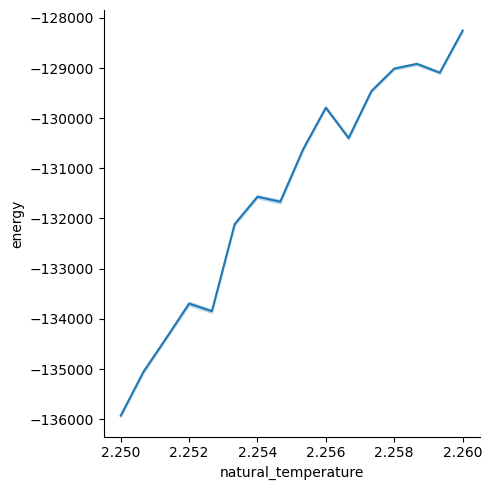

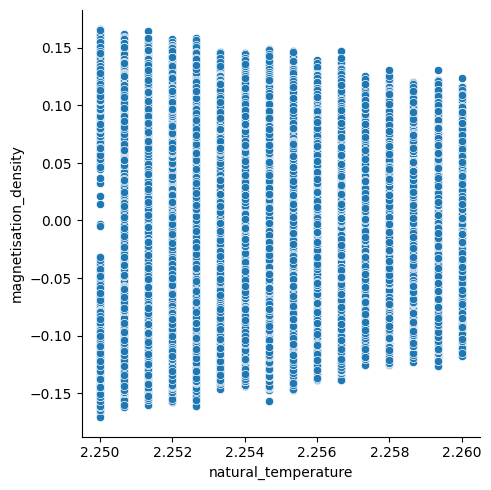

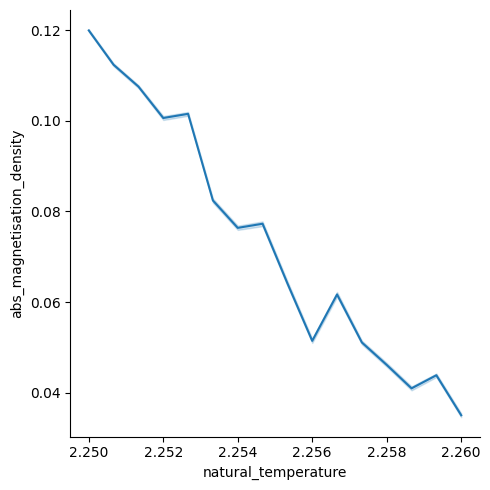

In [23]:
if c.do_measure:
    fig_measure_energy_temp = sns.relplot(
        data=meas_df,
        x="natural_temperature",
        y="energy",
        kind="line",
    )
    fig_measure_energy_temp.savefig(SAVE_PATH / "fig_measure_energy_temp.png")

    fig_measure_mag_dens_temp = sns.relplot(
        data=meas_df,
        x="natural_temperature",
        y="magnetisation_density",
        # kind="line",
    )
    fig_measure_mag_dens_temp.savefig(SAVE_PATH / "fig_measure_mag_dens_temp.png")

    fig_measure_abs_mag_dens_temp = sns.relplot(
        data=meas_df,
        x="natural_temperature",
        y="abs_magnetisation_density",
        kind="line",
    )
    fig_measure_abs_mag_dens_temp.savefig(
        SAVE_PATH / "fig_measure_abs_mag_dens_temp.png"
    )

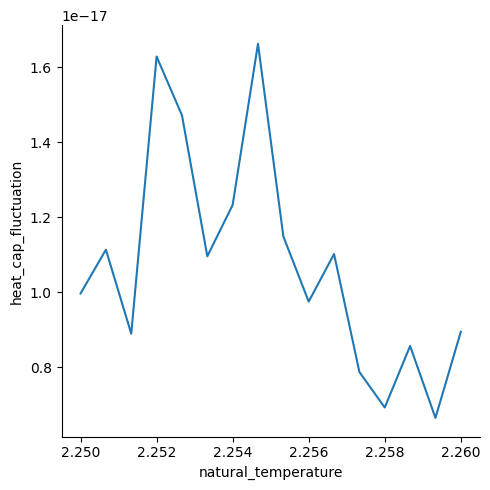

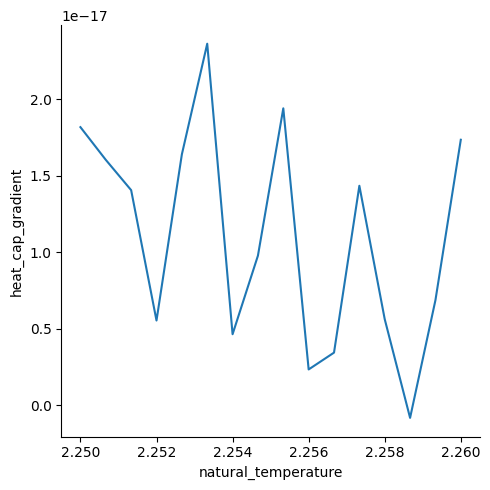

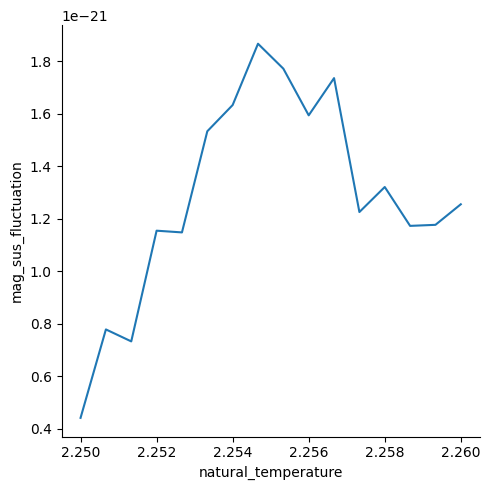

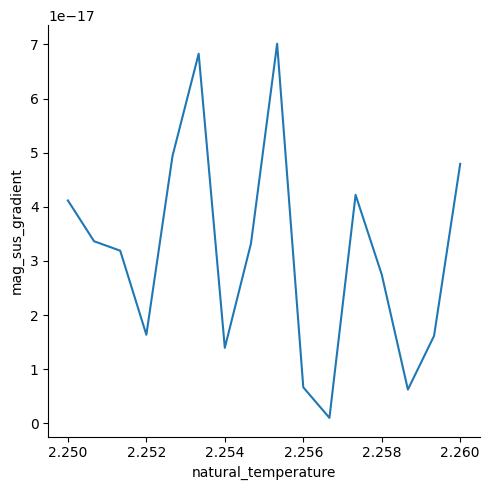

In [24]:
if c.do_measure:
    fig_measure_heat_cap_fluctuation_temp = sns.relplot(
        data=temp_df,
        x="natural_temperature",
        y="heat_cap_fluctuation",
        kind="line",
    )
    fig_measure_heat_cap_fluctuation_temp.savefig(
        SAVE_PATH / "fig_measure_heat_cap_fluctuation_temp.png"
    )

    fig_measure_heat_cap_gradient_temp = sns.relplot(
        data=temp_df,
        x="natural_temperature",
        y="heat_cap_gradient",
        kind="line",
    )
    fig_measure_heat_cap_gradient_temp.savefig(
        SAVE_PATH / "fig_measure_heat_cap_gradient_temp.png"
    )

    if not c.interaction_external_field:
        fig_measure_mag_sus_fluctuation_temp = sns.relplot(
            data=temp_df,
            x="natural_temperature",
            y="mag_sus_fluctuation",
            kind="line",
        )
        fig_measure_mag_sus_fluctuation_temp.savefig(
            SAVE_PATH / "fig_measure_mag_sus_fluctuation_temp.png"
        )

        fig_measure_mag_sus_gradient_temp = sns.relplot(
            data=temp_df,
            x="natural_temperature",
            y="mag_sus_gradient",
            kind="line",
        )
        fig_measure_mag_sus_gradient_temp.savefig(
            SAVE_PATH / "fig_measure_mag_sus_gradient_temp.png"
        )

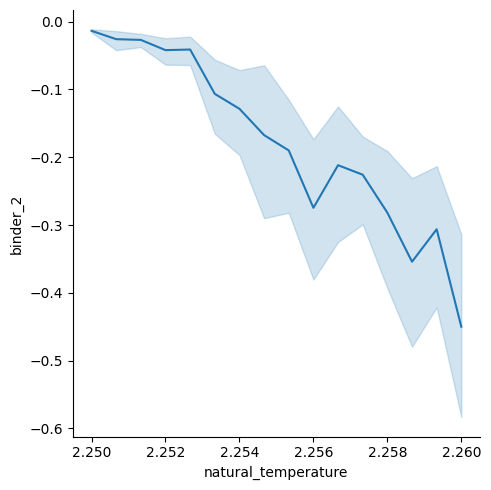

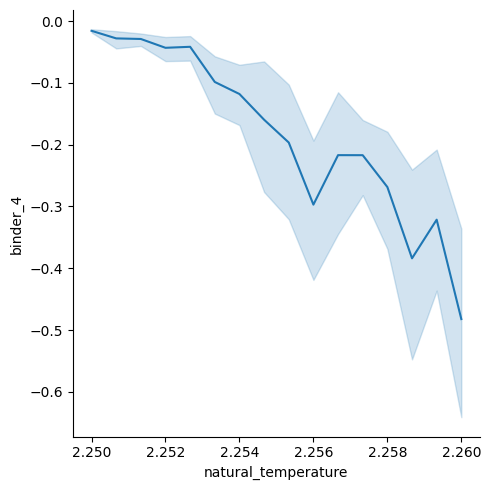

In [25]:
if c.do_measure:
    fig_measure_binder_2 = sns.relplot(
        data=sample_df,
        x="natural_temperature",
        y="binder_2",
        kind="line",
    )
    fig_measure_binder_2.savefig(SAVE_PATH / "fig_measure_binder_2.png")

    fig_measure_binder_4 = sns.relplot(
        data=sample_df,
        x="natural_temperature",
        y="binder_4",
        kind="line",
    )
    fig_measure_binder_4.savefig(SAVE_PATH / "fig_measure_binder_4.png")

In [26]:
with open(SAVE_PATH / "saved_variables.json", "w") as f:
    json.dump(
        to_save, f, indent=4, sort_keys=True, ensure_ascii=False, cls=NumpyEncoder
    )